In [1]:
%load_ext pycodestyle_magic
%flake8_on
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
"""Python code to classify X-ray sources by color.

Functionalities needed.

1. Line, step, scatter and histogram and kde plots
2. Plot net counts, bg/net and S/N ratio
3. Process detectors seperately and combine colors only optional
4. Cross-match 4XMM and CSC sources.
5. Compare with Haley et al. sources.
"""


import copy
import os
import glob2
import warnings
import xspec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import median_filter


# Plot functions
def set_plotparams(plottype):
    """Set plot parameters."""
    if plottype == 'notebook':
        plt.rcParams["figure.figsize"] = (20, 15)
        plt.rcParams["axes.titlesize"] = 24
        plt.rcParams["axes.labelsize"] = 24
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 10
        plt.rcParams["xtick.labelsize"] = 20
        plt.rcParams["ytick.labelsize"] = 20
        plt.rcParams["legend.fontsize"] = 20
        plt.rcParams['xtick.major.size'] = 16
        plt.rcParams['xtick.minor.size'] = 8
        plt.rcParams['ytick.major.size'] = 16
        plt.rcParams['ytick.minor.size'] = 8
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'presentation':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 16
        plt.rcParams["axes.labelsize"] = 14
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 5
        plt.rcParams["xtick.labelsize"] = 12
        plt.rcParams["ytick.labelsize"] = 12
        plt.rcParams["legend.fontsize"] = 12
        plt.rcParams['xtick.major.size'] = 8
        plt.rcParams['xtick.minor.size'] = 4
        plt.rcParams['ytick.major.size'] = 8
        plt.rcParams['ytick.minor.size'] = 4
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'paper1':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 14
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
    elif plottype == 'paper2':
        plt.rcParams["figure.figsize"] = (8, 6)
        plt.rcParams["axes.titlesize"] = 20
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'


def plotline_scatter(xdatas, ydatas, pl_types=None, axs=None, xlabel=None,
                     ylabel=None, pl_labels=None, styles=None, colors=None,
                     yscale='linear', title=None, ylim=None, figsize=None):
    """Plot line, step and scatter plots."""
    if pl_types is None:
        pl_types = ['line']*len(ydatas)
    if axs is None:
        fig, axs = plt.subplots(figsize=figsize)
    if pl_labels is None:
        pl_labels = [None]*len(ydatas)
    if styles is None:
        styles = ['-']*len(ydatas)
    if colors is None:
        if len(ydatas) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(ydatas) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(ydatas/9)+1)))

    axs.set_title(title)
    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])
    axs.set_xlabel(xlabel)
    axs.set_xscale('log')
    axs.set_yscale(yscale)
    axs.set_ylabel(ylabel)
    for i, pl_type in enumerate(pl_types):
        if pl_type == 'line':
            axs.plot(xdatas[i], ydatas[i], linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        elif pl_type == 'scatter':
            if styles[i] == '-':
                styles[i] = 'o'
            axs.scatter(xdatas[i], ydatas[i], marker=styles[i],
                        label=pl_labels[i], color=colors[i])
        elif pl_type == 'step':
            ydatas[i] = np.append(ydatas[i], ydatas[i].copy()[-1])
            axs.step(xdatas[i], ydatas[i], where='post', linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        else:
            raise ValueError("pl_type can only be 'line' or 'scatter'. Got " +
                             pl_type)
    axs.legend()
    return axs


def plothist(data_arr, data2=None, axs=None, bins=None, xlabel=None,
             ylabel=None, pl_labels=None, pl_type=None, cbar_label=None,
             colors=None):
    """Plot 1D and 2D histograms."""
    if axs is None:
        fig, axs = plt.subplots()
    if pl_type is None:
        pl_type = 'withoutkde'
    if pl_labels is None and isinstance(data_arr[0], (list, np.ndarray)):
        pl_labels = [None]*len(data_arr)
    if colors is None:
        if len(data_arr) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(data_arr) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(data_arr/9)+1)))
    if colors is None and data2 is not None:
        colors = 'plasma_r'
    axs.set_xlabel(xlabel)
    if data2 is None:
        if pl_type == 'withkde':
            if ylabel is None:
                ylabel = 'Density per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, density=True, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            if not isinstance(data_arr[0], (list, np.ndarray)):
                data_arr = [data_arr]
            for i, data in enumerate(data_arr):
                if pl_labels[i] is not None:
                    sns.kdeplot(x=data, label=pl_labels[i]+'_kde', ax=axs,
                                color=colors[i])
                else:
                    sns.kdeplot(x=data, ax=axs)
            axs.legend()
        else:
            if ylabel is None:
                ylabel = '# per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            axs.legend()
    else:
        # 2D hist
        axs.set_ylabel(ylabel)
        if bins is None:
            bins = 10
        if pl_type == 'withkde':
            histplot = axs.hist2d(data_arr, data2, bins=bins, density=True,
                                  cmap=colors)[-1]
            sns.kdeplot(x=data_arr, y=data2, ax=axs)
            cbar = plt.colorbar(mappable=histplot, ax=axs, color='k')
            if cbar_label is None:
                cbar_label = 'Density per bin'
            cbar.set_label(cbar_label)
        else:
            histplot = axs.hist2d(data_arr, data2)[-1]
            cbar = plt.colorbar(mappable=histplot, ax=axs)
            if cbar_label is None:
                cbar_label = '# per bin'
            cbar.set_label(cbar_label)
    return axs


def plot_subplots(numrows, numcols, xdatas_arr, ydatas_arr, title=None,
                  subp_types_arr=None, pl_types_arr=None, xlabel_arr=None,
                  ylabel_arr=None, pl_labels_arr=None, styles_arr=None,
                  bins_arr=None, cbar_labels=None, yscale_arr=None,
                  ylim_arr=None, colors_arr=None):
    """Plot subplots"""
    if subp_types_arr is None:
        subp_types_arr = [['linescatter']*numcols]*numrows
    if pl_types_arr is None:
        pl_types_arr = [[None]*numcols]*numrows
    if pl_labels_arr is None:
        pl_labels_arr = [[None]*numcols]*numrows
    if xlabel_arr is None:
        xlabel_arr = [[None]*numcols]*numrows
    if ylabel_arr is None:
        ylabel_arr = [[None]*numcols]*numrows
    if styles_arr is None:
        styles_arr = [[None]*numcols]*numrows
    if bins_arr is None:
        bins_arr = [[None]*numcols]*numrows
    if cbar_labels is None:
        cbar_labels = [[None]*numcols]*numrows
    if yscale_arr is None:
        yscale_arr = [['linear']*numcols]*numrows
    if ylim_arr is None:
        ylim_arr = [[None]*numcols]*numrows
    if colors_arr is None:
        colors_arr = [[None]*numcols]*numrows

    # Checking if all the arrays are 2D
    if not isinstance(subp_types_arr[0], list):
        subp_types_arr = list(map(list, zip(*[subp_types_arr])))
    if not isinstance(pl_labels_arr[0], list):
        pl_labels_arr = list(map(list, zip(*[pl_labels_arr])))
    if not isinstance(xlabel_arr[0], list):
        xlabel_arr = list(map(list, zip(*[xlabel_arr])))
    if not isinstance(ylabel_arr[0], list):
        ylabel_arr = list(map(list, zip(*[ylabel_arr])))

    # Calling the figure and axes
    fig, axes = plt.subplots(numrows, numcols)
    fig.suptitle(title)
    axes = axes.reshape(numrows, numcols)
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) - 4*(numcols-1))
    print(plt.rcParams["legend.fontsize"])
    if numrows == 1 and numcols == 1:
        initial_figsize = plt.rcParams["figure.figsize"]
        plt.rcParams["figure.figsize"] = (12, 9)

    for i in range(numrows):
        for j in range(numcols):
            if subp_types_arr[i][j] == 'linescatter':
                plotline_scatter(
                    xdatas_arr[i][j], ydatas_arr[i][j], pl_types_arr[i][j],
                    axs=axes[i][j], xlabel=xlabel_arr[i][j],
                    ylabel=ylabel_arr[i][j], pl_labels=pl_labels_arr[i][j],
                    styles=styles_arr[i][j], yscale=yscale_arr[i][j],
                    ylim=ylim_arr[i][j], colors=colors_arr[i][j])
            elif subp_types_arr[i][j] == 'hist':
                plothist(xdatas_arr[i][j], ydatas_arr[i][j], axs=axes[i][j],
                         bins=bins_arr[i][j], xlabel=xlabel_arr[i][j],
                         ylabel=ylabel_arr[i][j],
                         pl_labels=pl_labels_arr[i][j],
                         pl_type=pl_types_arr[i][j],
                         cbar_label=cbar_labels[i][j], colors=colors_arr[i][j])
            else:
                print('subplot type can be linescatter or hist')
    plt.tight_layout()
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) + 4*(numcols-1))
    if numrows == 1 and numcols == 1:
        plt.rcParams["figure.figsize"] = initial_figsize
    return fig, axes


def filter_specs(net_counts, bg_counts, min_netcounts=None, maxbg_ratio=None,
                 det_mask=None):
    """Filter specs."""
    bgratio = bg_counts/net_counts
    filter_mask = det_mask.copy()
    if det_mask is None:
        det_mask = np.ones(len(net_counts), dtype=bool)
    if min_netcounts is not None:
        filter_mask[net_counts < min_netcounts] = False
    if maxbg_ratio is not None:
        filter_mask[bgratio > maxbg_ratio] = False
    return filter_mask


def load_sim_xmmspec(folder, background=False, numsim=20000, basename=None):
    """Load simulated XMM MOS and PN spectra."""
    if basename is None:
        basename = ''
    pn_specs = np.zeros((numsim, 4096), dtype=np.float64)
    pn_bgspecs = np.zeros((numsim, 4096), dtype=np.float64)
    mos_specs = np.zeros((numsim, 2400), dtype=np.float64)
    mos_bgspecs = np.zeros((numsim, 2400), dtype=np.float64)
    pn_mask = np.zeros(numsim, dtype=bool)
    mos_mask = np.zeros(numsim, dtype=bool)
    for i in range(numsim):
        pnfile = folder + basename + str(i) + '_PN.fak'
        mosfile = folder + basename + str(i) + '_MOS.fak'
        if os.path.isfile(pnfile):
            pn_mask[i] = True
            spec_data = fits.open(pnfile)
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pnfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                pn_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
        if os.path.isfile(mosfile):
            mos_mask[i] = True
            spec_data = fits.open(mosfile)
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                mos_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
    return ([pn_mask, mos_mask], [pn_specs, mos_specs],
            [pn_bgspecs, mos_bgspecs])


def load_xmmspec_observed(folder, background=False):
    """Load Observed XMM spec."""
    pn_specfiles = glob2.glob(folder + '*PN_combined_src_grp.ds')
    print('# PN files init:', len(pn_specfiles))
    mos_specfiles = glob2.glob(folder + '*MOS_combined_src_grp.ds')
    print('# PN files init:', len(pn_specfiles))
    num_combined = len(glob2.glob(folder + '*PN_MOS_combined_src.png'))
    num_sources = len(pn_specfiles) + len(mos_specfiles) - num_combined
    pn_specs = np.zeros((num_sources, 4096), dtype=float)
    pn_mask = np.zeros(num_sources, dtype=bool)
    mos_specs = np.zeros((num_sources, 2400), dtype=float)
    mos_mask = np.zeros(num_sources, dtype=bool)
    pn_bgspecs = np.zeros((num_sources, 4096), dtype=float)
    mos_bgspecs = np.zeros((num_sources, 2400), dtype=float)
    source_nums = np.zeros(num_sources, dtype=object)
    for i in range(num_sources):
        if i < len(pn_specfiles):
            pn_mask[i] = True
            source_nums[i] = pn_specfiles[i].split('/')[-1].split('_')[0]
            spec_data = fits.open(pn_specfiles[i])
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pn_specfiles[i][:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                pn_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
            if os.path.isfile(folder + source_nums[i] +
                              '_MOS_combined_src_grp.ds'):
                mosfile = folder + source_nums[i] + '_MOS_combined_src_grp.ds'
                spec_data = fits.open(mosfile)
                mos_mask[i] = True
                mos_specfiles.remove(mosfile)
                mos_specs[i] = spec_data[1].data['counts']
                if background:
                    bgfile = mosfile[:-10] + 'bkg_grp.ds'
                    bg_data = fits.open(bgfile)
                    mos_bgspecs[i] = bg_data[1].data['counts']*(
                        spec_data[1].header['backscal'] /
                        bg_data[1].header['backscal'])
        else:
            mos_mask[i] = True
            source_nums[i] = (
                mos_specfiles[i-len(pn_bgspecs)].split('/')[-1].split('_')[0])
            spec_data = fits.open(mos_specfiles[i-len(pn_bgspecs)])
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                mos_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
    return (source_nums, [pn_mask, pn_specs, pn_bgspecs],
            [mos_mask, mos_specs, mos_bgspecs])


def load_chandraspec_sim(folder, background=False, num_sim=10000,
                         basename=None):
    """Load Chandra simulate spectra."""
    if basename is None:
        basename = ''
    specs = np.zeros((num_sim, 1024), dtype=float)
    bg_specs = np.zeros((num_sim, 1024), dtype=float)
    for i in range(num_sim):
        spec_file = folder + basename + str(i) + '.fak'
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bgspec_file = folder + basename + str(i) + '_bkg.fak'
            bg_data = fits.open(bgspec_file)
            bg_specs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return specs, bg_specs


def load_chandraspec_obs(folder, background=True):
    spec_files = glob2.glob(folder + '/*/*_combined_src.pi')
    spec_names = np.zeros(len(spec_files), dtype=object)
    specs = np.zeros((len(spec_files), 1024), dtype=float)
    bgspecs = np.zeros((len(spec_files), 1024), dtype=float)
    for i, spec_file in enumerate(spec_files):
        spec_file_base = os.path.basename(spec_file)
        spec_names[i] = spec_file_base.split('_')[0]
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bg_file = spec_file[:-6] + 'bkg.pi'
            bg_data = fits.open(bg_file)
            bgspecs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return spec_names, specs, bgspecs


def get_counts_enrange(spec, en_range, ebin_channels, floor_counts=None):
    """Get counts in the given energy range."""
    elow_index = np.where(ebin_channels >= en_range[0])[0][0]
    ehigh_index = np.where(ebin_channels <= en_range[1])[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[elow_index:ehigh_index])
    else:
        counts_enrange = np.sum(spec[:, elow_index:ehigh_index], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                counts_enrange = floor_counts
        else:
            counts_enrange[counts_enrange < floor_counts] = floor_counts
    return counts_enrange, elow_index, ehigh_index


def get_counts_enrange2(spec, en_range, ebin_channels, floor_counts=None):
    """Another method to get counts"""
    en_mask = np.logical_and(ebin_channels >= en_range[0],
                             ebin_channels <= en_range[1])
    elow_index = np.where(en_mask)[0][0]
    ehigh_index = np.where(en_mask)[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[en_mask])
    else:
        counts_enrange = np.sum(spec[:, en_mask], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                floor_counts = 0
        else:
            counts_enrange[counts_enrange < floor_counts] = 0
    return counts_enrange, elow_index, ehigh_index


def get_summary_det(src_spec, bg_spec, ebins, en_range=None,
                    det_mask=None, src_sig=None):
    """Get summary of the spectra for given detector."""
    if en_range is None:
        en_range = [0.2, 10.0]
    net_spec = src_spec - bg_spec
    net_counts, en_lowindex, en_highindex = get_counts_enrange(
        net_spec, en_range, ebins)
    if det_mask is None:
        det_mask = np.ones(len(src_spec), dtype=bool)
    det_mask[net_counts < 1] = False
    net_spec = net_spec[:, en_lowindex:en_highindex]
    bg_counts = get_counts_enrange(bg_spec, en_range, ebins)[0]
    norm_spec = (net_spec.transpose()/net_counts).transpose()
    bg_counts[bg_counts/net_counts < 1.0E-6] = 1.0E-6
    if src_sig is not None:
        det_mask[net_counts < src_sig*bg_counts**0.5] = False
    return (norm_spec, net_counts, bg_counts, det_mask, en_lowindex,
            en_highindex)


def join_lists_3d(list1_2d, list2_2d, list3_2d=None):
    """Join 2 lists along another dimention."""
    joined_list = []
    for i, row in enumerate(list1_2d):
        if list3_2d is None:
            joined_list.append([row, list2_2d[i]])
        else:
            joined_list.append([row, list2_2d[i], list3_2d[i]])
    return joined_list


def join_string_lists(list1_1d, list2_1d):
    """Outer product like addition of 2 strings"""
    joined_list = []
    join_list_row = None
    for string2 in list2_1d:
        for string1 in list1_1d:
            if join_list_row is None:
                join_list_row = [string1 + ' [' + string2 + ']']
            else:
                join_list_row.append(string1 + ' [' + string2 + ']')
        joined_list.append(copy.copy(join_list_row))
        join_list_row = None
    return joined_list


def plot_spec_summary(sim_src_spec_arr, sim_bg_spec_arr, obs_src_spec_arr,
                      obs_bg_spec_arr, ebins_arr, det_names=None, e_range=None,
                      plot=True, det_mask_sim_arr=None, det_mask_obs_arr=None):
    """Plot spec summary.

    1. Mean normalized spectra (also add error fn.)
    2. Net count, Net count/Bg counts, signal-to-noise ratio plots for
       each det.
    """
    norm_specs = []
    netcounts = []
    bgcounts = []
    ebins_lowhigh_indices = []
    if plot:
        ebins_refined = []
        norm_specs_forplot = []
        netcounts_forplot = []
        bg_net_ratio_forplot = []
        s_to_n_ratio_forplot = []
    if det_mask_sim_arr is None:
        det_mask_sim_arr = [None]*len(sim_src_spec_arr)
    if det_mask_obs_arr is None:
        det_mask_obs_arr = [None]*len(obs_src_spec_arr)
    if det_names is None:
        det_names = ['']*len(sim_src_spec_arr)

    for i, sim_src_specs in enumerate(sim_src_spec_arr):
        (sim_norm_spec, sim_netcounts, sim_bgcounts, sim_detmask,
         en_lowindex, en_highindex) = get_summary_det(
            sim_src_specs, sim_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_sim_arr[i]), 3.0)
        (obs_norm_spec, obs_netcounts, obs_bgcounts,
         obs_detmask) = get_summary_det(
            obs_src_spec_arr[i], obs_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_obs_arr[i]), 3.0)[:4]
        norm_specs.append([sim_norm_spec, obs_norm_spec])
        netcounts.append([sim_netcounts, obs_netcounts])
        bgcounts.append([sim_bgcounts, obs_bgcounts])
        ebins_lowhigh_indices.append([en_lowindex, en_highindex])
        det_mask_sim_arr[i] = sim_detmask
        det_mask_obs_arr[i] = obs_detmask
        if plot:
            ebins_refined.append(ebins_arr[i][en_lowindex:en_highindex])
            filter_size = int(0.2/(ebins_arr[i][en_lowindex+1] -
                                   ebins_arr[i][en_lowindex]))
            norm_specs_forplot.append([
                median_filter(np.mean(sim_norm_spec[sim_detmask], axis=0),
                              size=filter_size),
                median_filter(np.mean(obs_norm_spec[obs_detmask], axis=0),
                              size=filter_size)])
            netcounts_forplot.append([np.log10(sim_netcounts[sim_detmask]),
                                      np.log10(obs_netcounts[obs_detmask])])
            bg_net_ratio_forplot.append([
                np.log10((sim_bgcounts/sim_netcounts)[sim_detmask]),
                np.log10((obs_bgcounts/obs_netcounts)[obs_detmask])])
            s_to_n_ratio_forplot.append([
                np.log10((sim_netcounts /
                         (sim_netcounts+sim_bgcounts)**0.5)[sim_detmask]),
                np.log10((obs_netcounts /
                         (obs_netcounts+obs_bgcounts)**0.5)[obs_detmask])]
            )

    if plot is False:
        return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
                det_mask_sim_arr, det_mask_obs_arr)

    for i, norm_spec_sim_obs in enumerate(norm_specs_forplot):
        plotline_scatter([ebins_refined[i], ebins_refined[i]],
                         norm_spec_sim_obs, xlabel='Energy (keV)',
                         ylabel='Smoothed mean normalized spectra',
                         pl_labels=['Sim. ' + det_names[i] + ' spectra',
                                    'Obs. ' + det_names[i] + ' spectra'],
                         title=('Simulated and Observed ' + det_names[i] +
                                ' spectra'),
                         figsize=(12, 9))

    hist1D_joined_list = join_lists_3d(netcounts_forplot,
                                       bg_net_ratio_forplot,
                                       s_to_n_ratio_forplot)
    plot_subplots(
        len(norm_specs_forplot), 3, hist1D_joined_list,
        [[None]*3]*len(norm_specs_forplot),
        title='1D histograms of net and background counts',
        xlabel_arr=join_string_lists(
            ['log (Net counts)', 'log (Bg counts/Net counts)',
             'Signal-to-Noise Ratio'], det_names),
        ylabel_arr=[['# density per bin']*3]*len(norm_specs_forplot),
        subp_types_arr=[['hist']*3]*3,
        pl_types_arr=[['withkde']*3]*3,
        pl_labels_arr=[
            [['Simulated MSPs', 'Observed sources']]*3]*len(norm_specs_forplot)
    )

    return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
            det_mask_sim_arr, det_mask_obs_arr)


def get_enbins_centres(resp_file):
    """Get Energy bins and centres."""
    response = fits.open(resp_file)
    energy_bins = response[2].data
    emin = energy_bins['E_MIN']
    emax = energy_bins['E_MAX']
    e_centres = 0.5*(emin + emax)
    return np.append(emin, emax[-1]), e_centres


def get_line_cont_counts(src_spec, bg_spec, ebins, net_spec=None,
                         range_fe=None, cont1_range=None, cont2_range=None):
    """Get line and continuum counts"""
    if net_spec is None:
        net_spec = src_spec - bg_spec
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if cont1_range is None:
        cont1_range = [5.8, 6.2]
    if cont2_range is None:
        cont2_range = [7.2, 7.6]
    sim_fe_net = get_counts_enrange(net_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_src = get_counts_enrange(src_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_bg = get_counts_enrange(bg_spec, range_fe, ebins,
                                   floor_counts=0)[0]

    sim_cont1_net = get_counts_enrange(net_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_src = get_counts_enrange(src_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_bg = get_counts_enrange(bg_spec, cont1_range, ebins,
                                      floor_counts=0)[0]

    sim_cont2_net = get_counts_enrange(net_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_src = get_counts_enrange(src_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_bg = get_counts_enrange(bg_spec, cont2_range, ebins,
                                      floor_counts=0)[0]
    return ([sim_fe_net, sim_fe_src, sim_fe_bg],
            [sim_cont1_net, sim_cont1_src, sim_cont1_bg],
            [sim_cont2_net, sim_cont2_src, sim_cont2_bg])


def get_colors_basic(counts_line_net, counts_cont1_net, counts_cont2_net,
                     mask=None):
    """Get colors."""
    if mask is None:
        mask = np.ones(len(counts_line_net), dtype=bool)
    colors = counts_line_net/(counts_cont1_net + counts_cont2_net)
    colors[~mask] = np.nan
    return colors


def get_colors_binned(colors, src_prop, srcprop_bins, mask=None):
    """Get expected color for given bins."""
    mean_colors = np.zeros(len(srcprop_bins)-1)
    median_colors = np.zeros(len(srcprop_bins)-1)
    colors_std = np.zeros(len(srcprop_bins)-1)
    for i, bin_edge in enumerate(srcprop_bins[:-1]):
        mean_colors[i], median_colors[i], colors_std[i] = get_colors_perbin(
            colors, src_prop, [bin_edge, srcprop_bins[i+1]])
    return mean_colors, colors_std, median_colors


def get_colors_perbin(colors, src_prop, bin_edges):
    """Get expected color for each bin"""
    mask = np.where(np.logical_and(np.logical_and(src_prop >= bin_edges[0],
                                                  src_prop < bin_edges[1]),
                                   np.isfinite(colors)))
    bin_colors = colors[mask]
    # return np.mean(bin_colors), np.median(bin_colors), np.std(bin_colors)
    return sigma_clipped_stats(bin_colors, sigma=5)


def bin_colors_withprop(colors, prop_list, prop_listnames, obs_colors,
                        obs_props, prop_binslist=None, plot=True, plot_det=''):
    """Bin colors with properties."""
    mean_colors_withprop = []
    median_colors_withprop = []
    std_colors_withprop = []
    if prop_binslist is None:
        prop_binslist = []
        no_given_bins = True
    else:
        no_given_bins = False
    for i in range(len(prop_list)):
        print('Calaculating mean and standard deviation in colors vs. ' +
              prop_listnames[i])
        if no_given_bins:
            prop_bins = 10**np.linspace(
                np.log10(max(0.00001, np.min(prop_list[i]))),
                np.log10(min(1.0E+5, np.max(prop_list[i]))), 21)
            prop_binslist.append(prop_bins)
        mean_colors, colors_std, median_colors = get_colors_binned(
            colors, prop_list[i], prop_binslist[i])
        mean_colors_withprop.append(mean_colors)
        std_colors_withprop.append(colors_std)
        median_colors_withprop.append(median_colors)
        if plot:
            plot_subplots(
                1, 2, [[[prop_list[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])],
                       [obs_props[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])]]],
                [[[colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std],
                 [obs_colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std]]],
                subp_types_arr=[['linescatter', 'linescatter']],
                pl_types_arr=[[['scatter', 'step', 'step'],
                              ['scatter', 'step', 'step']]],
                xlabel_arr=[[prop_listnames[i], prop_listnames[i]]],
                ylabel_arr=[['Simulated source colors',
                            'Observed source colors']],
                pl_labels_arr=[[['Colors', 'Mean + 2.0std', 'Mean - 2.0std'],
                                ['Colors', 'Mean + 2.0std', 'Mean - 2.0std']]],
                title='Color vs ' + prop_listnames[i] + ' for ' + plot_det,
                ylim_arr=[[(0, 5), (0, 5)], [(0, 5), (0, 5)]])
    return (prop_binslist, mean_colors_withprop, std_colors_withprop,
            median_colors_withprop)


def load_alldata(response_paths, sim_spec_paths, obs_spec_paths, range_fe=None,
                 range_cont1=None, range_cont2=None, en_range=None):
    """Main function to process the entire dataset."""
    det_enbins_arr = []
    det_ecenters_arr = []
    sim_srcspec_arr = []
    sim_bgspec_arr = []
    sim_mask_arr = []
    obs_srcspec_arr = []
    obs_bgspec_arr = []
    obs_mask_arr = []
    obs_src_nums = []
    det_names = ['PN', 'MOS', 'ACIS']
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if range_cont1 is None:
        range_fe = [5.8, 6.2]
    if range_cont2 is None:
        range_fe = [7.2, 7.6]
    if en_range is None:
        en_range = [2, 10]
    for i, response in enumerate(response_paths):
        # Load energy bins
        det_ebins, det_ecenters = get_enbins_centres(response)
        det_enbins_arr.append(det_ebins)
        det_ecenters_arr.append(det_ecenters)
        # Load spectra
        if i == 0:
            ([sim1_mask, sim2_mask], [sim1_specs, sim2_specs],
             [sim1_bgs, sim2_bgs]) = load_sim_xmmspec(
                sim_spec_paths[i], background=True, basename='msp_highNH_')
            (source_nums, [obs1_mask, obs1_specs, obs1_bgs],
             [obs2_mask, obs2_specs, obs2_bgs]) = load_xmmspec_observed(
                obs_spec_paths[i], background=True)
            sim_srcspec_arr.append(sim1_specs)
            sim_srcspec_arr.append(sim2_specs)
            sim_bgspec_arr.append(sim1_bgs)
            sim_bgspec_arr.append(sim2_bgs)
            sim_mask_arr.append(sim1_mask)
            sim_mask_arr.append(sim2_mask)
            obs_srcspec_arr.append(obs1_specs)
            obs_srcspec_arr.append(obs2_specs)
            obs_bgspec_arr.append(obs1_bgs)
            obs_bgspec_arr.append(obs2_bgs)
            obs_mask_arr.append(obs1_mask)
            obs_mask_arr.append(obs2_mask)
            obs_src_nums.append(source_nums)
        elif i == 2:
            sim_specs, sim_bgs = load_chandraspec_sim(
                sim_spec_paths[i], background=True, num_sim=10000,
                basename='msp_highNH_')
            src_names, obs_specs, obs_bgs = load_chandraspec_obs(
                obs_spec_paths[i])
            sim_mask = np.ones(len(sim_specs), dtype=bool)
            obs_mask = np.ones(len(obs_specs), dtype=bool)
            sim_srcspec_arr.append(sim_specs)
            sim_bgspec_arr.append(sim_bgs)
            sim_mask_arr.append(sim_mask)
            obs_srcspec_arr.append(obs_specs)
            obs_bgspec_arr.append(obs_bgs)
            obs_mask_arr.append(obs_mask)
            obs_src_nums.append(src_names)
        else:
            pass
    # Plot spec summary
    (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices, det_mask_sim,
     det_mask_obs) = plot_spec_summary(
        sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr, obs_bgspec_arr,
        det_enbins_arr, det_names, en_range, True, sim_mask_arr, obs_mask_arr)
    spec_summary = {'ebins': [det_enbins_arr, det_ecenters_arr],
                    'elowhigh': ebins_lowhigh_indices,
                    'specs': [sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr,
                              obs_bgspec_arr],
                    'spec_masks': [det_mask_sim, det_mask_obs],
                    'src_nums': obs_src_nums,
                    'norm_specs': norm_specs,
                    'counts': [netcounts, bgcounts]}
    return spec_summary


def getcolor_prop_singledet(det_ebins, det_srcspecs, det_bgspecs,
                            det_netcounts, det_bgcounts, det_obs_srcspecs,
                            det_obs_bgspecs, det_obsnetcounts, det_obsbgcounts,
                            range_fe=None, netcounts_lowhigh=None,
                            bgratio_lowhigh=None, snr_lowhigh=None,
                            det_name=None, plot=False):
    """Process single detector.

    Values may include nan. Will have to be masked later for plotting. Else
    submit already masked values
    """
    print(len(det_srcspecs), len(det_bgspecs), len(det_bgcounts), len(det_netcounts))
    print(len(det_obs_srcspecs), len(det_obs_bgspecs), len(det_obsbgcounts), len(det_obsnetcounts))
    bg_net_ratio = det_bgcounts/det_netcounts
    obs_bgnet_ratio = det_obsbgcounts/det_obsnetcounts
    sim_snr = det_netcounts/(det_netcounts + det_bgcounts)**0.5
    obs_snr = det_obsnetcounts/(det_obsnetcounts + det_obsbgcounts)**0.5
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    if netcounts_lowhigh is None:
        netcount_bins = 10**(np.linspace(1, 5, 21))
    else:
        netcount_bins = 10**(np.linspace(np.log10(netcounts_lowhigh[0]),
                                         np.log10(netcounts_lowhigh[1]), 21))
    if bgratio_lowhigh is None:
        bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    else:
        bg_net_ratio_bins = 10**(np.linspace(np.log10(bgratio_lowhigh[0]),
                                             np.log10(bgratio_lowhigh[1]), 21))
    if snr_lowhigh is None:
        snr_bins = 10**(np.linspace(0, 3, 21))
    else:
        snr_bins = 10**(np.linspace(np.log10(snr_lowhigh[0]),
                                    np.log10(snr_lowhigh[1]), 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [det_netcounts, bg_net_ratio, sim_snr],
        ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio'],
        obs_det_colors, [det_obsnetcounts, obs_bgnet_ratio, obs_snr],
        [netcount_bins, bg_net_ratio_bins, snr_bins], plot=plot,
        plot_det=det_name)[1:]
    sim_colors_dict = {'prop_list': [det_netcounts, bg_net_ratio, sim_snr],
                       'prop_bins': [netcount_bins, bg_net_ratio_bins,
                                     snr_bins],
                       'fe_cont_counts': [fe_net, cont1_net, cont2_net],
                       'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                       'colors': det_colors,
                       'color_stat': [mean_colors_withprop,
                                      median_colors_withprop,
                                      std_colors_withprop]}
    obs_colors_dict = {'prop_list': [det_obsnetcounts, obs_bgnet_ratio,
                                     obs_snr],
                       'fe_cont_counts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                       'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                            obs_cont2_bg],
                       'colors': obs_det_colors}
    return sim_colors_dict, obs_colors_dict


def get_bincenters(bins):
    """Get center of bins."""
    return bins


def getcolor_prop_alldet(spec_summary, compare_det=False):
    """Get colors in all detectors and plot relevant figure."""
    ebins_arr = spec_summary['ebins'][0]
    specs = spec_summary['specs']
    spec_masks = spec_summary['spec_masks']
    counts = spec_summary['counts']
    det_names = ['PN', 'MOS', 'ACIS']
    sim_colors_dict_arr = []
    obs_colors_dict_arr = []
    prop_names = ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio']
    plot_det = not compare_det
    for i, ebins in enumerate(ebins_arr):
        sim_colors_dict, obs_colors_dict = getcolor_prop_singledet(
            ebins, specs[0][i][spec_masks[0][i]],
            specs[1][i][spec_masks[0][i]], counts[0][i][0][spec_masks[0][i]],
            counts[1][i][0][spec_masks[0][i]], specs[2][i][spec_masks[1][i]],
            specs[3][i][spec_masks[1][i]], counts[0][i][1][spec_masks[1][i]],
            counts[1][i][1][spec_masks[1][i]], det_name=det_names[i],
            plot=plot_det)
        sim_colors_dict_arr.append(sim_colors_dict)
        obs_colors_dict_arr.append(obs_colors_dict)
    if compare_det:
        for i in range(3):
            plot_subplots(
                3, 2,
                [[[
                    sim_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])], [
                    obs_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])], [
                    obs_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])], [
                    obs_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])]]],
                [[[
                    sim_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])], [
                    obs_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])], [
                    obs_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])], [
                    obs_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])]]],
                subp_types_arr=[['linescatter']*2]*3,
                pl_types_arr=[[['scatter', 'step', 'step']]*2]*3,
                xlabel_arr=join_string_lists(
                    ['Simulated ' + prop_names[i],
                     'Observed ' + prop_names[i]], det_names),
                ylabel_arr=[['Simulated source colors',
                             'Observed source colors']]*3,
                pl_labels_arr=[[['Colors', r'Mean + 2.0$\sigma$',
                               r'Mean - 2.0$\sigma$']]*2]*3,
                ylim_arr=[[(0, 5)]*2]*3)
    return sim_colors_dict_arr, obs_colors_dict_arr


def process_singledet1(det_ebins, det_srcspecs, det_bgspecs, det_mask,
                       det_name, det_obs_ebins=None, det_obs_srcspecs=None,
                       det_obs_bgspecs=None, det_obsmask=None, range_fe=None):
    """Process single detector data."""
    ([netcounts, obs_netcounts],
     [bgcounts, obs_bgcounts], lowindex, highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[2.0, 10.0], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask)
    ([netcounts_aroundfe, obs_netcounts_aroundfe],
     [bgcounts_aroundfe, obs_bgcounts_aroundfe], aroundfe_lowindex,
     aroundfe_highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[5.8, 7.6], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask, det=det_name)
    bg_net_ratio = bgcounts/netcounts
    obs_bg_netratio = obs_bgcounts/obs_netcounts
    bg_net_ratio_aroundfe = bgcounts_aroundfe/netcounts_aroundfe
    obs_bg_netratio_aroundfe = obs_bgcounts_aroundfe/obs_netcounts_aroundfe
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_obs_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net, mask=det_mask)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    netcount_bins = 10**(np.linspace(1, 5, 21))
    netcount_aroundfe_bins = 10**(np.linspace(0, 4, 21))
    bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    bg_net_ratio_aroundfe_bins = 10**(np.linspace(-2, 1, 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [netcounts, netcounts_aroundfe, bg_net_ratio,
                     bg_net_ratio_aroundfe],
        ['Net counts (2-10 keV)', 'Net counts (5.8-7.6 keV)',
         'Bg/net ratio (2-10 keV)', 'Bg/net ratio (5.8-7.6 keV)'],
        obs_det_colors, [obs_netcounts, obs_netcounts_aroundfe,
                         obs_bg_netratio, obs_bg_netratio_aroundfe],
        [netcount_bins, netcount_aroundfe_bins, bg_net_ratio_bins,
         bg_net_ratio_aroundfe_bins], plot=True, plot_det=det_name)[1:]
    sim_det_dict = {'counts_2_10': [netcounts, bgcounts],
                    'counts_aroundfe': [netcounts_aroundfe, bgcounts],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [fe_net, cont1_net, cont2_net],
                    'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                    'fe_cont_srccounts': [fe_src, cont1_src, cont2_src],
                    'prop_bins': [netcount_bins, netcount_aroundfe_bins,
                                  bg_net_ratio_bins,
                                  bg_net_ratio_aroundfe_bins],
                    'mean_std_colors_withprop': [
                        mean_colors_withprop, std_colors_withprop,
                        median_colors_withprop]}
    obs_det_dict = {'counts_2_10': [obs_netcounts, obs_bgcounts],
                    'counts_aroundfe': [obs_netcounts_aroundfe,
                                        obs_bgcounts_aroundfe],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                    'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                         obs_cont2_bg],
                    'fe_cont_srccounts': [obs_fe_src, obs_cont1_src,
                                          obs_cont2_src]}
    return sim_det_dict, obs_det_dict


def combine_pn_mos_prop(pn_prop, mos_prop, pn_mask, mos_mask):
    """Combine PN and MOS properties."""
    combined_prop = np.zeros_like(pn_prop)
    combined_prop[np.logical_and(
        pn_mask, ~mos_mask)] = pn_prop[np.logical_and(pn_mask, ~mos_mask)]
    combined_prop[np.logical_and(
        ~pn_mask, mos_mask)] = mos_prop[np.logical_and(~pn_mask, mos_mask)]
    combined_prop[np.logical_and(
        pn_mask, mos_mask)] = (pn_prop + mos_prop)[
            np.logical_and(pn_mask, mos_mask)]
    return combined_prop


def combine_wantedprops(pn_dict, mos_dict, pn_mask, mos_mask):
    """Combine the counts from PN and MOS detectors."""
    net_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][0], mos_dict['counts_2_10'][0], pn_mask,
        mos_mask)
    bg_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][1], mos_dict['counts_2_10'][1], pn_mask,
        mos_mask)
    net_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][0], mos_dict['counts_aroundfe'][0], pn_mask,
        mos_mask)
    bg_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][1], mos_dict['counts_aroundfe'][1], pn_mask,
        mos_mask)
    combined_fe_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][0], mos_dict['fe_cont_netcounts'][0],
        pn_mask, mos_mask)
    combined_cont1_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][1], mos_dict['fe_cont_netcounts'][1],
        pn_mask, mos_mask)
    combined_cont2_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][2], mos_dict['fe_cont_netcounts'][2],
        pn_mask, mos_mask)
    combined_colors = get_colors_basic(combined_fe_net, combined_cont1_net,
                                       combined_cont2_net)
    return (net_counts, bg_counts/net_counts, net_counts_aroundfe,
            bg_counts_aroundfe/net_counts_aroundfe, combined_colors)


835:80: E501 line too long (85 > 79 characters)
836:80: E501 line too long (99 > 79 characters)


In [4]:
chandra_response_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/chandra_obs_hard07/2CXOJ174334.1-291117/2CXOJ174334.1-291117_combined_src.rmf'
pn_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/PN/epn_bu23_dY9.rmf.gz'
mos_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/MOS_5eV/m1_e10_im_p0_c.rmf'
chandra_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/chandra_simspecs/'
xmm_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/xmm_pn_mos_simspecs_1/'
xmm_sim_path2 = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/xmm_pn_mos_simspecs_2/'
chandra_obs_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/chandra_obs_hard07/'
xmm_obs_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/xmm_combined_copy/'

1:80: E501 line too long (159 > 79 characters)
2:80: E501 line too long (115 > 79 characters)
3:80: E501 line too long (120 > 79 characters)
4:80: E501 line too long (94 > 79 characters)
5:80: E501 line too long (95 > 79 characters)
6:80: E501 line too long (96 > 79 characters)
7:80: E501 line too long (96 > 79 characters)


In [7]:
set_plotparams('notebook')

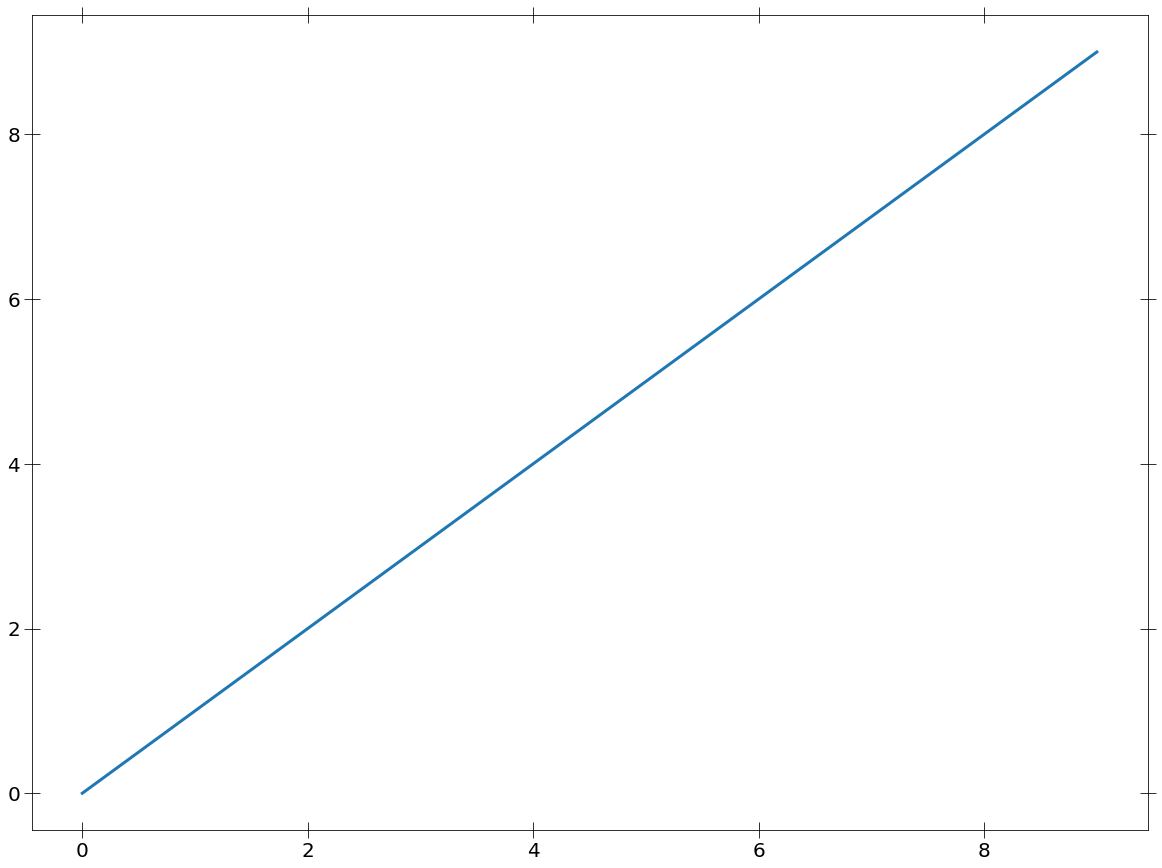

In [8]:
plt.plot(np.arange(10))

# PN files init: 853
# PN files init: 853


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:488: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:489: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:575: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:576: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


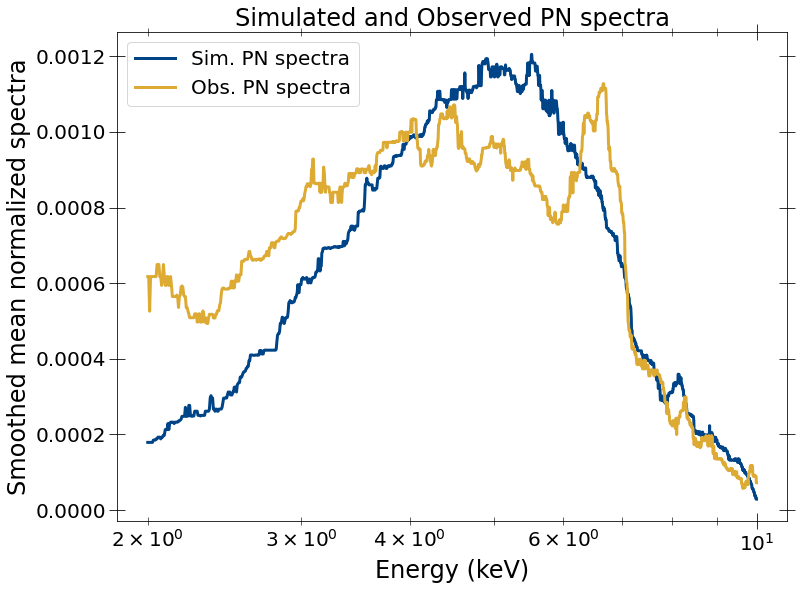

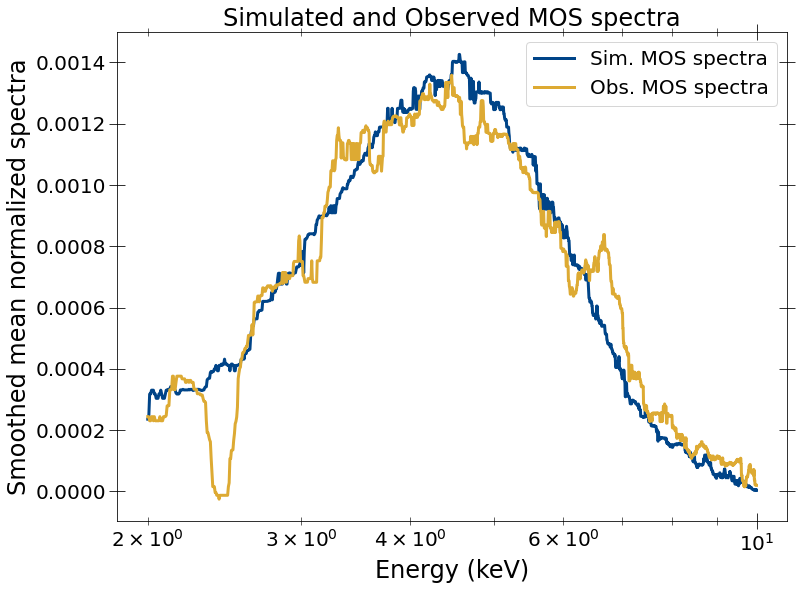

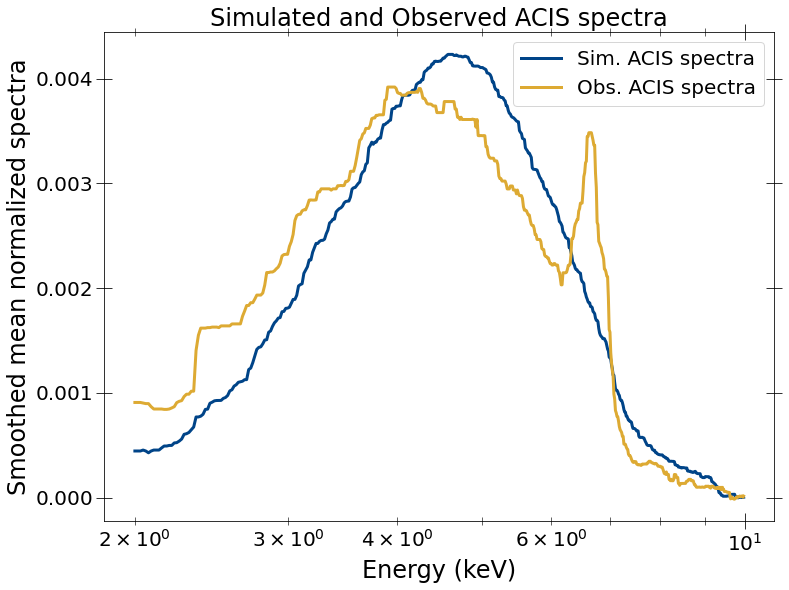

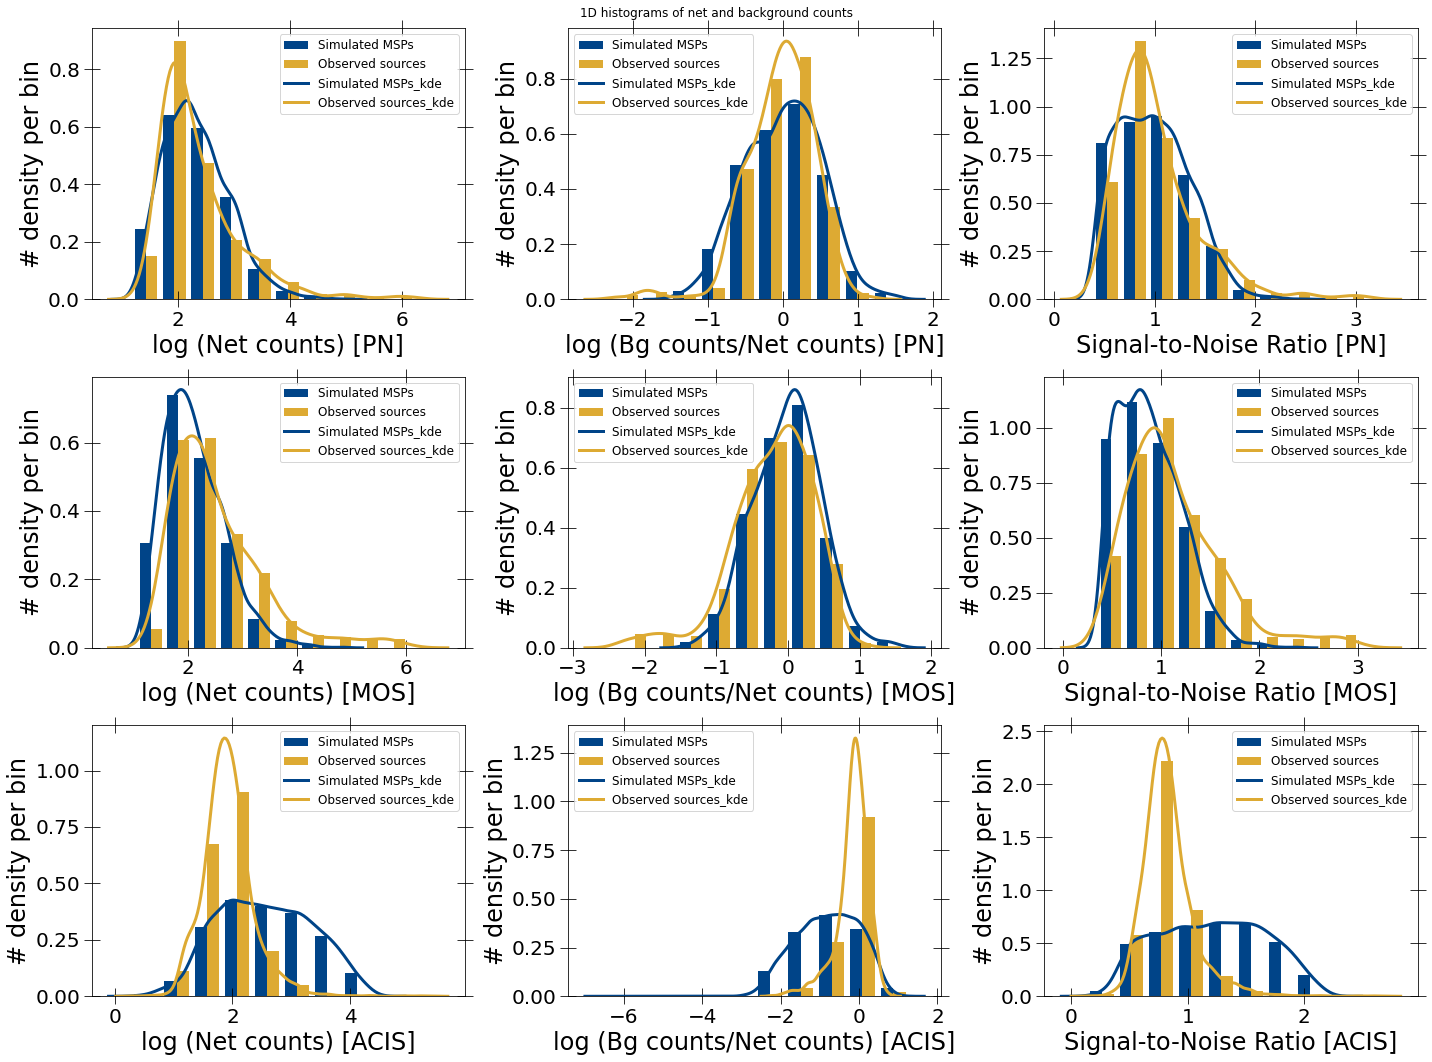

In [9]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

In [11]:
counts_2keV_sim_mos = get_line_cont_counts(spec_summary['specs'][0][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['specs'][1][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.2, 2.7])[0][0]
counts_2keV_obs_mos = get_line_cont_counts(spec_summary['specs'][2][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['specs'][3][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.2, 2.7])[0][0]

1:80: E501 line too long (105 > 79 characters)
2:80: E501 line too long (105 > 79 characters)
5:80: E501 line too long (105 > 79 characters)
6:80: E501 line too long (105 > 79 characters)


In [10]:
counts_3keV_sim_mos = get_line_cont_counts(spec_summary['specs'][0][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['specs'][1][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.7, 3.4])[0][0]
counts_3keV_obs_mos = get_line_cont_counts(spec_summary['specs'][2][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['specs'][3][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.7, 3.4])[0][0]

1:80: E501 line too long (105 > 79 characters)
2:80: E501 line too long (105 > 79 characters)
5:80: E501 line too long (105 > 79 characters)
6:80: E501 line too long (105 > 79 characters)


In [12]:
netcounts_obs = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][1]]
netcounts_sim = spec_summary['counts'][0][1][0][spec_summary['spec_masks'][0][1]]

1:80: E501 line too long (81 > 79 characters)


In [160]:
len(netcounts_obs)

445

In [161]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][105]

'201129721010057'

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 2 BarContainer objects>)

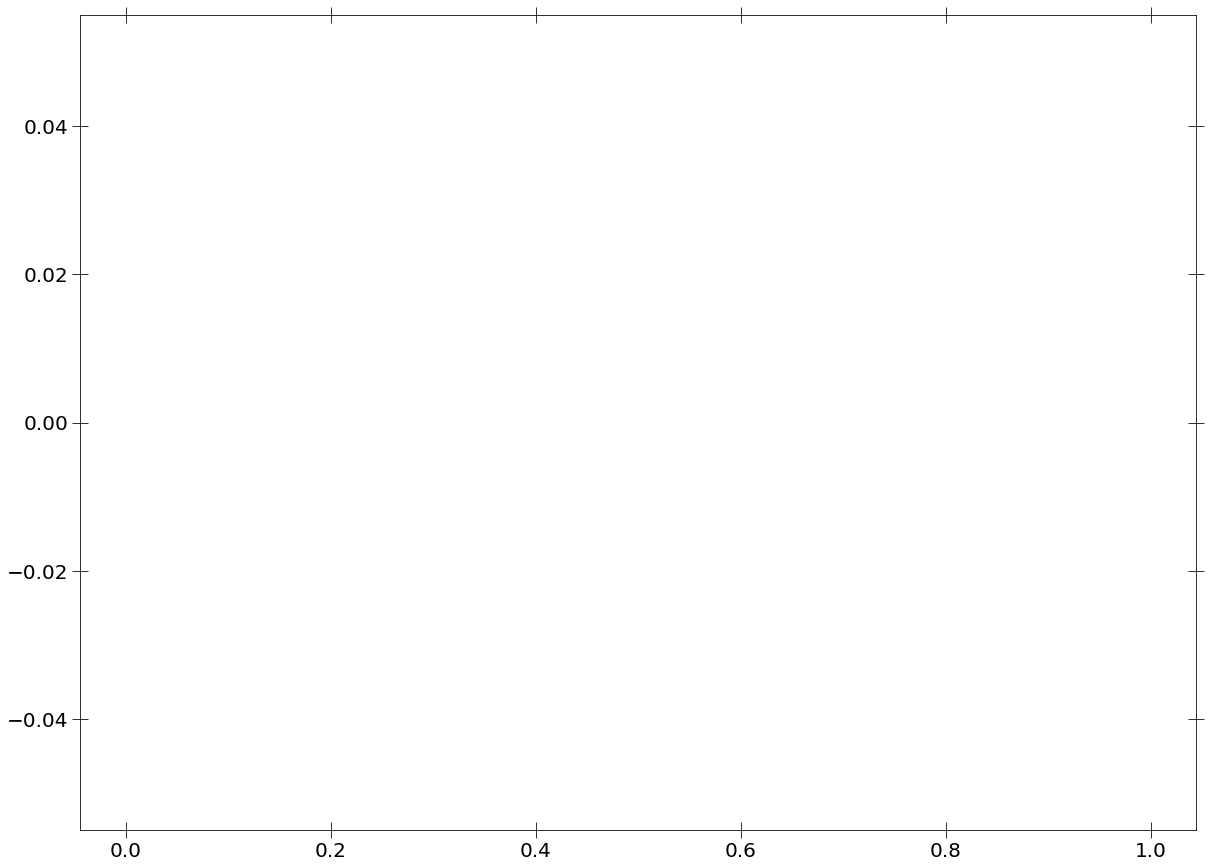

In [13]:
plt.hist([(counts_2keV_sim_mos/netcounts_sim)[counts_2keV_sim_mos < 0],
          (counts_2keV_obs_mos/netcounts_obs)[counts_2keV_obs_mos < 0]],
         bins=20)

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 209.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,  26.]]),
 array([-7.30066848e+02, -6.93565776e+02, -6.57064705e+02, -6.20563633e+02,
        -5.84062561e+02, -5.47561490e+02, -5.11060418e+02, -4.74559347e+02,
        -4.38058275e+02, -4.01557204e+02, -3.65056132e+02, -3.28555061e+02,
        -2.92053989e+02, -2.55552917e+02, -2.19051846e+02, -1.82550774e+02,
        -1.46049703e+02, -1.09548631e+02, -7.30475597e+01, -3.65464882e+01,
        -4.54166506e-02]),
 <a list of 2 BarContainer objects>)

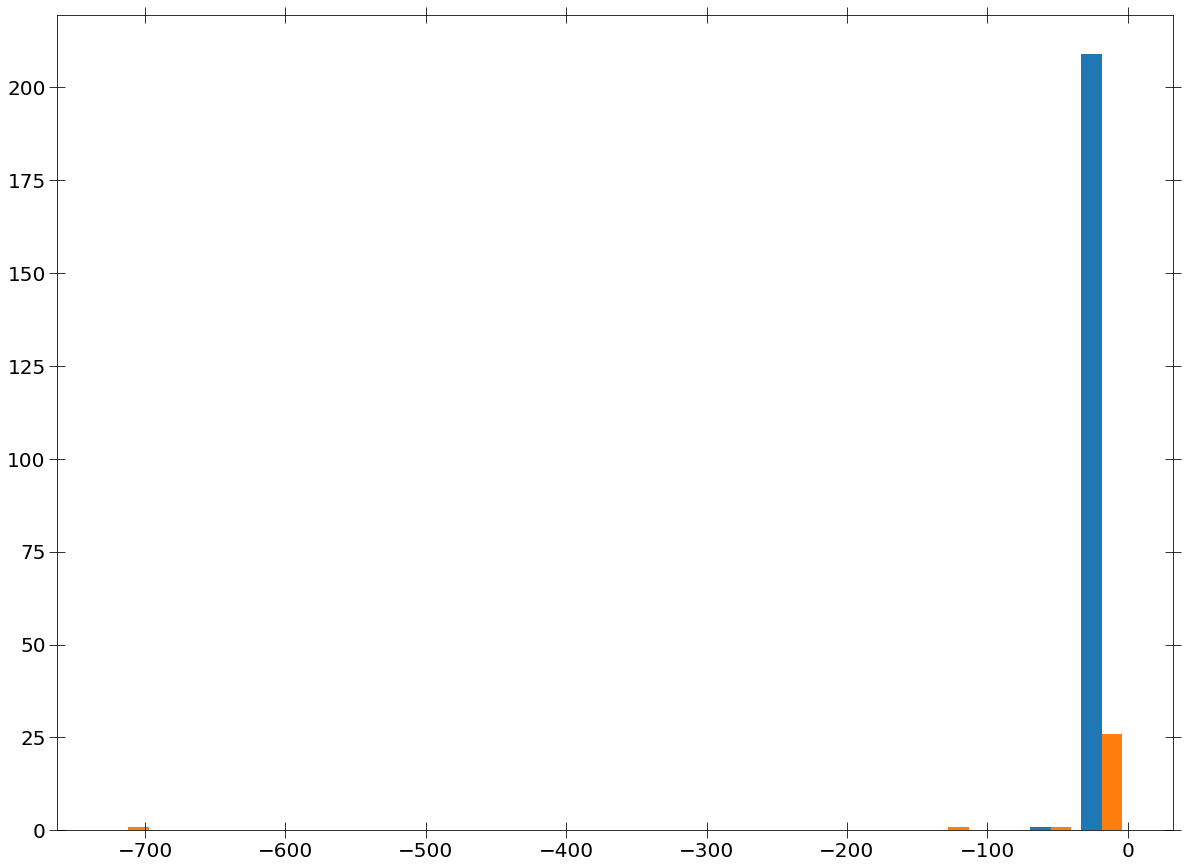

In [150]:
plt.hist([counts_3keV_sim_mos[counts_3keV_sim_mos < 0],
          counts_3keV_obs_mos[counts_3keV_obs_mos < 0]], bins=20)

In [165]:
np.sort(counts_2keV_obs_mos/netcounts_obs)[:10]

array([-0.42593468, -0.33020238, -0.32178032, -0.31756022, -0.317243  ,
       -0.2976317 , -0.26637052, -0.24287688, -0.24267083, -0.24171108])

In [163]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][np.argsort(counts_2keV_obs_mos/netcounts_obs)[:10]]

array(['206735502015094', '204024304010028', '206946410010097',
       '207848601010048', '206586001010103', '206735502010090',
       '206735502010070', '206746006015083', '206946410010058',
       '206586001010156'], dtype=object)

# PN files init: 853
# PN files init: 853


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:488: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:489: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:575: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:576: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


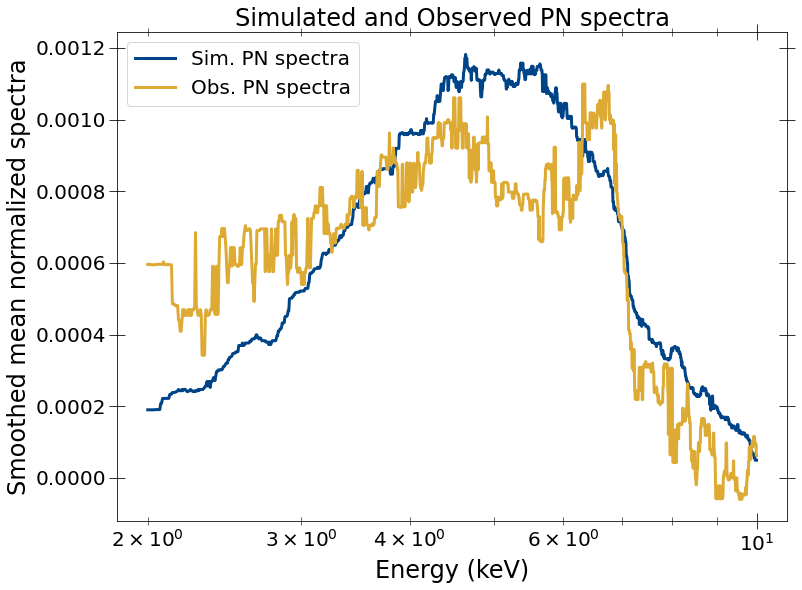

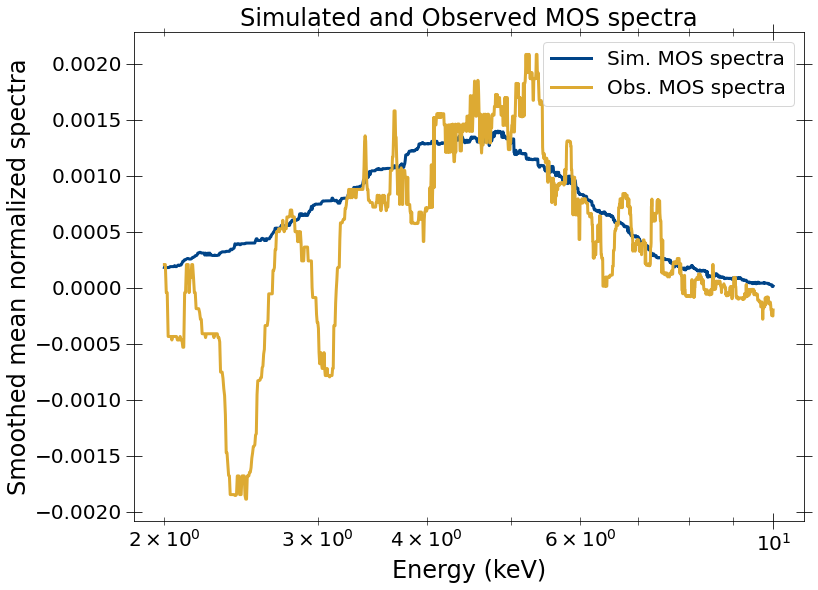

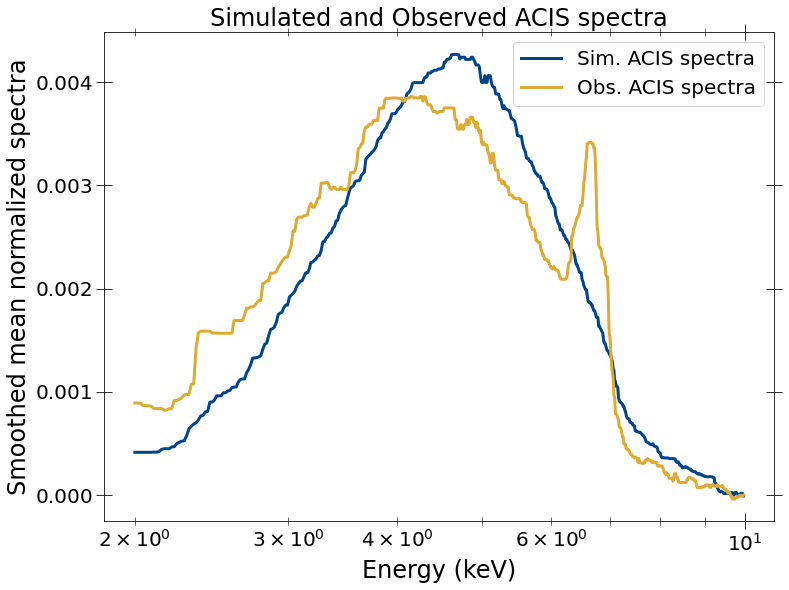

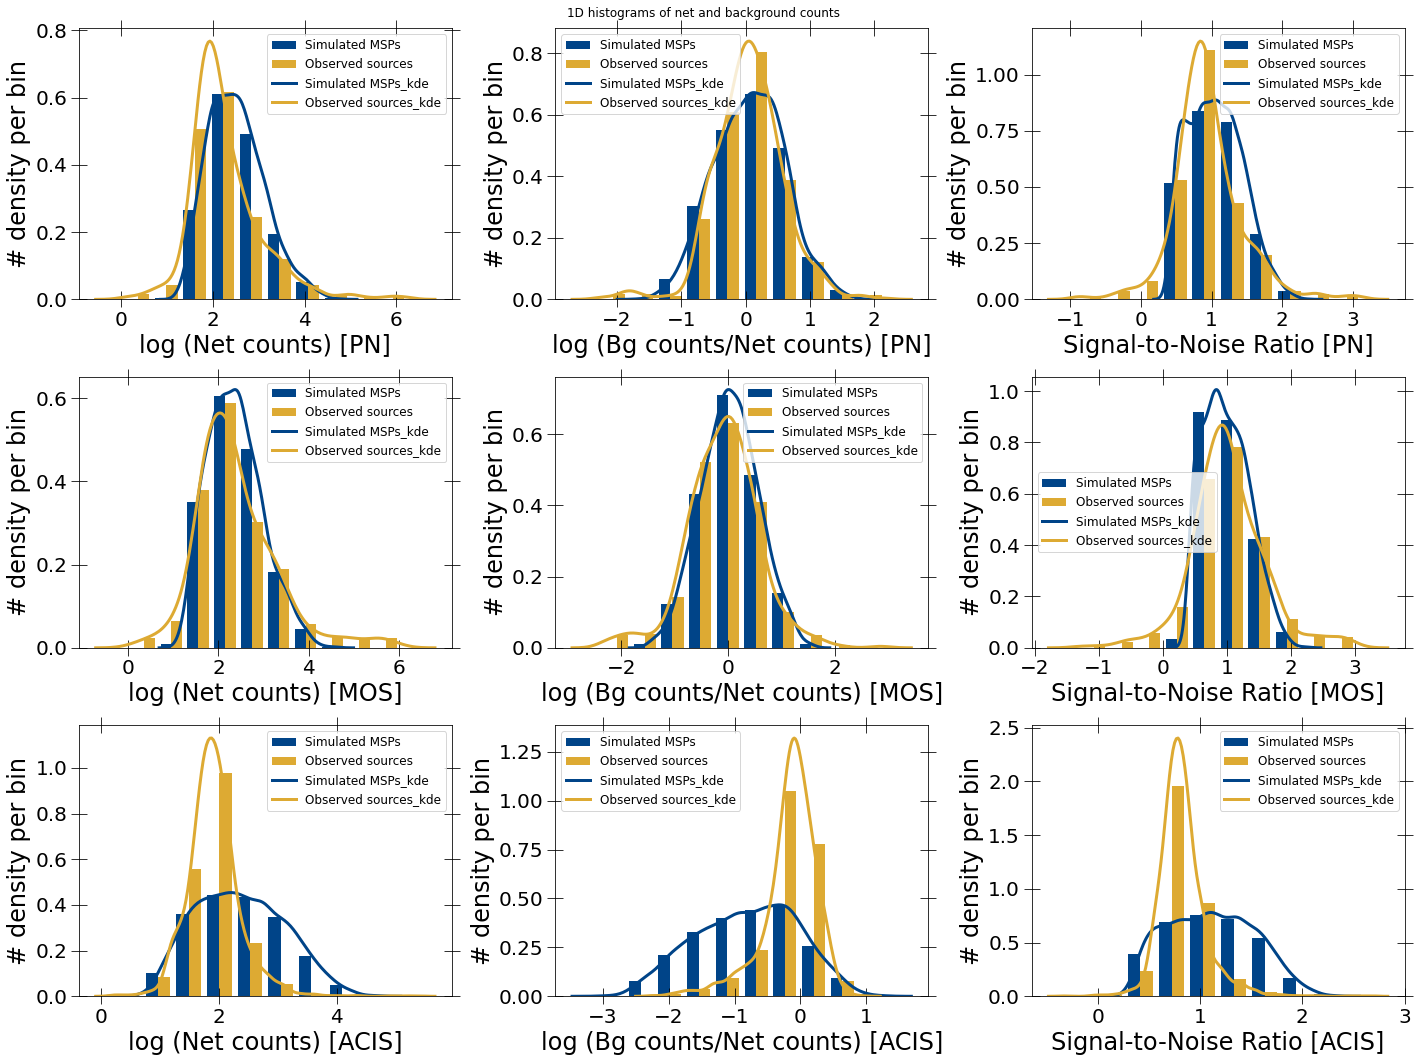

In [153]:
spec_summary_allobs = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

4488 4488 4488 4488
741 741 741 741


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
2358 2358 2358 2358
445 445 445 445


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
7337 7337 7337 7337
2670 2670 2670 2670


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0
16.0
16.0


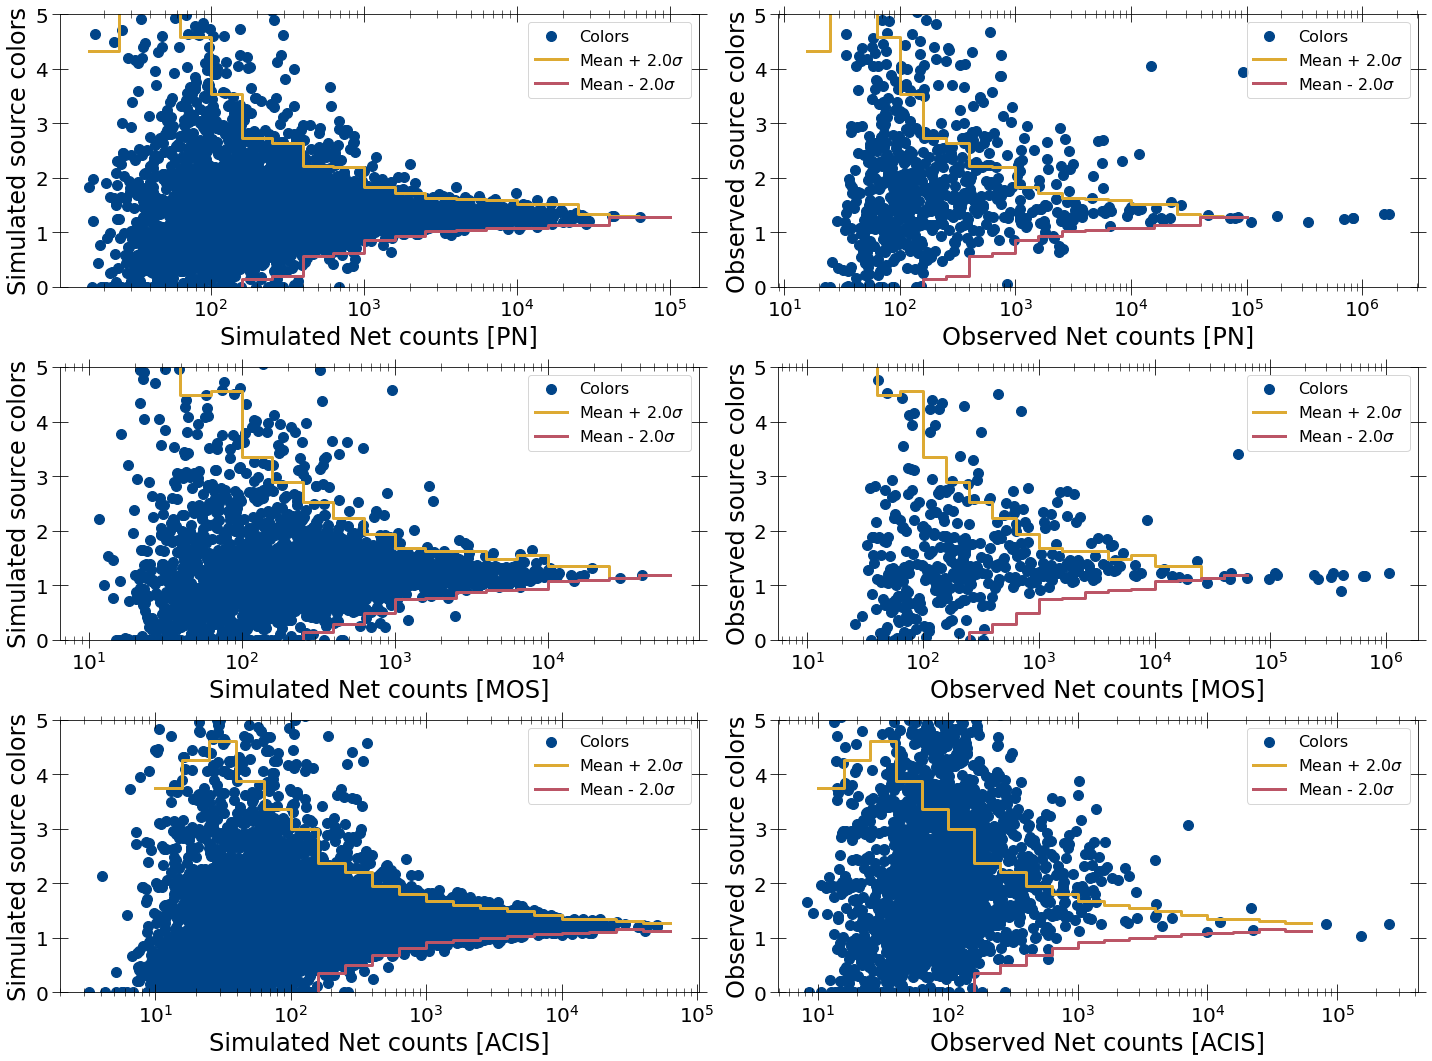

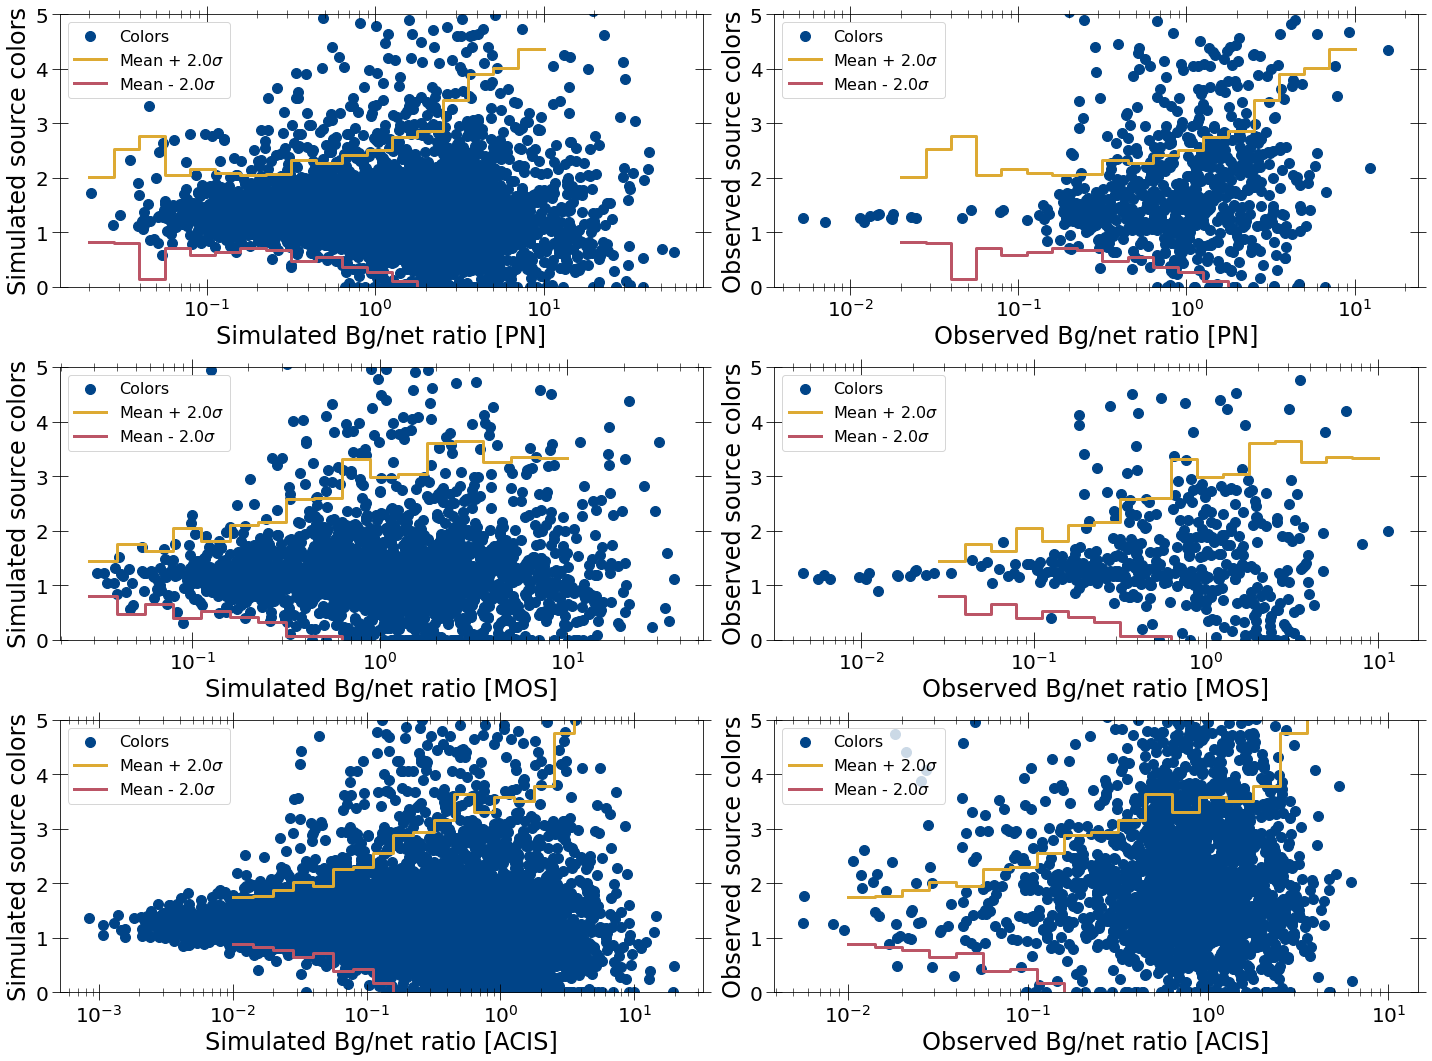

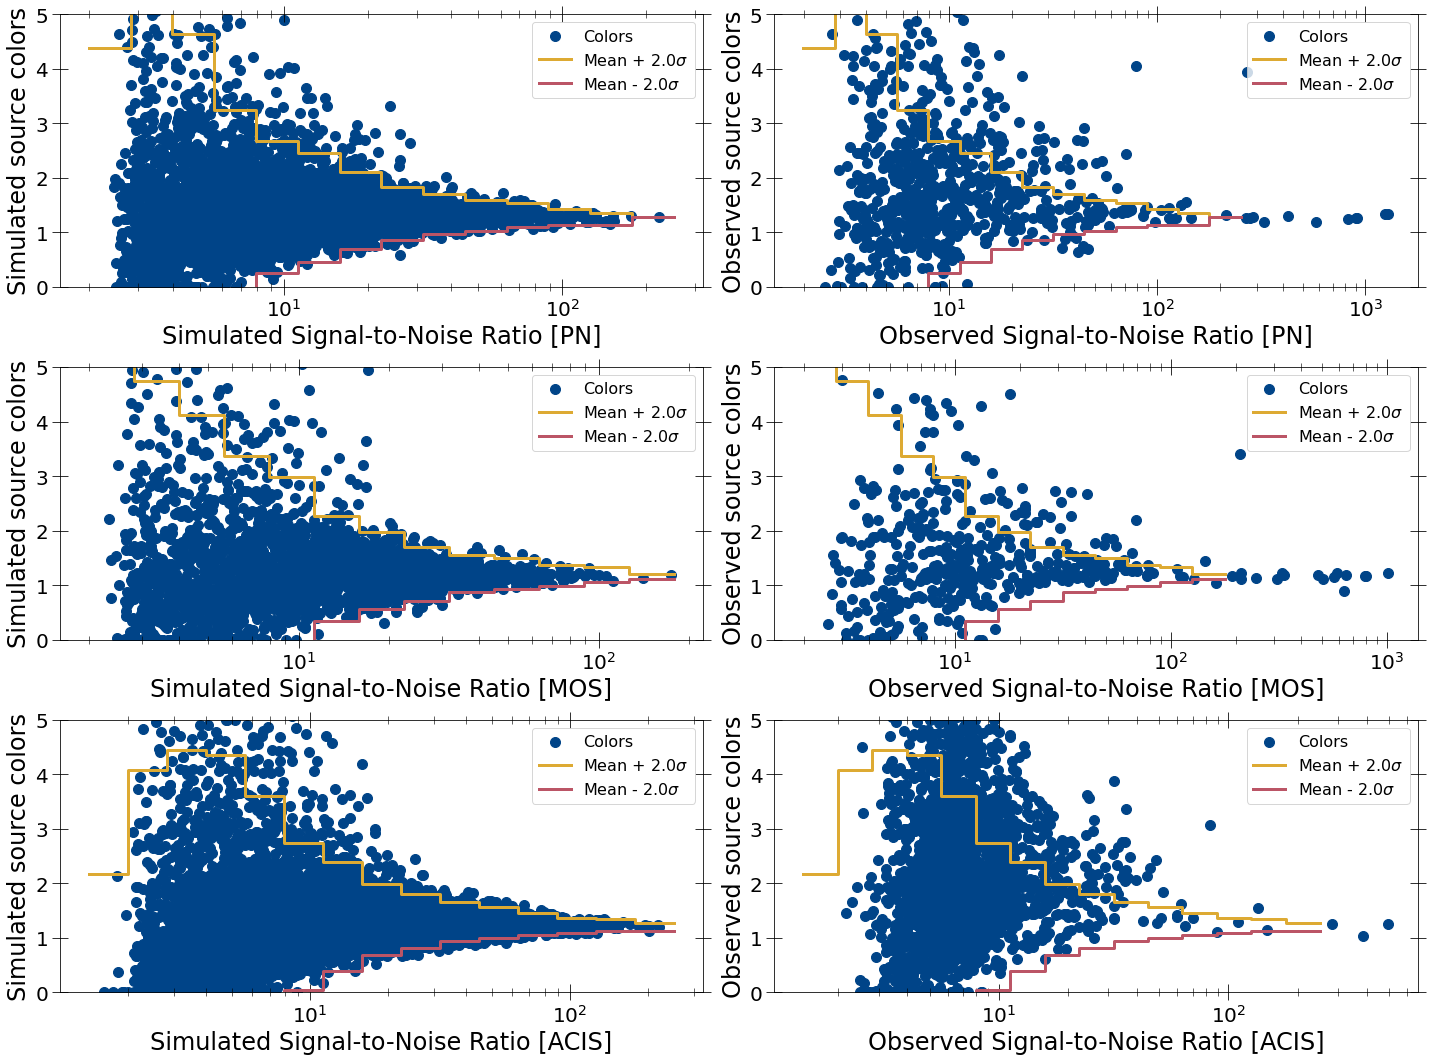

In [167]:
sim_color_dict_arr_clipped, obs_color_dict_arr_clipped = getcolor_prop_alldet(spec_summary, compare_det=True)

2772 2772 2772 2772
741 741 741 741
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


1937 1937 1937 1937
445 445 445 445
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
7873 7873 7873 7873
2670 2670 2670 2670


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0
16.0
16.0


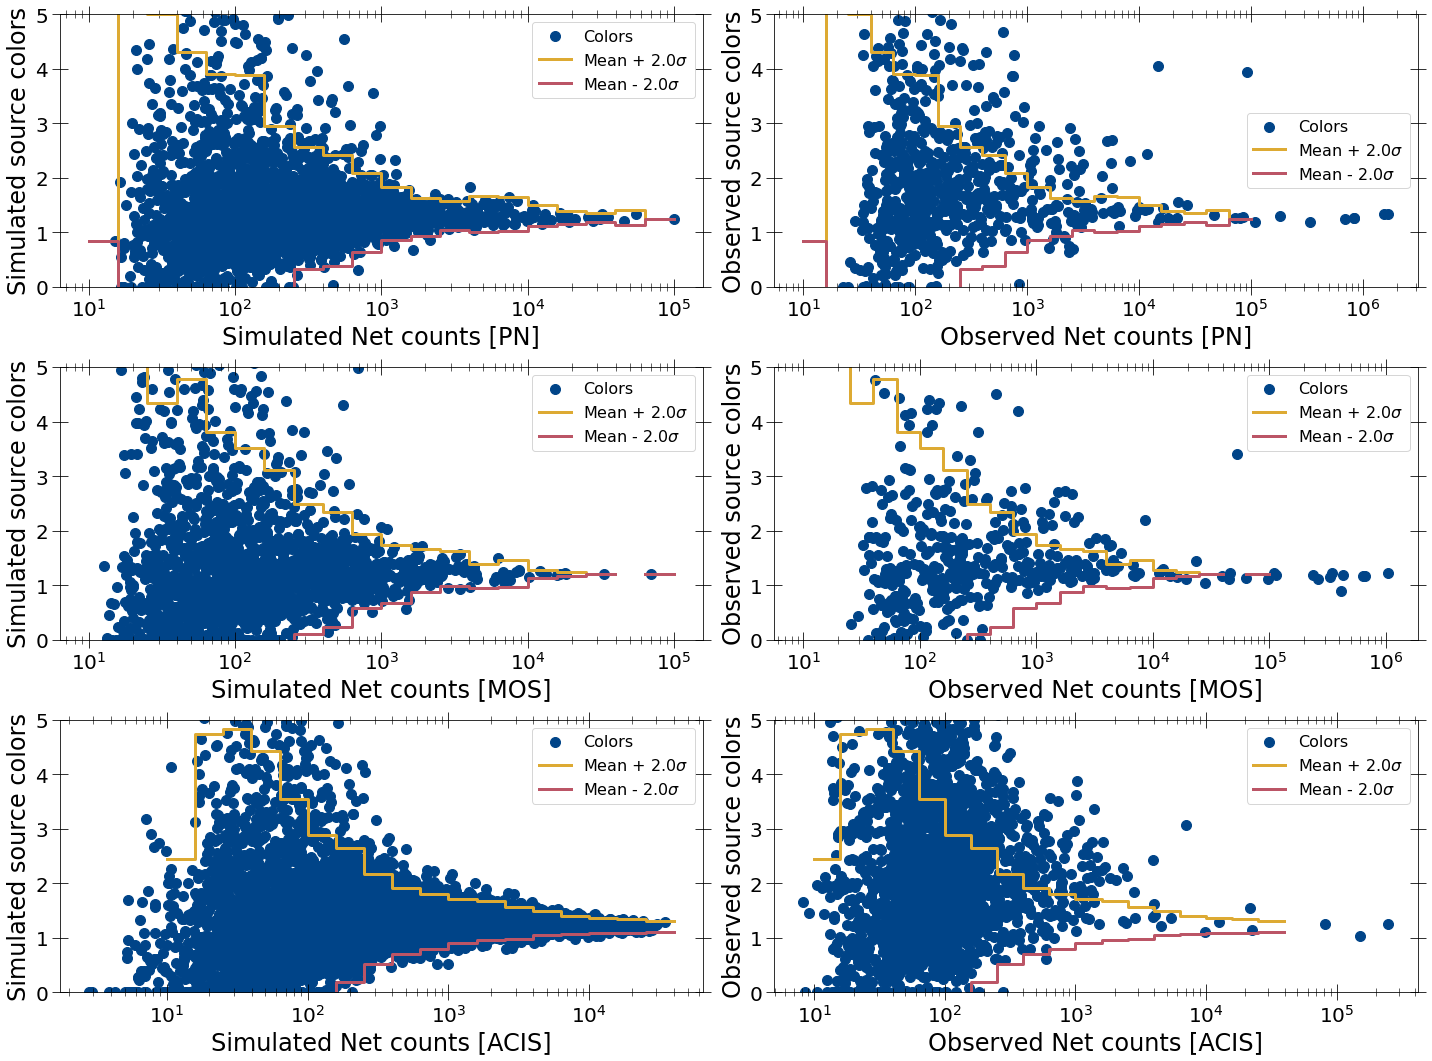

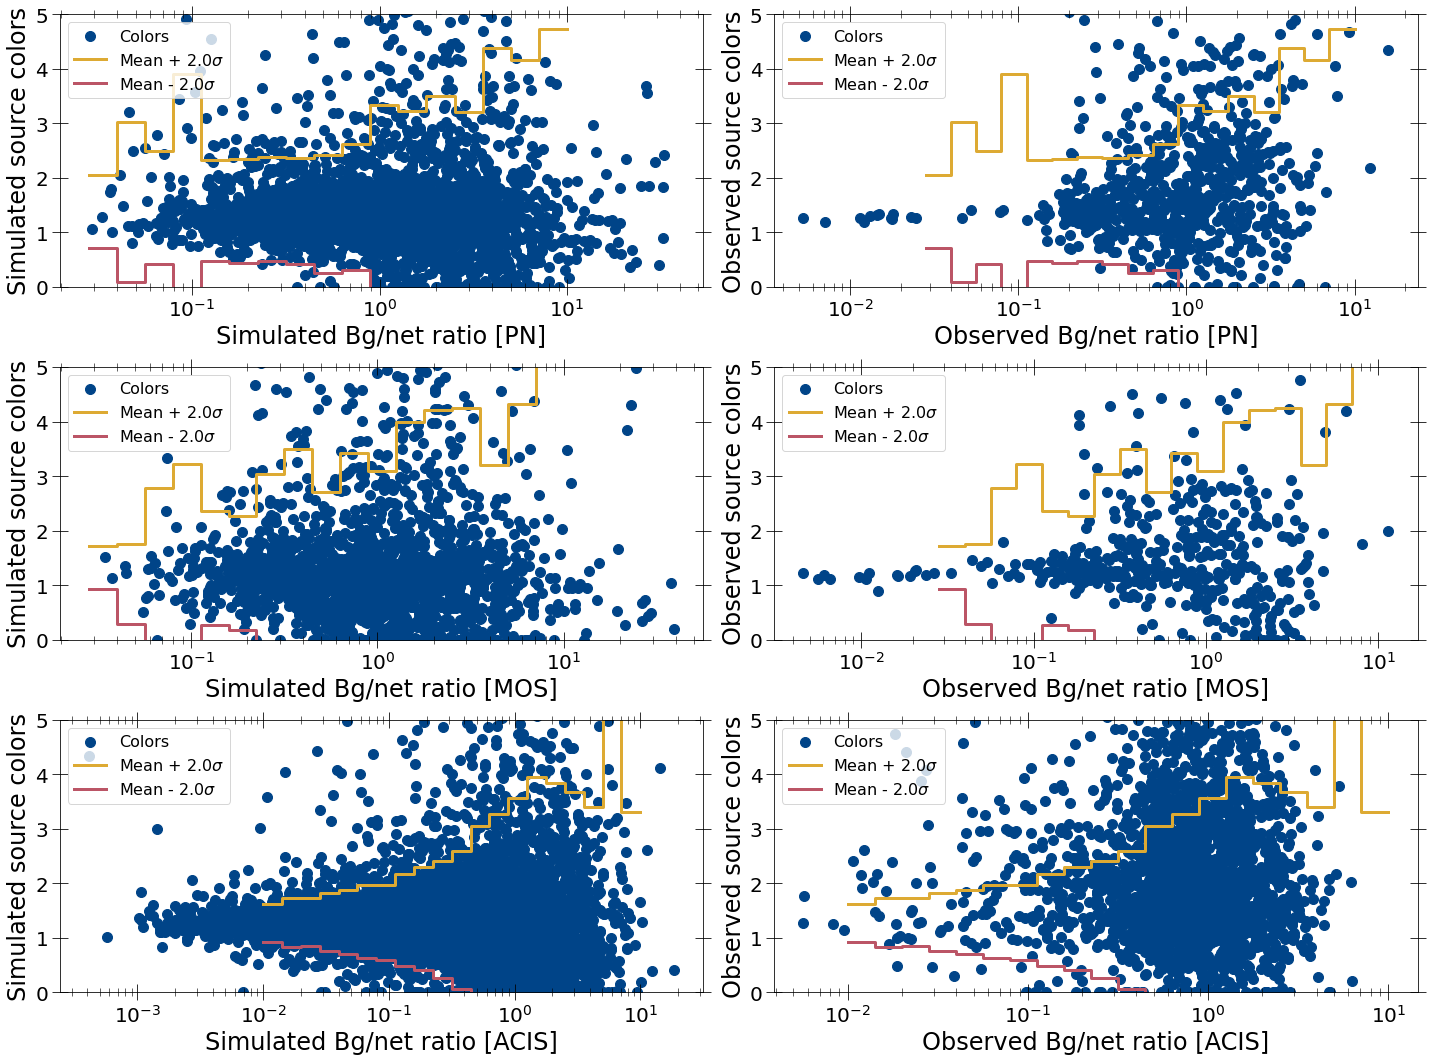

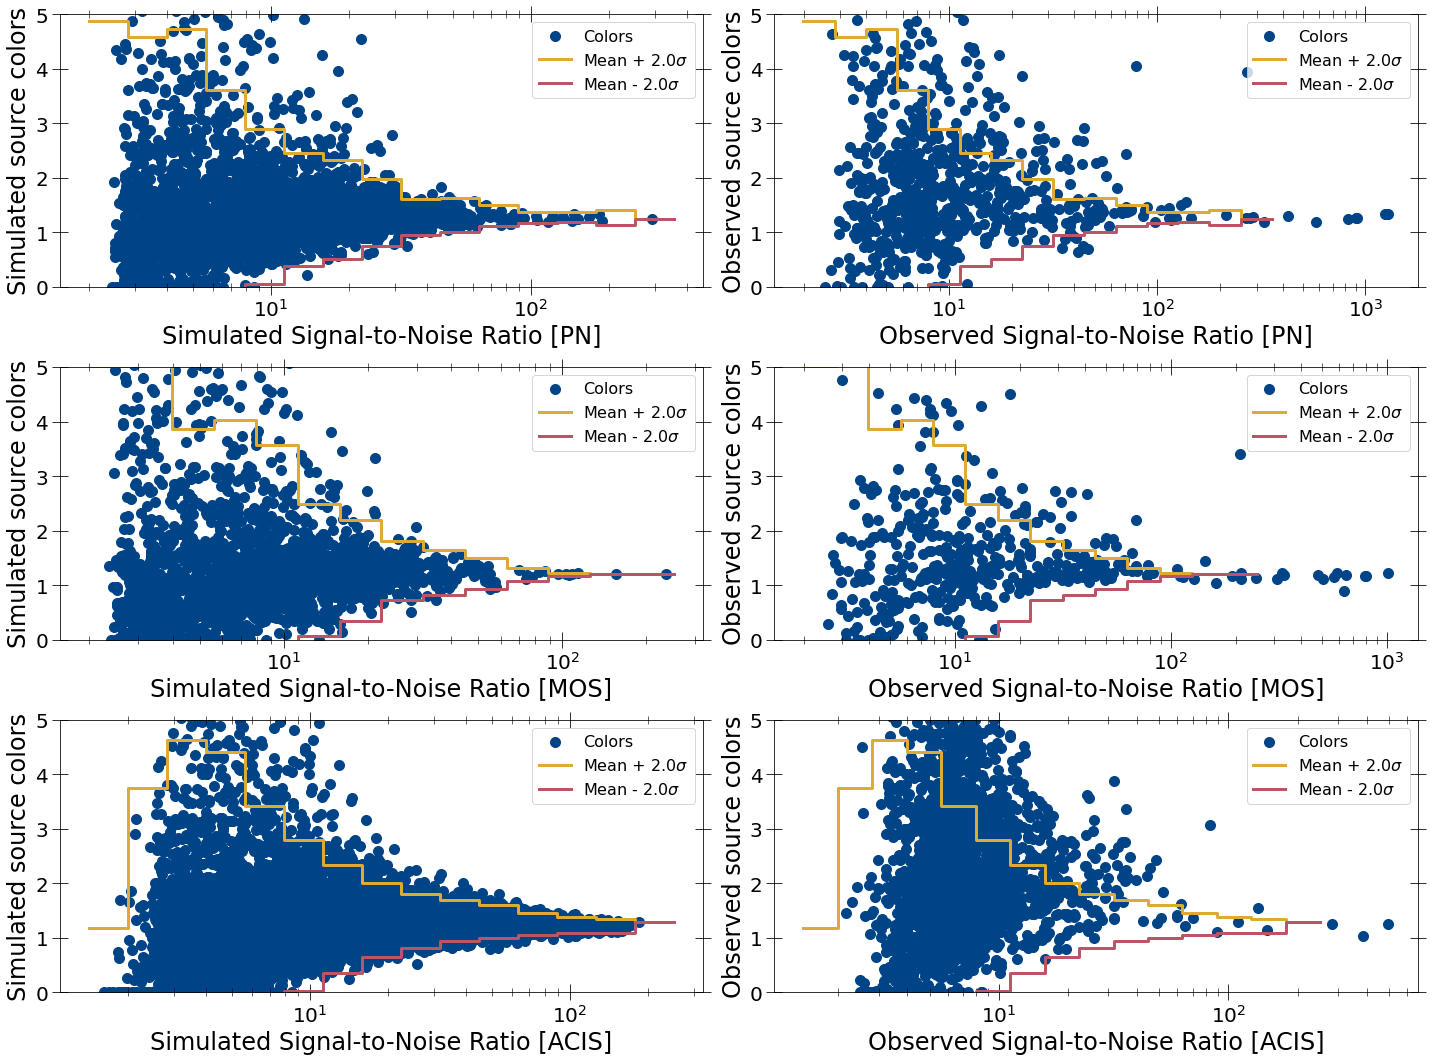

In [14]:
sim_color_dict_arr, obs_color_dict_arr = getcolor_prop_alldet(spec_summary, compare_det=True)

# PN files init: 853
# PN files init: 853


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:488: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:489: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:575: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:576: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


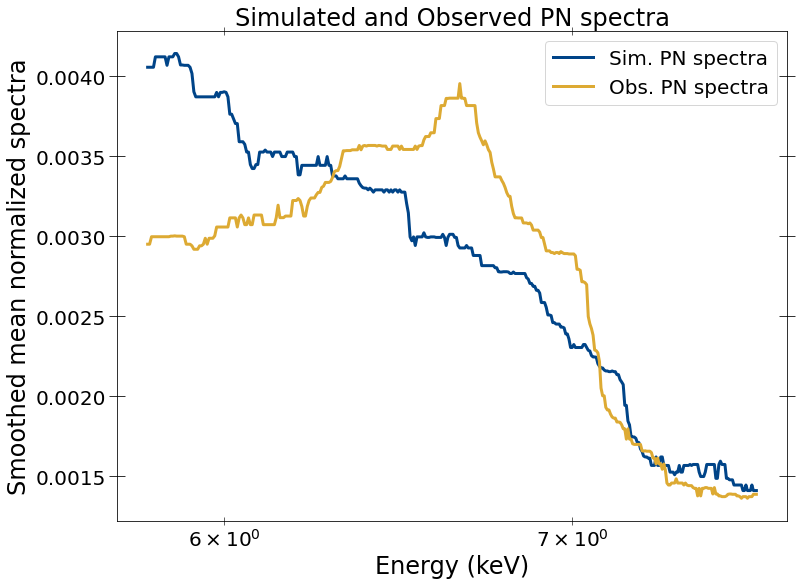

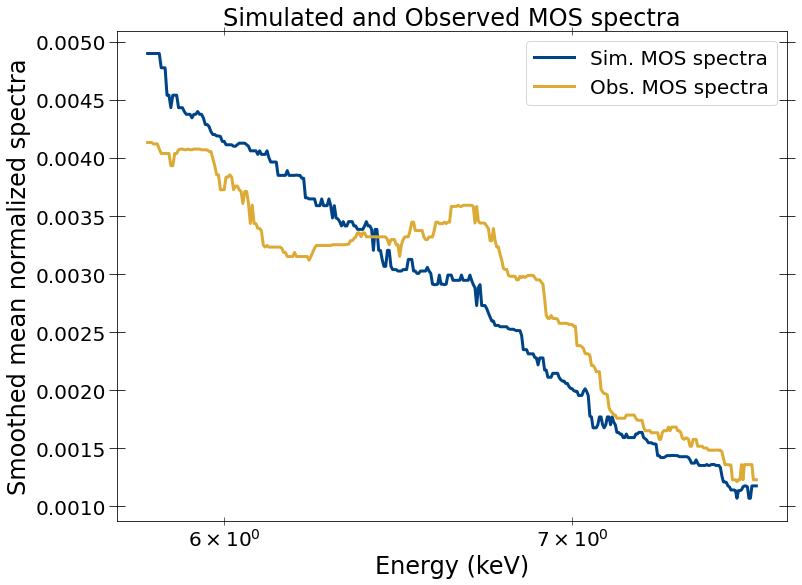

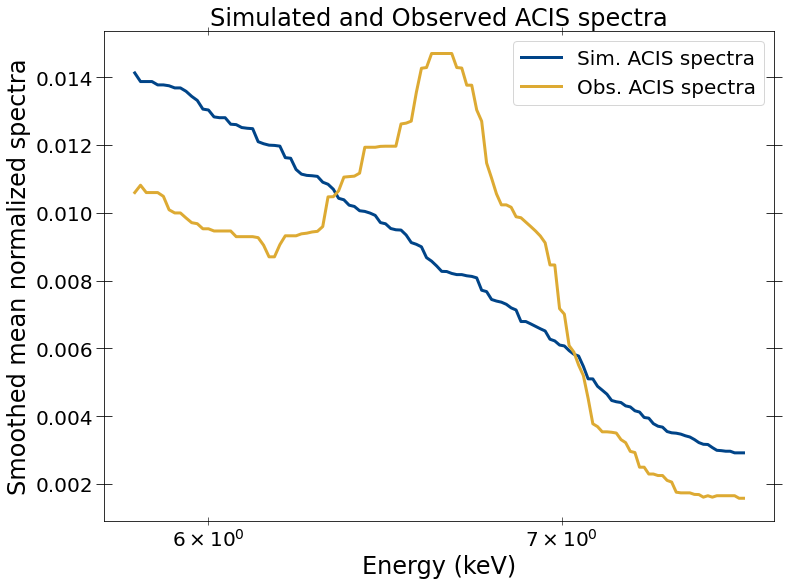

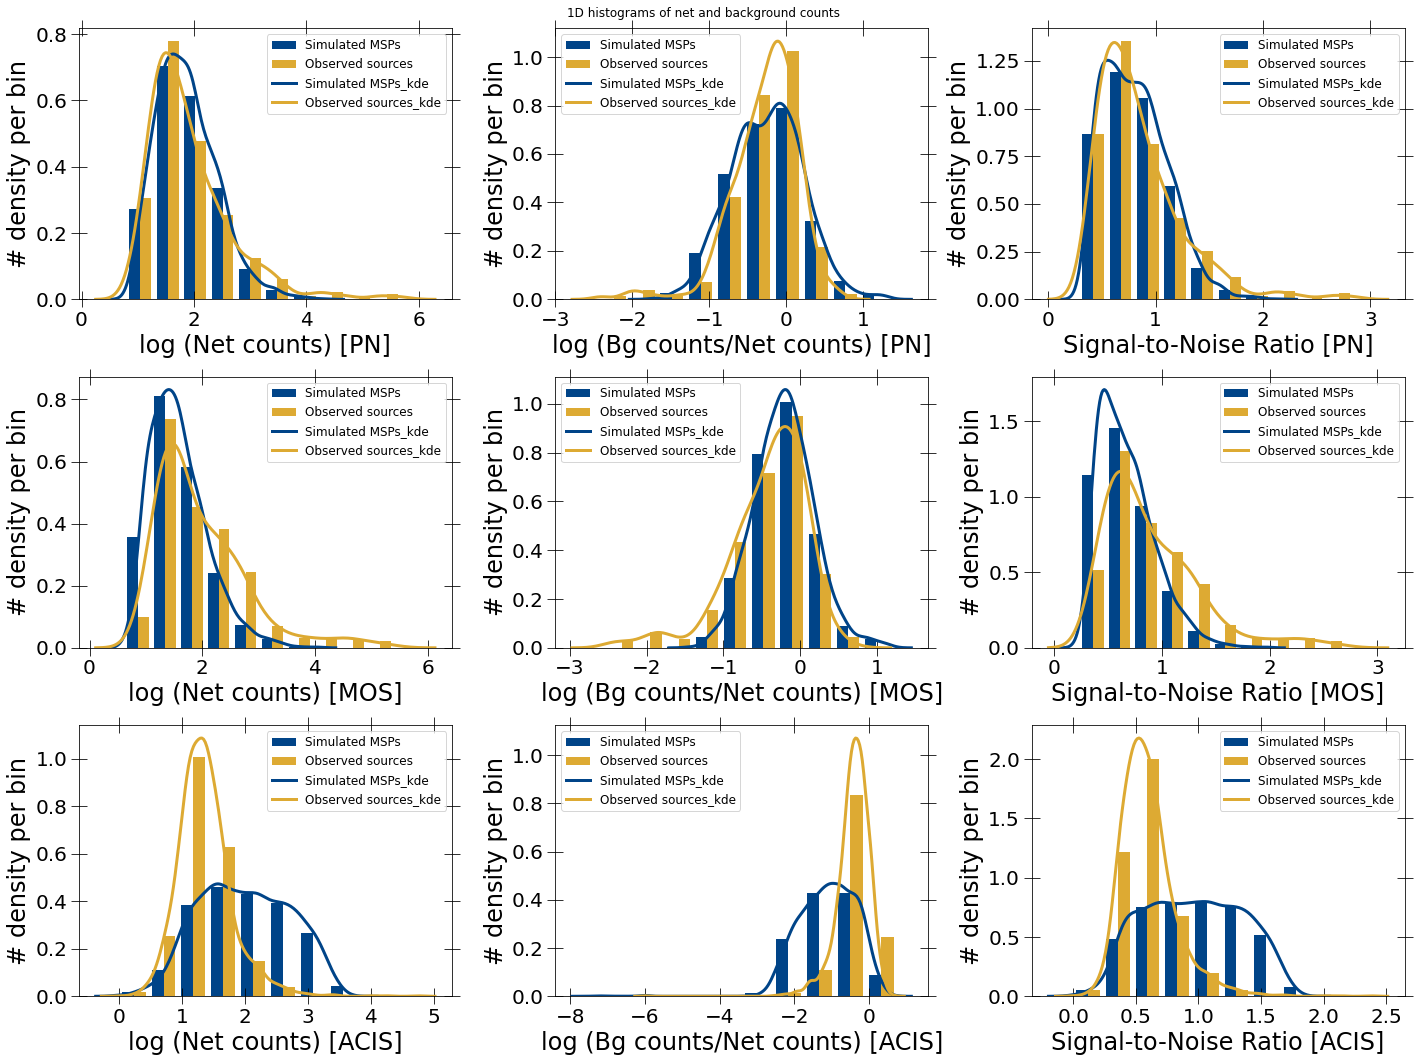

In [15]:
spec_summary2 = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[5.8, 7.6])

2355 2355 2355 2355
625 625 625 625


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
1406 1406 1406 1406
385 385 385 385


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
7063 7063 7063 7063
2235 2235 2235 2235
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide


16.0
16.0
16.0


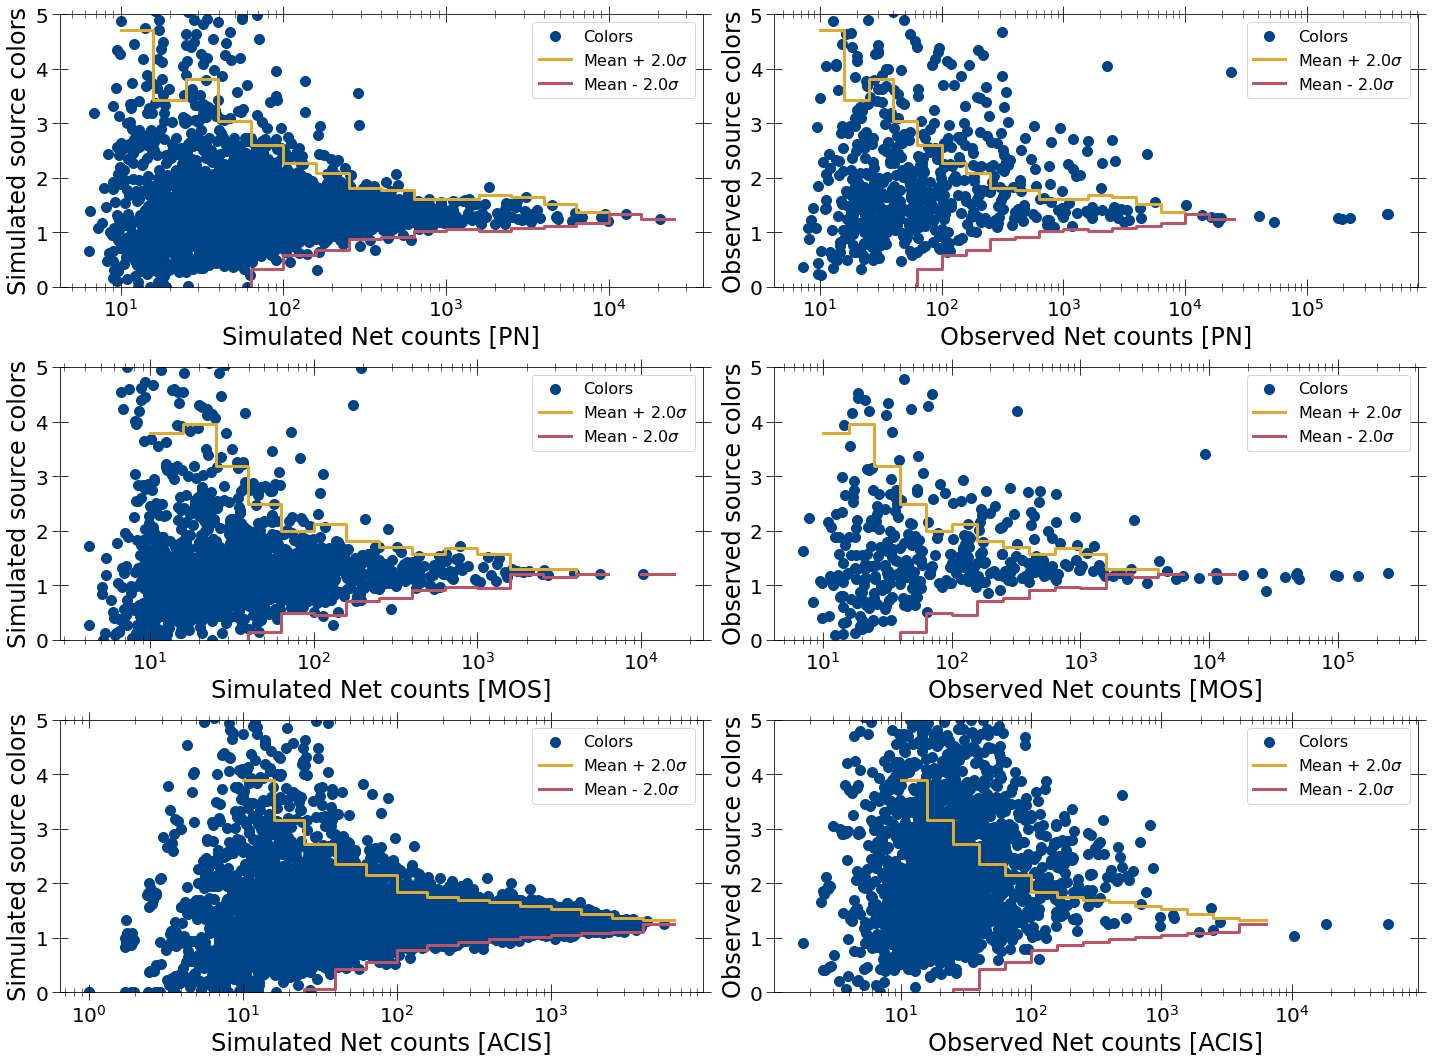

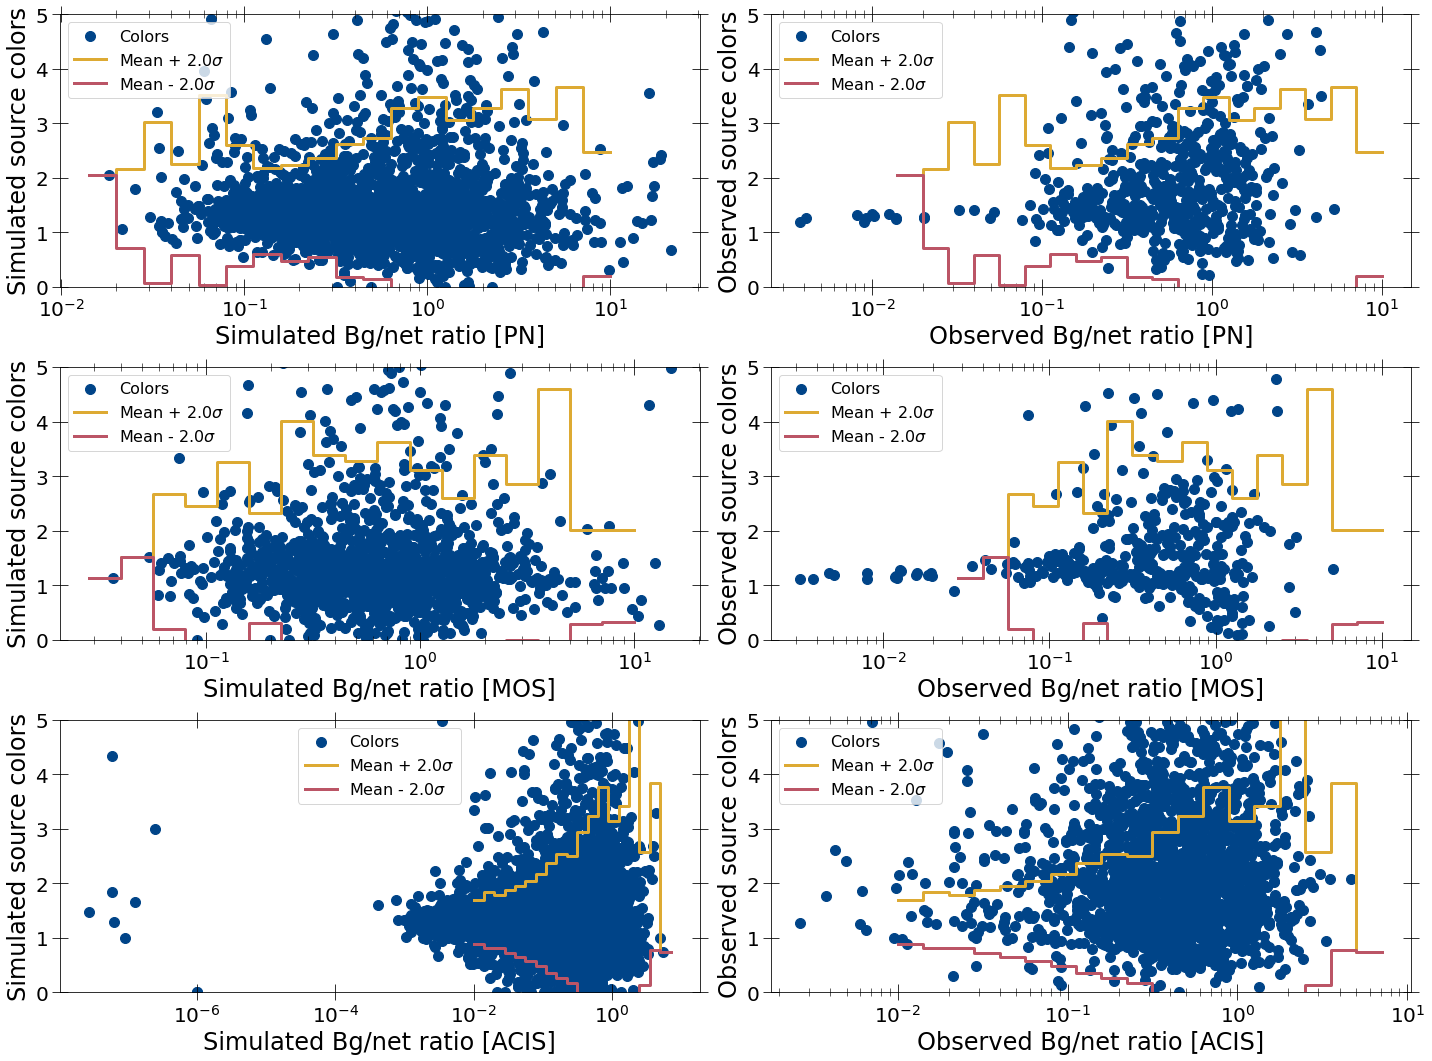

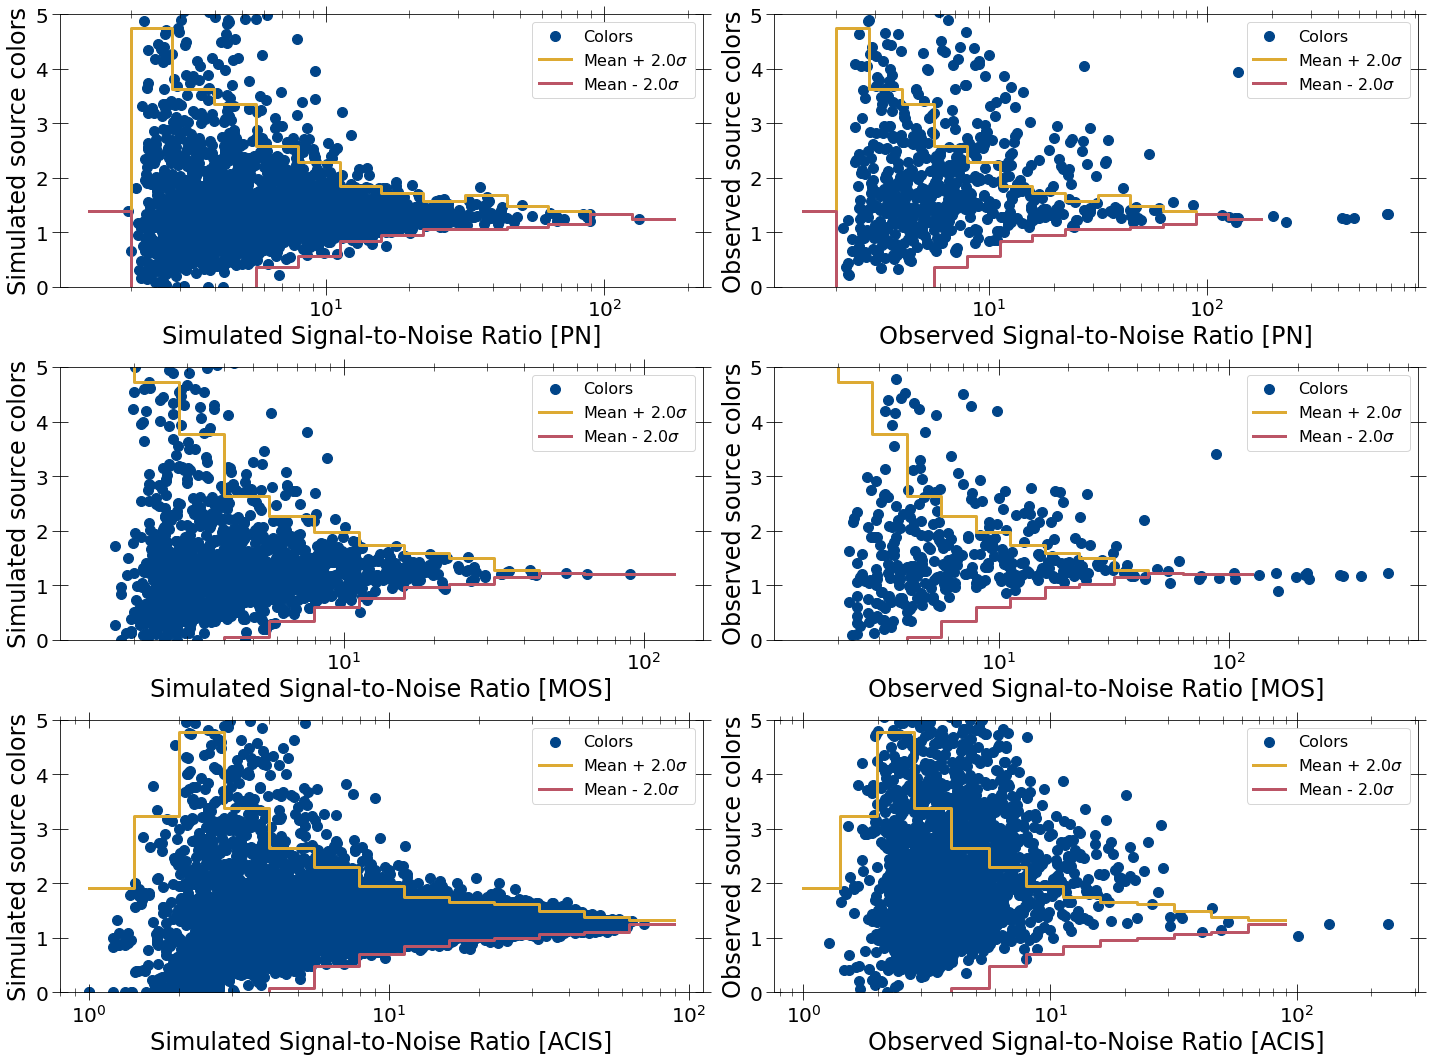

In [18]:
sim_color_dict_arr2, obs_color_dict_arr2 = getcolor_prop_alldet(spec_summary2, compare_det=True)

In [19]:
def get_candidate_src_nums_det(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    print(netcount_bins)
    print(color_median)
    print(color_std)
    interested_args = None
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        print(lower_bin, median_color + 2*std_color)
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(len(int_args))
        if interested_args is None:
            interested_args = int_args.copy()
        else:
            interested_args = np.append(interested_args.copy(), int_args)
    return interested_args, obs_src_nums[obs_det_mask][interested_args]


def get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


26:21: E117 over-indented
30:1: W293 blank line contains whitespace
59:80: E501 line too long (80 > 79 characters)
63:13: E122 continuation line missing indentation or outdented
64:13: E122 continuation line missing indentation or outdented


In [21]:
interested_args_alldet2, interested_srcs_alldet2 = get_candidate_src_nums_alldet(spec_summary2, sim_color_dict_arr2,
                              obs_color_dict_arr2, min_count_arr=[100, 100, 60])

[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[1.83545986 1.50859322 1.66084    1.48175529 1.46547481 1.42173222
 1.37907158 1.34241947 1.34164331 1.31932186 1.34112453 1.3576441
 1.36300675 1.31582893 1.27252105 1.33460737 1.24506393        nan
        nan        nan]
[1.44048382 0.95488145 1.07957089 0.78189889 0.56793735 0.42176062
 0.35496784 0.23084005 0.21274793 0.14517379 0.13894162 0.16628634
 0.13988764 0.09864256 0.04666147 0.         0.                nan
        nan        nan]
100.0 2.2652534668157647
28
158.48931924611142 2.08900725130583
23
251.18864315095823 1.8040995660264987
13
398.1071705534973 1.7671391723807393
11
630.957344480193 1.6096694382135777
10
1000.0 1.6190077715934166
7
1584.893192461

1:80: E501 line too long (116 > 79 characters)
2:31: E128 continuation line under-indented for visual indent


In [22]:
interested_args_alldet, interested_srcs_alldet = get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                              obs_color_dict_arr, min_count_arr=[380, 380, 220])

1:80: E501 line too long (112 > 79 characters)
2:31: E128 continuation line under-indented for visual indent


[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[0.8405164  2.07153913 1.67298979 1.57385831 1.58436607 1.66406679
 1.43030382 1.44713313 1.39609846 1.36984926 1.35086023 1.27893642
 1.31590127 1.33564778 1.334838   1.30071855 1.27144028 1.27383281
 1.26917868 1.24506393]
[0.         2.55426532 1.66817468 1.37071133 1.16334185 1.11434474
 0.75549623 0.56022382 0.51077116 0.36126324 0.24291962 0.17375792
 0.13254254 0.16428213 0.15864827 0.09633923 0.05725364 0.0421451
 0.0654287  0.        ]
398.1071705534973 2.4176407708782373
30
630.957344480193 2.0923757354927424
22
1000.0 1.8366994711223559
15
1584.893192461114 1.6264522674211288
18
2511.886431509582 1.5809863562739181
16
3981.0717055349733 1.6642120333782506
6
6

In [57]:
len(np.sort(interested_srcs_alldet[2]))

129

In [24]:
len(np.sort(interested_srcs_alldet2[2]))

100

In [25]:
def mark_interested_srcs(sim_color_dict, obs_color_dict, src_nums, obs_mask,
                         interested_srcs, prop_num=0):
    props = obs_color_dict['prop_list'][prop_num]
    colors = obs_color_dict['colors']
    interested_args = np.where(np.isin(src_nums[obs_mask], interested_srcs))
    print(interested_args)
    print(src_nums[obs_mask][interested_args])
    print(props[interested_args])
    print(colors[interested_args])
    prop_bins = sim_color_dict['prop_bins'][prop_num]
    mean_color = sim_color_dict['color_stat'][0][prop_num]
    std_color = sim_color_dict['color_stat'][2][prop_num]
    plotline_scatter([props, props[interested_args], prop_bins, prop_bins],
                     [colors, colors[interested_args], mean_color + 2*std_color,
                      mean_color - 2*std_color],
                     pl_types=['scatter', 'scatter', 'step', 'step'],
                     xlabel='Net counts', ylabel='Colors',
                     pl_labels=['Colors', 'Colors (candidates)',
                                r'Mean + 2$\sigma$', r'Mean + 2$\sigma$'],
                     ylim=(0, 5))

14:80: E501 line too long (80 > 79 characters)


In [23]:
np.where(spec_summary['src_nums'][0] == )

SyntaxError: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)

1:40: E202 whitespace before ')'
41: E999 SyntaxError: invalid syntax


Error before execution: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)


(array([  7,   8,  18,  22,  25,  32,  34,  40,  43,  46,  50,  65,  69,
        80,  81,  85,  87,  88,  92, 101, 102, 104, 106, 112, 129, 131,
       138, 139, 143, 145, 146, 149, 151, 154, 155, 157, 158, 164, 168,
       178, 180, 181, 183, 195, 229, 236, 241, 242, 264, 273, 278, 279,
       280, 282, 283, 302, 305, 318, 319, 320, 323, 324, 344, 345, 359,
       389, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 457, 458,
       459, 460, 463, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
       475, 476, 479, 481, 482, 487, 490, 513, 534, 535, 536, 537, 538,
       539, 540, 541, 542, 543, 544, 545, 547, 550, 551, 568, 586, 603,
       628, 629, 671, 672, 681, 695, 737]),)
['201032613010001' '201032613010002' '201113501015161' '201129701010015'
 '201129701010027' '201129702010002' '201129702010014' '201129702010049'
 '201129704010010' '201129704010019' '201129704010027' '201129705010011'
 '201129705010038' '201129706010014' '201129707010002' '201129707010012'
 '201129707010

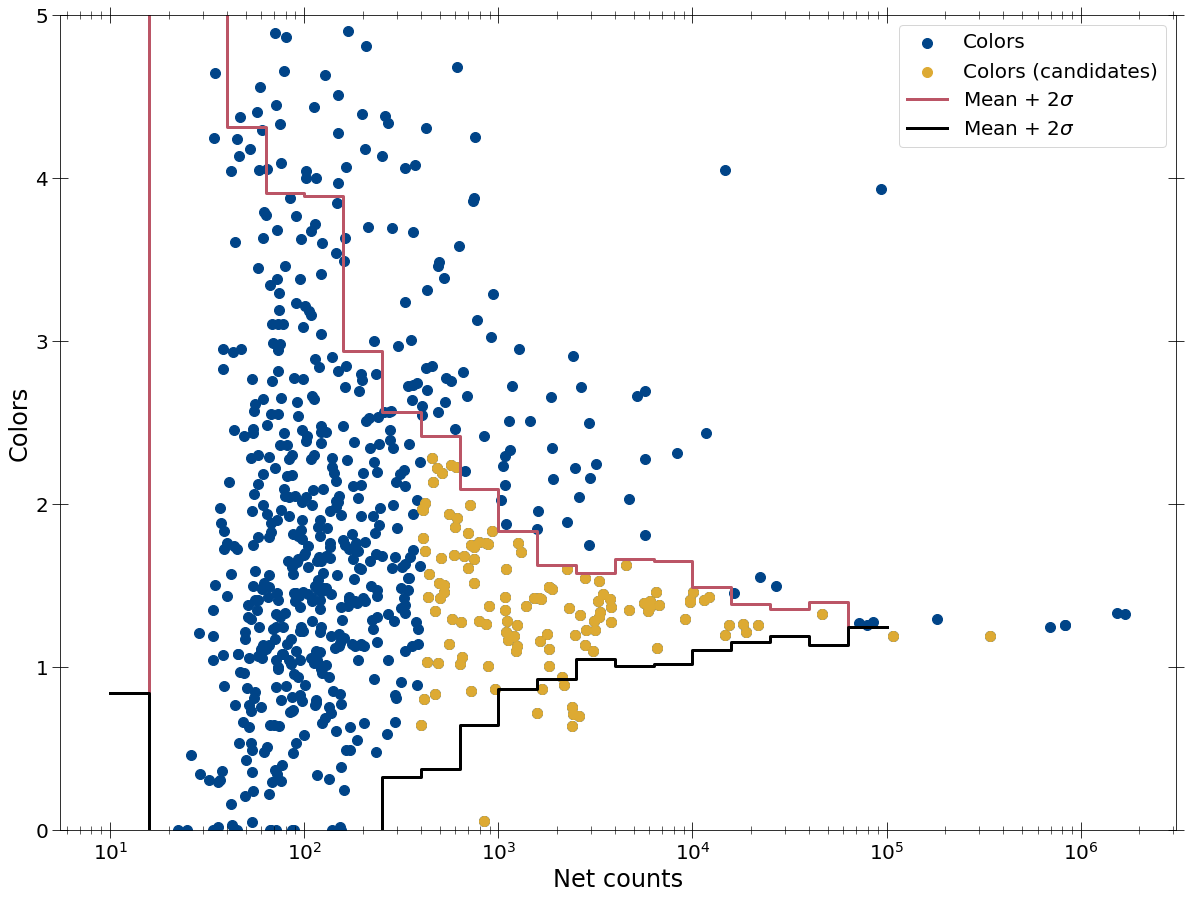

2:80: E501 line too long (83 > 79 characters)


In [53]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     interested_srcs_alldet[0], 0)

(array([  3,   4,  10,  11,  20,  31,  40,  46,  47,  48,  50,  59,  61,
        65,  69,  72,  79,  82,  87,  94,  97,  99, 102, 105, 107, 109,
       110, 115, 118, 123, 129, 138, 139, 149, 156, 159, 160, 163, 168,
       178, 179, 180, 186, 201, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 212, 213, 214, 216, 218, 224, 226, 228, 236, 251, 252, 256,
       259, 260, 270, 273, 276, 279, 280, 284, 286, 287, 295, 296, 298,
       309, 313, 315, 320, 379, 380, 381, 395, 396, 397, 398, 399, 401,
       402, 403, 404, 405, 406, 408, 409, 410, 411, 412, 413, 414, 415,
       416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 442,
       443, 444]),)
['201032613010001' '201032613010002' '201113503010004' '201113503010008'
 '201129702010002' '201129704010011' '201129704010040' '201129705010002'
 '201129705010011' '201129705010014' '201129705010038' '201129706010014'
 '201129707010006' '201129707010015' '201129707010045' '201129707010063'
 '201129708010036' '201129709010001' '2

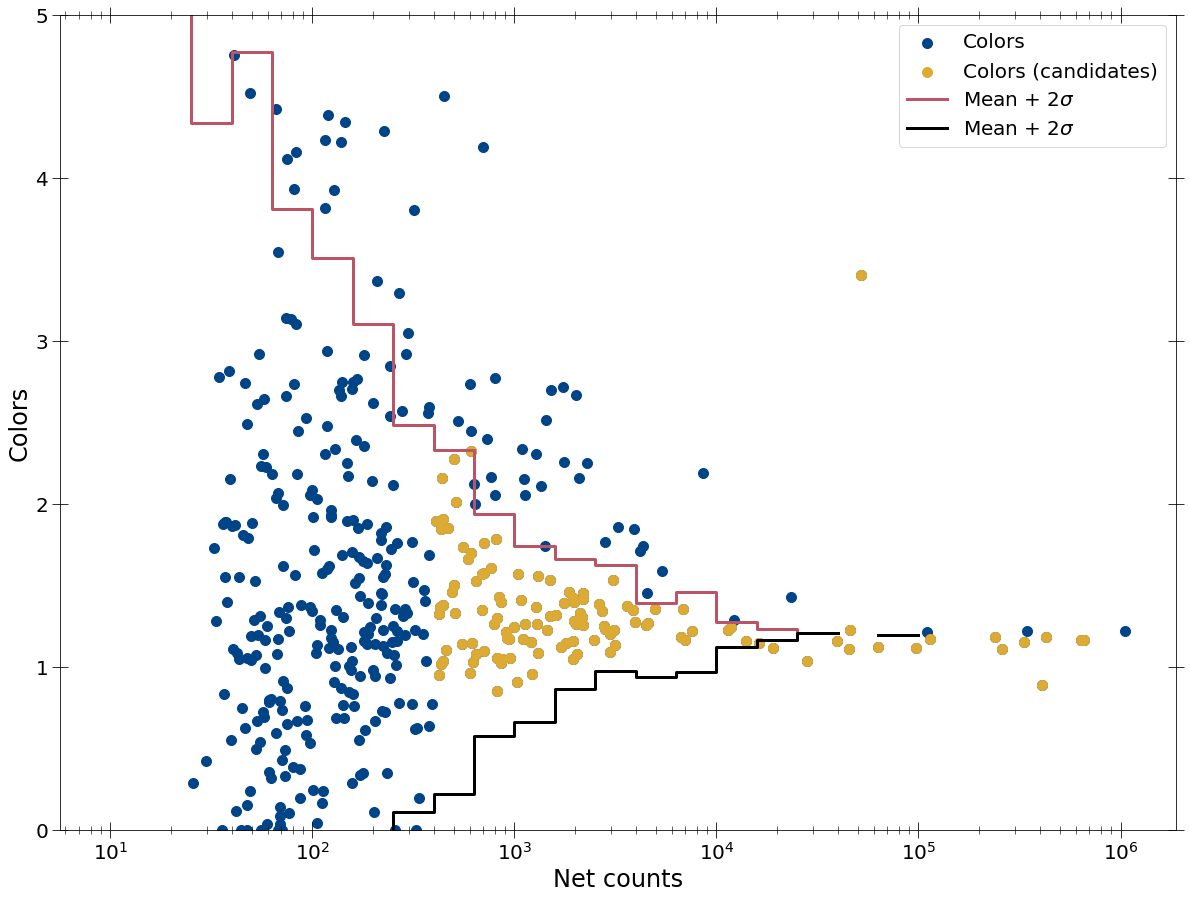

2:80: E501 line too long (83 > 79 characters)


In [58]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     interested_srcs_alldet[1], 0)

In [64]:
len(interested_srcs_alldet[0])

124

(array([  90,  130,  163,  165,  178,  182,  223,  233,  246,  271,  296,
        298,  303,  349,  366,  389,  402,  643,  669,  714,  766,  806,
        895,  907, 1001, 1004, 1053, 1073, 1075, 1187, 1192, 1193, 1200,
       1222, 1248, 1251, 1279, 1329, 1339, 1345, 1350, 1362, 1375, 1381,
       1390, 1408, 1418, 1419, 1420, 1459, 1474, 1489, 1499, 1500, 1525,
       1527, 1528, 1537, 1541, 1544, 1553, 1555, 1562, 1563, 1573, 1575,
       1582, 1586, 1602, 1612, 1618, 1649, 1659, 1666, 1672, 1703, 1705,
       1706, 1707, 1761, 1769, 1774, 1820, 1829, 1877, 1880, 1889, 1926,
       1927, 1949, 1993, 2004, 2012, 2050, 2089, 2210, 2225, 2246, 2260,
       2285, 2307, 2314, 2323, 2331, 2333, 2353, 2355, 2381, 2413, 2431,
       2440, 2456, 2458, 2465, 2467, 2475, 2480, 2492, 2503, 2510, 2522,
       2529, 2536, 2543, 2568, 2570, 2603, 2607, 2610]),)
['2CXOJ174433.0-284426' '2CXOJ174454.1-285841' '2CXOJ174502.3-285449'
 '2CXOJ174503.8-290051' '2CXOJ174508.6-285652' '2CXOJ174508.7-290325

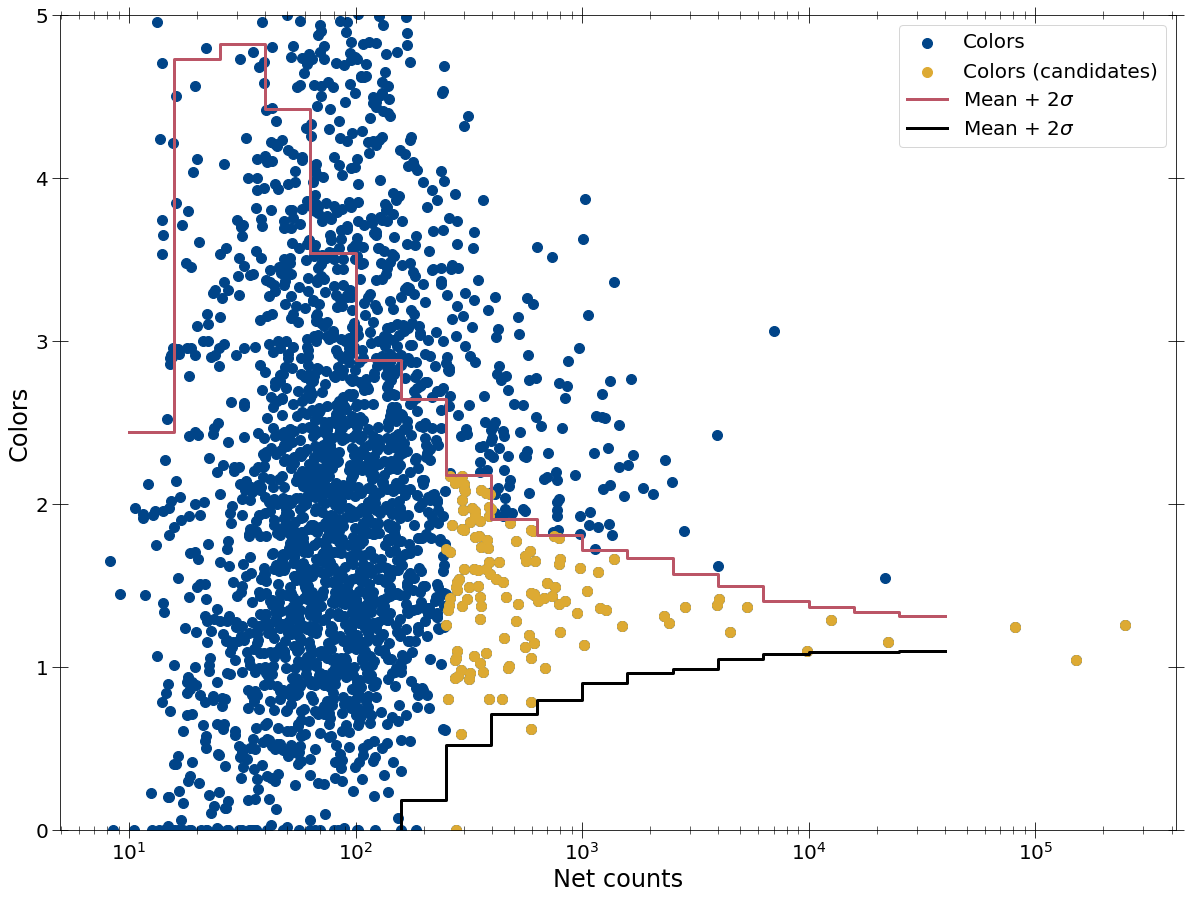

2:80: E501 line too long (83 > 79 characters)


In [84]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     interested_srcs_alldet[2], 0)

In [28]:
source_nums = np.loadtxt('Interested_sources.txt', dtype='object')

(array([ 24,  38,  43,  50,  75,  91,  98, 111, 121, 127, 140, 152, 187,
       191, 192, 195, 206, 211, 213, 223, 229, 240, 273, 308, 309, 311,
       441, 464, 465, 467, 481, 483]),)


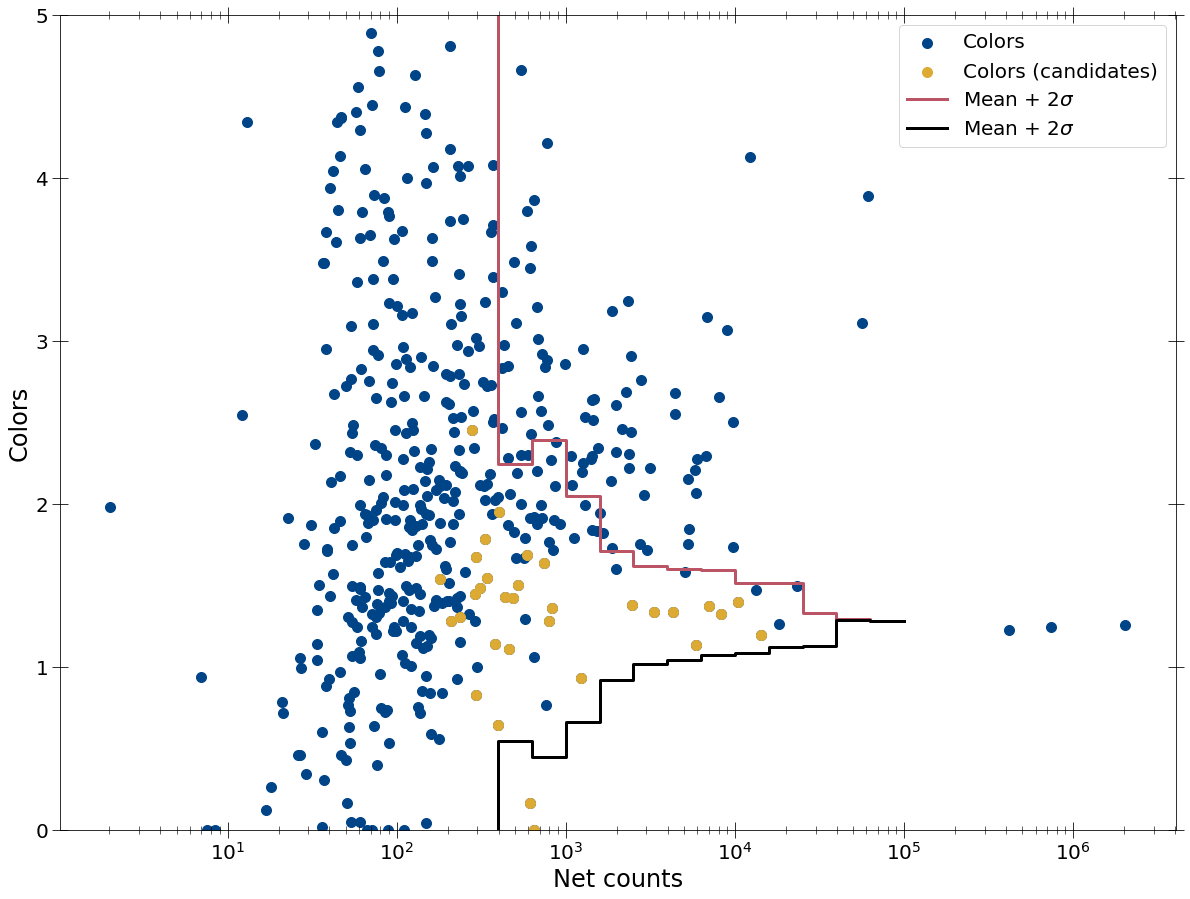

2:80: E501 line too long (83 > 79 characters)


In [29]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     source_nums, 0)

(array([ 16,  24,  29,  33,  55,  66,  72,  84,  93,  97, 103, 119, 122,
       123, 125, 134, 137, 139, 157, 171, 183, 184, 185, 220, 224, 225,
       226, 229, 231]),)


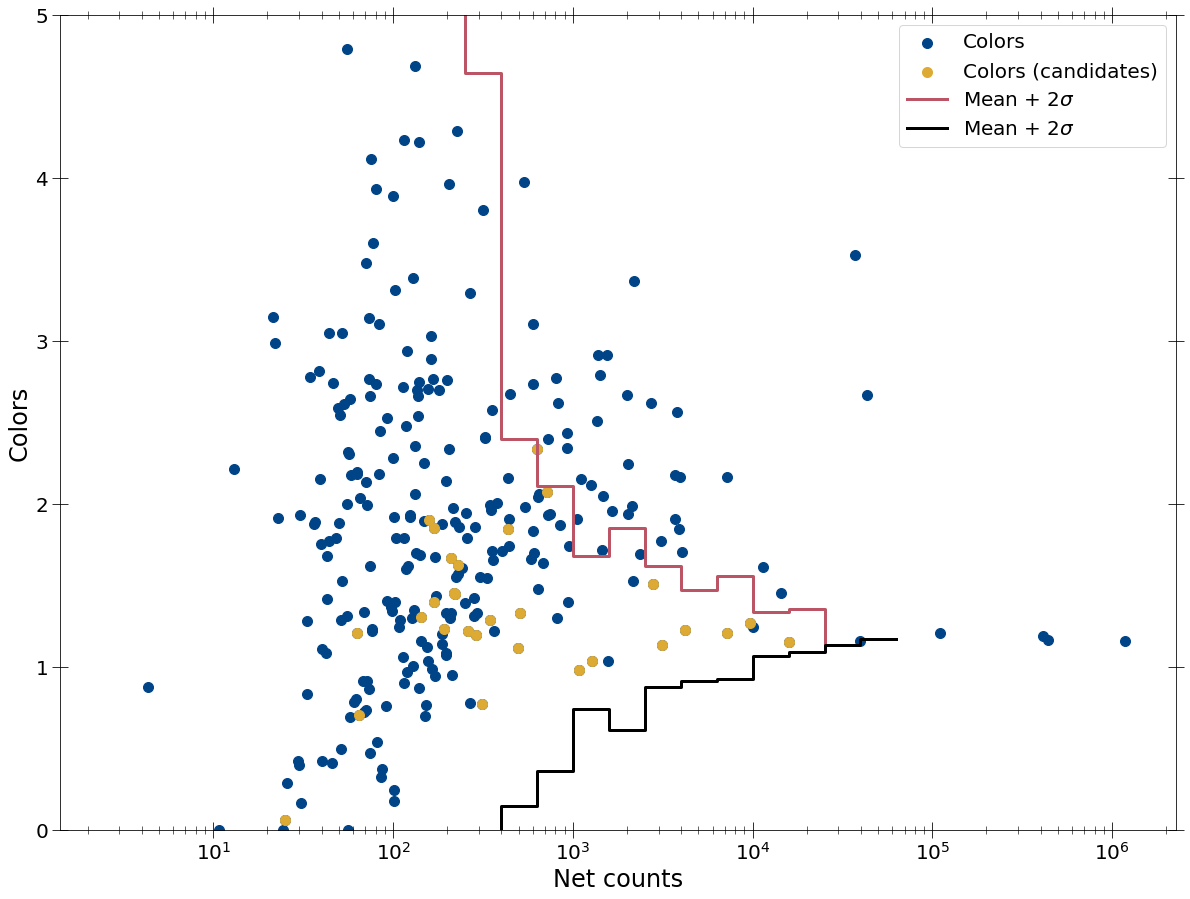

2:80: E501 line too long (83 > 79 characters)


In [30]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     source_nums, 0)

# Checking for low norm sources

## def unmask_arr(masked_values, mask, filler=-100.0):
    unmasked_arr = np.ones(len(mask), dtype=float)*filler
    unmasked_arr[mask] = masked_values
    return unmasked_arr

In [23]:
print('MOS sources not detected in PN')
mos_not_pn = []
for src in interested_srcs_alldet[1]:
    if src not in interested_srcs_alldet[0]:
        mos_not_pn.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

MOS sources not detected in PN
Source:  201129705010014
Net counts (PN):  [1984.88629568]
Net counts (MOS):  [608.05064636]
Bg counts (PN):  [2078.11370432]
Bg counts (MOS):  [524.94935364]


IndexError: list index out of range

14:80: E501 line too long (113 > 79 characters)


In [395]:
print('PN sources not detected in MOS')
pn_not_mos = []
for src in interested_srcs_alldet[0]:
    if src not in interested_srcs_alldet[1]:
        pn_not_mos.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

PN sources not detected in MOS
Source:  201113501010066
Net counts (PN):  [569.59489915]
Net counts (MOS):  [77.06422098]
Bg counts (PN):  [1054.40510085]
Bg counts (MOS):  [132.93577902]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.67109356]
Color (MOS):  [3.60388168]
Source:  201113501010154
Net counts (PN):  [404.91355624]
Net counts (MOS):  [169.29402981]
Bg counts (PN):  [769.08644376]
Bg counts (MOS):  [251.70597019]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.95526699]
Color (MOS):  [1.4032798]
Source:  201129701010015
Net counts (PN):  [452.26180445]
Net counts (MOS):  [80.75597502]
Bg counts (PN):  [476.73819555]
Bg counts (MOS):  [149.24402498]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.87554681]
Color (MOS):  [2.73833179]
Source:  201129704010011
Net counts (PN):  [465.79990524]
Net counts (MOS):  [287.22584027]
Bg counts (PN):  [836.20009476]
Bg counts (MOS):  [147.77415973]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [2.0655

14:80: E501 line too long (113 > 79 characters)


In [396]:
len(mos_not_pn)

18

In [397]:
len(pn_not_mos)

37

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

8.0


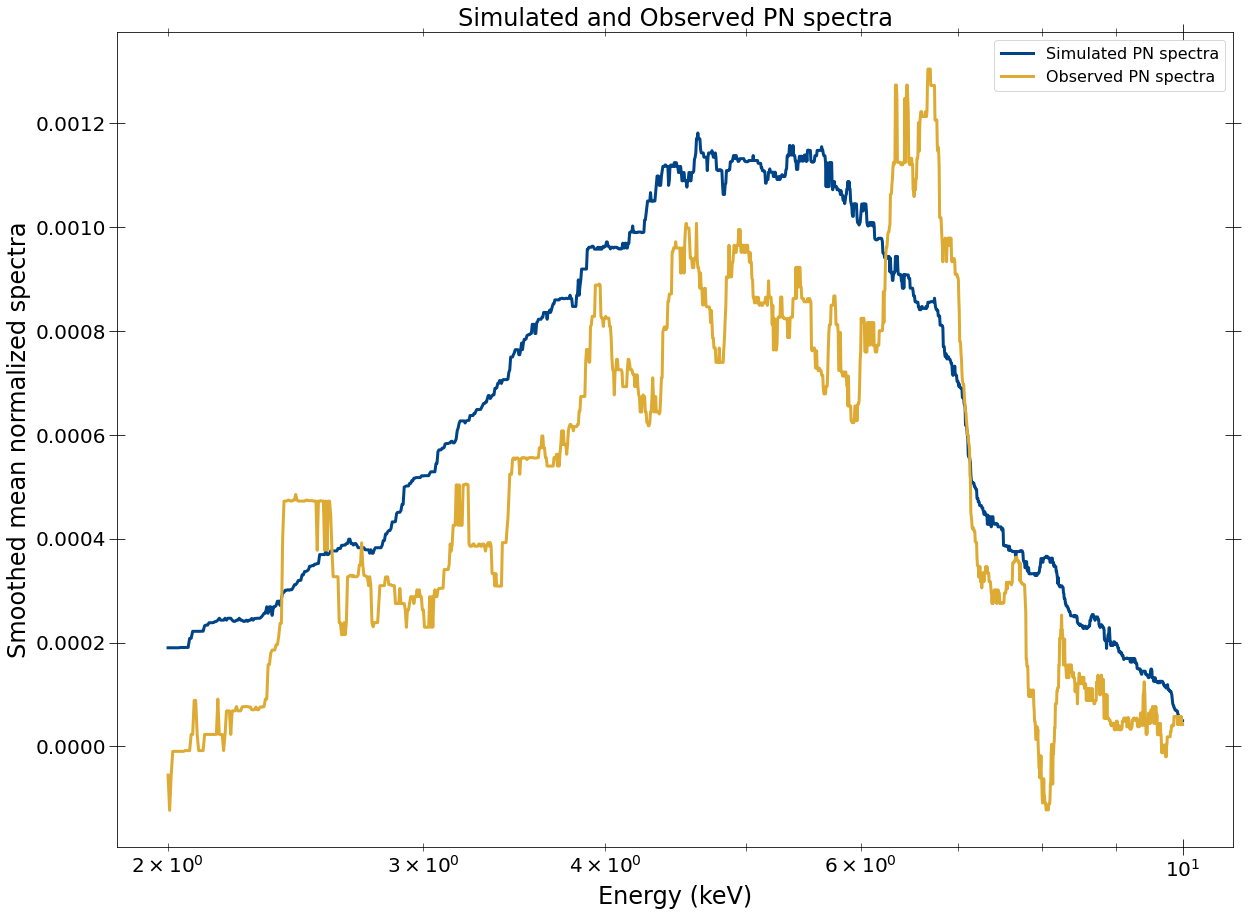

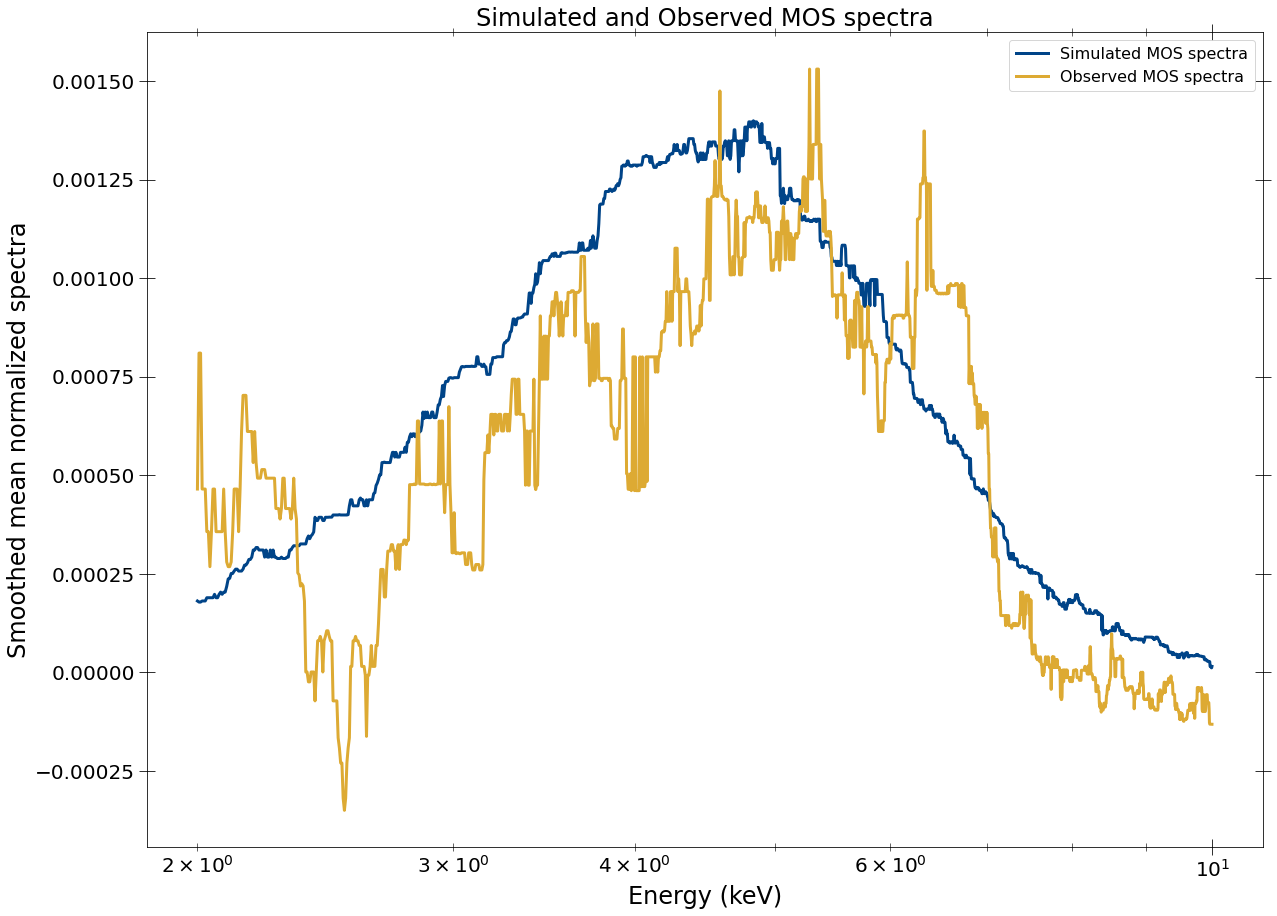

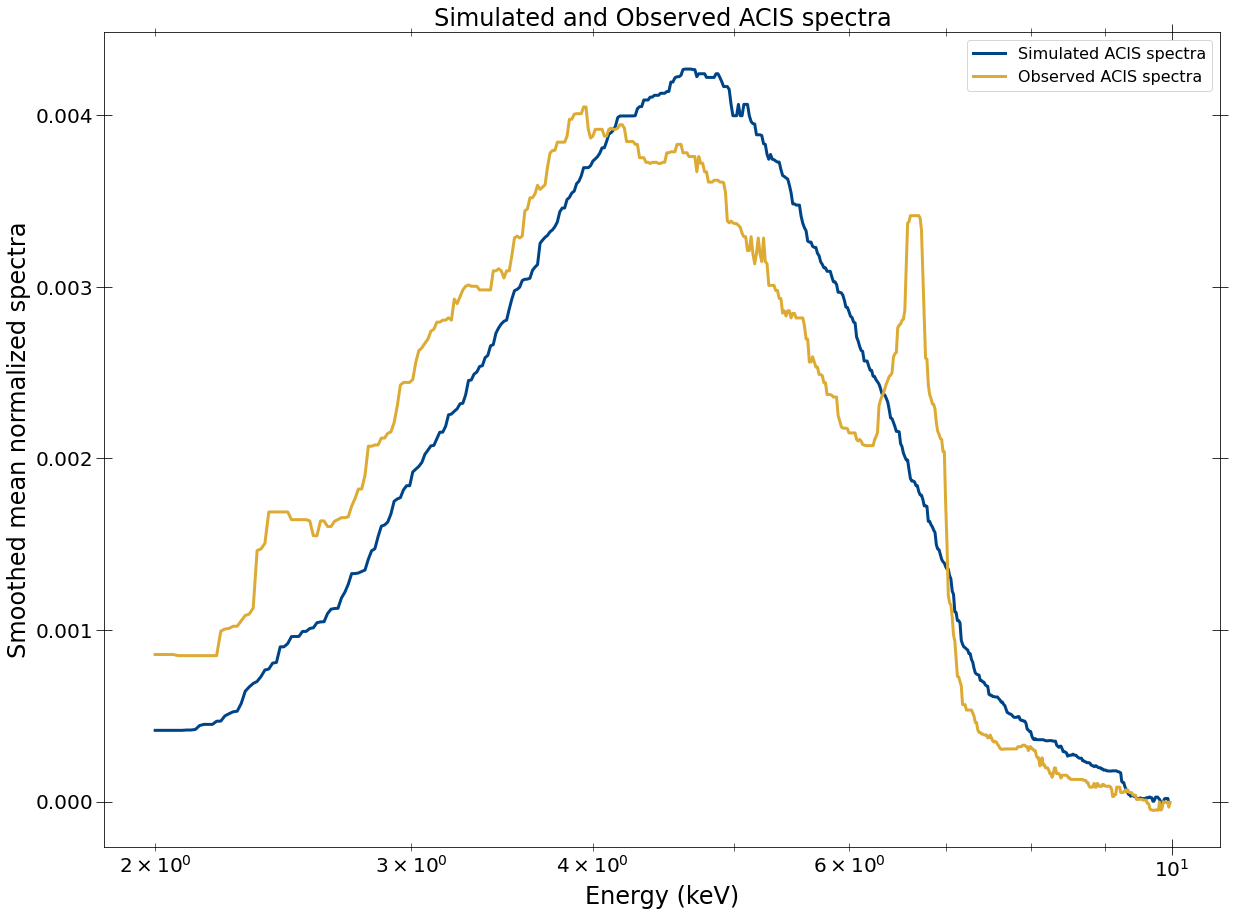

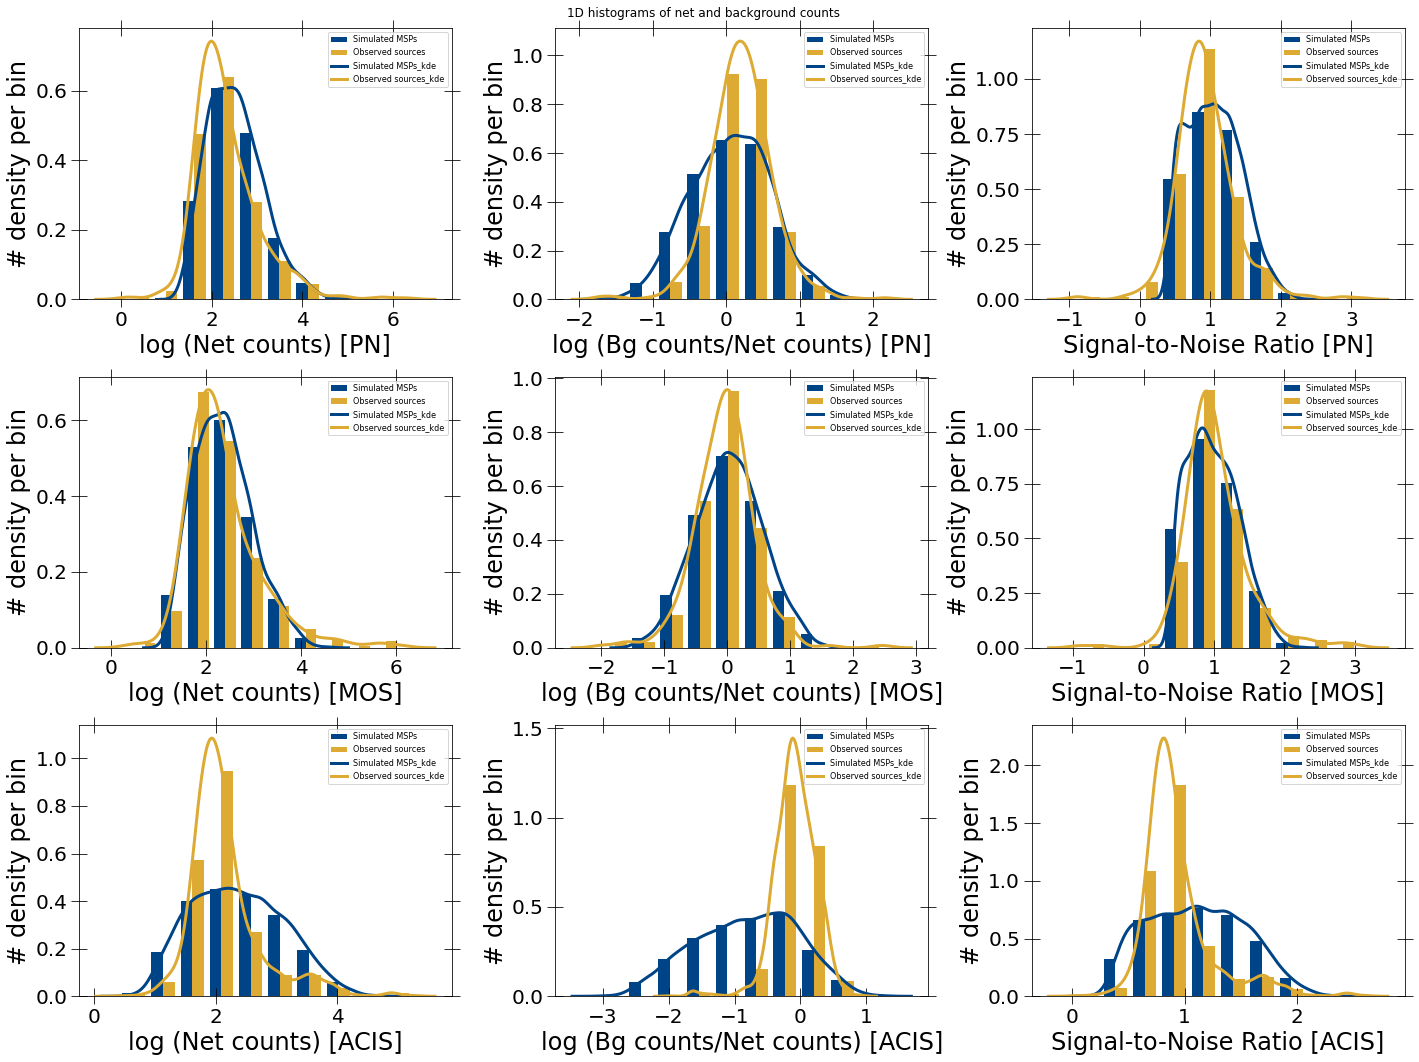

In [340]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

In [29]:
def fit_src_pl_gauss(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    xspec.Xset.parallel.error = 4
    xspec.Xset.parallel.goodness = 4
    if telescope == 'XMM':
        spec_pnfile = glob2.glob(src_folder +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob(src_folder +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.7, 0.0001, 6.1, 6.1, 7.3, 7.3'
    model.gaussian.Sigma.values = '0.1 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('2.706 6')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 8')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 6')
    xspec.Fit.error('2.706 8')
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    line_pos_low = xspec.AllModels(1).gaussian.LineE.error[0]
    line_pos_high = xspec.AllModels(1).gaussian.LineE.error[1]
    line_norm_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm_high = xspec.AllModels(1).gaussian.norm.error[1]
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_pos:', xspec.AllModels(1).gaussian.LineE.values[0],
          line_pos_low, line_pos_high,
          ' Fe_norm:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm_low, line_norm_high)
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.LineE.values[0], line_pos_low,
             line_pos_high,
             xspec.AllModels(1).gaussian.norm.values[0], line_norm_low,
             line_norm_high])


27:1: W293 blank line contains whitespace
36:1: W293 blank line contains whitespace
48:5: E265 block comment should start with '# '
66:80: E501 line too long (80 > 79 characters)


In [30]:
def fit_src_pl(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    xspec.Xset.parallel.error = 4
    xspec.Xset.parallel.goodness = 4
    if telescope == 'XMM':
        spec_pnfile = glob2.glob(src_folder +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob(src_folder +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')

    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('2.706 2')
    xspec.Fit.perform()
    print('Calculating goodness')
    #goodness = xspec.Fit.goodness(1000)
    print('Finished calculating goodness')
    goodness = 50.0
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

38:5: E265 block comment should start with '# '
50:80: E501 line too long (80 > 79 characters)


In [358]:
fit_src_pl_gauss(interested_srcs_alldet[2][1], src_folder='.', telescope='Chandra')

Model params for 2CXOJ174405.3-292031: NH =  13.531164670649881  Gamma:  2.5445926815308217e-05  norm:  0.1468500637295036  Fe_pos: 7.090349296508933 6.596165307166636 0.0  Fe_norm: 6.413684010639694e-07 0.0 1.5322175172803025e-06
Fit stats for 2CXOJ174405.3-292031:  144.50499411378615 -7.643067628929242 59.7 158




(['2CXOJ174405.3-292031', 144.50499411378615, -7.643067628929242, 59.7, 158],
 ['2CXOJ174405.3-292031',
  13.531164670649881,
  2.5445926815308217e-05,
  0.1468500637295036,
  7.090349296508933,
  6.596165307166636,
  0.0,
  6.413684010639694e-07,
  0.0,
  1.5322175172803025e-06])

In [35]:
xspec.AllData.clear()
os.chdir('/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/xmm_combined_copy/')

In [240]:
import xspec

In [32]:
os.getcwd()

'/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/xmm_combined_copy'

In [36]:
pn_fit_stats_table_pl_g = []
pn_model_params_table_pl_g = []
pn_fit_stats_table_pl_g2 = []
pn_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    pn_fit_stats_table_pl_g.append(fit_stats)
    pn_model_params_table_pl_g.append(model_params)
    pn_fit_stats_table_pl_g2.append(fit_stats2)
    pn_model_params_table_pl_g2.append(model_params2)

201113501015161
Model params for 201113501015161: NH =  5.167060519756169  Gamma:  0.09977780228181703  norm:  0.07438766090477836  Fe_pos: 6.568615180161393 6.403302971886085 6.760165881223426  Fe_norm: 3.7354246994610134e-07 1.0911591264509421e-07 6.751827844080259e-07
Fit stats for 201113501015161:  684.2789386302709 -7.946125007321109 50.0 909


Model params for 201113501015161: NH =  5.414854067923758  Gamma:  0.16950068261011203  norm:  0.07288781197007609  Fe_norms: 1.6949995118315024e-07 0.0 3.8250694351923133e-07 2.1449161802824074e-07 7.159499154663453e-09 4.548005176834564e-07 8.068411499162833e-08 0.0 3.120077378686588e-07
Fit stats for 201113501015161:  684.7753819344327 -7.948725130480151 50.0 908


201129701010015
Model params for 201129701010015: NH =  3.5518015222337502  Gamma:  0.8309308343027613  norm:  0.07681672166749906  Fe_pos: 6.807971467195359 6.679075858000969 6.921312742146225  Fe_norm: 3.6669154268101983e-07 1.1258930135148054e-07 6.616759615790213e-07
Fit s

Model params for 201129715010041: NH =  29.772757392310524  Gamma:  0.4219253801802608  norm:  0.1350138417820184  Fe_norms: 4.666308105831099e-07 2.5884000080741733e-07 7.036263404915453e-07 2.917852091878369e-07 9.134205270369539e-08 5.137948132361372e-07 1.969483864562448e-07 6.586762036983988e-09 4.090246217980183e-07
Fit stats for 201129715010041:  1057.4229841041806 -7.333357630679292 50.0 1266


201129715010042
Model params for 201129715010042: NH =  29.01458164679287  Gamma:  1.3190134044455109  norm:  0.1545207363457224  Fe_pos: 6.880876774608189 6.703262712818714 0.0  Fe_norm: 3.352242869088196e-07 5.046355614804857e-08 6.547910652611686e-07
Fit stats for 201129715010042:  818.1725485498544 -5.655026696940982 50.0 982


Model params for 201129715010042: NH =  28.43653057286715  Gamma:  1.3139123152696328  norm:  0.15058840267689652  Fe_norms: 9.935825767593162e-08 0.0 3.3691421942966214e-07 1.367742977322169e-07 0.0 3.8210591785387394e-07 2.0104435850329365e-07 0.0 4.50787422

Model params for 206946401010004: NH =  9.21728249917485  Gamma:  1.461768722522844  norm:  1.8434115685224137  Fe_norms: 3.914016725742207e-09 0.0 4.185131432504445e-06 3.9774587543286426e-06 0.0 9.056822252935695e-06 3.7015499840015574e-06 0.0 9.386844828065428e-06
Fit stats for 206946401010004:  438.0291330060066 -8.19270879163769 50.0 511


206946402010031
Model params for 206946402010031: NH =  9.786020688238004  Gamma:  2.605817426503798  norm:  0.8037680997647267  Fe_pos: 6.359243373817464 0.0 0.0  Fe_norm: 1.4247933321990219e-06 0.0 3.7850650554341048e-06
Fit stats for 206946402010031:  419.11708147793286 -9.015803312863408 50.0 540


Model params for 206946402010031: NH =  10.306571872954802  Gamma:  2.7427510084909894  norm:  0.8271521058818323  Fe_norms: 6.608648173929368e-07 0.0 2.5052149994590275e-06 6.9679760345735e-07 0.0 2.5532342154224027e-06 1.2702700766682821e-06 0.0 3.4142497978926804e-06
Fit stats for 206946402010031:  417.90352840764945 -9.055575602056962 50.0 539

Model params for 201129707010002: NH =  13.07744447524129  Gamma:  0.16033781990661214  norm:  0.16620025747347356  Fe_norms: 4.092825494566505e-07 1.6808808932832206e-07 6.810482446327783e-07 4.6436890334782943e-07 2.069746326375794e-07 7.554560550444491e-07 1.5450504048528726e-07 0.0 4.201573348494569e-07
Fit stats for 201129707010002:  781.8838927145076 -6.3651062932496 50.0 872


201129707010012
Model params for 201129707010012: NH =  33.33129768353291  Gamma:  0.8248337349514651  norm:  0.2626902655754651  Fe_pos: 6.303298486594342 6.23295064197992 6.3776960899356325  Fe_norm: 9.020639479823891e-07 5.184095791624039e-07 1.3244746107133332e-06
Fit stats for 201129707010012:  835.0503337393795 -9.169620453300178 50.0 1048


Model params for 201129707010012: NH =  33.166652512131385  Gamma:  0.9105603987132812  norm:  0.25841105635348255  Fe_norms: 6.508555073467703e-07 3.4730110986252263e-07 9.935770733121976e-07 2.753830462597888e-07 0.0 5.881563893530353e-07 3.071802066566225e-07 

Model params for 207436309010072: NH =  24.267381305623157  Gamma:  2.195398212284154  norm:  6.30108202255383  Fe_pos: 6.100000000109938 0.0 6.232839497731299  Fe_norm: 8.405096839357871e-06 1.2544804734308325e-06 1.643956913200965e-05
Fit stats for 207436309010072:  653.6459473839134 -9.481361329067461 50.0 765


Model params for 207436309010072: NH =  24.403282164230127  Gamma:  2.1293998787910016  norm:  6.432772003791404  Fe_norms: 1.1572919479853814e-16 0.0 5.1569362290531654e-06 8.878412711349216e-13 0.0 3.6352770439442393e-06 2.376592615217537e-07 0.0 5.9182461290863096e-06
Fit stats for 207436309010072:  657.4510562417045 -8.987374869698368 50.0 764


207641904010001
Model params for 207641904010001: NH =  9.540034746817156  Gamma:  0.3044938259502609  norm:  1.0346869353004073  Fe_pos: 6.557142711404645 6.472810526752202 6.63882086278553  Fe_norm: 3.4679609785895817e-06 1.968427422592936e-06 5.1216810909170015e-06
Fit stats for 207641904010001:  987.5318187837731 -8.939133787

Model params for 207234103010019: NH =  6.382926313103203  Gamma:  0.2713757656835736  norm:  2.1695165042819076  Fe_pos: 7.022569554529733 6.950168543381181 7.098480141787703  Fe_norm: 5.997315574145126e-06 3.4179305468586097e-06 8.811103973329006e-06
Fit stats for 207234103010019:  1857.8603485201818 -4.348000012232919 50.0 1943


Model params for 207234103010019: NH =  6.309819166977047  Gamma:  0.26595394338471395  norm:  2.161360108073932  Fe_norms: 4.27910751413396e-07 0.0 2.031388041112398e-06 1.246718286305285e-06 0.0 2.9868791968451124e-06 4.355512191283313e-06 2.356563745336416e-06 6.562975217121833e-06
Fit stats for 207234103010019:  1858.199822693518 -4.346230540503538 50.0 1942


207234104010012
Model params for 207234104010012: NH =  8.160957110586645  Gamma:  0.5751097730487145  norm:  5.627342466372918  Fe_pos: 6.943986132690705 6.823769486066552 7.15090157846507  Fe_norm: 1.7420084414402957e-05 1.1295780196362706e-05 2.4054032639195563e-05
Fit stats for 207234104010012

Model params for 206904418010045: NH =  4.686697820821784  Gamma:  0.15703235817683317  norm:  2.801564161299734  Fe_pos: 7.127447810340662 6.781472156836896 7.233052847038338  Fe_norm: 1.3332213443976126e-05 8.466175263001513e-06 1.8793913602501405e-05
Fit stats for 206904418010045:  904.5214792571435 -7.985477912465639 50.0 1005


Model params for 206904418010045: NH =  4.3255339935530825  Gamma:  0.1296048304883743  norm:  2.7442033720703094  Fe_norms: 3.8096425179134123e-06 1.3315101816368827e-06 6.629143861688672e-06 4.969226274621276e-06 2.1201536234179024e-06 8.211460231799251e-06 5.526935034449582e-06 2.1795278907447057e-06 9.368232090678733e-06
Fit stats for 206904418010045:  908.2243017497555 -8.34952477924733 50.0 1004


207234103010046
Model params for 207234103010046: NH =  6.926437616976915  Gamma:  0.05794820909259998  norm:  1.6255161116467594  Fe_pos: 6.697590934502652 6.586939927544559 6.818849687135476  Fe_norm: 3.5653509569050057e-06 1.3071314747612893e-06 6.0221855

Model params for 208860107010001: NH =  13.953729790578471  Gamma:  1.8601476735342082  norm:  3.731111658341462  Fe_pos: 6.501197716518862 6.338086796117543 6.640640022827582  Fe_norm: 2.996811736486401e-06 7.979780064124028e-07 5.324325701194428e-06
Fit stats for 208860107010001:  1708.2354172297985 -8.894820962747072 50.0 2042


Model params for 208860107010001: NH =  13.917702803826787  Gamma:  1.8482482352346543  norm:  3.7334974035956345  Fe_norms: 1.5450651057675325e-06 0.0 3.3117591118591068e-06 7.341409095474529e-07 0.0 2.4416932212270554e-06 8.4018844930718695e-22 0.0 5.965059375443963e-07
Fit stats for 208860107010001:  1710.6999889994395 -8.895373923804147 50.0 2041


201129719010003
Model params for 201129719010003: NH =  9.174319105210369  Gamma:  0.9258577970350139  norm:  2.3218884874583527  Fe_pos: 6.303290095853767 0.0 6.5178142261025656  Fe_norm: 1.714981981305688e-06 2.9569247476622304e-07 3.2125446594921643e-06
Fit stats for 201129719010003:  2222.9143468999464 -9.

Model params for 207234105010017: NH =  7.130899715176022  Gamma:  0.5662682036365372  norm:  3.84865523832892  Fe_pos: 6.761348087323231 6.707493654933957 6.814785919589406  Fe_norm: 8.952803437935937e-06 6.379473681432336e-06 1.1636599979301118e-05
Fit stats for 207234105010017:  5428.079512617447 -3.386081482271007 50.0 2712


Model params for 207234105010017: NH =  7.210000415718981  Gamma:  0.601354746613466  norm:  3.7967936654037766  Fe_norms: 3.0100920189813066e-06 1.4173325335189285e-06 4.695493192386199e-06 6.280040874773775e-06 4.349938102076245e-06 8.31478494972118e-06 3.3167118801539853e-06 1.4096993663198084e-06 5.353540884251534e-06
Fit stats for 207234105010017:  5417.079656186499 -3.3858042168494906 50.0 2711


207234105010038
Model params for 207234105010038: NH =  4.667991196792453  Gamma:  0.19594825889403772  norm:  3.07141566572793  Fe_pos: 6.592259364737232 6.520947529531284 6.670171367532089  Fe_norm: 1.0545300168836996e-05 7.078439809560274e-06 1.42436354108712

Model params for 201129702010002: NH =  23.05132821504401  Gamma:  1.8217126155840602  norm:  3.1887594721236696  Fe_norms: 4.2614777214723664e-09 0.0 6.545145224090415e-07 2.693213322019375e-07 0.0 9.363494123971593e-07 3.2356594632855174e-07 0.0 9.85631056476425e-07
Fit stats for 201129702010002:  2972.855079145419 -7.046223315700569 50.0 2978


201129705010011
Model params for 201129705010011: NH =  7.839231675538625  Gamma:  1.3108474237135483  norm:  0.46289364762261603  Fe_pos: 6.738265997582534 0.0 0.0  Fe_norm: 7.904929875382777e-20 0.0 2.800425987719552e-07
Fit stats for 201129705010011:  3140.376817408358 -5.75674440283408 50.0 2908


Model params for 201129705010011: NH =  7.841829758462728  Gamma:  1.3100822506124525  norm:  0.4631712372742016  Fe_norms: 5.136412112466445e-19 0.0 2.1381378536718177e-07 2.0804876157514476e-19 0.0 2.004299056259637e-07 1.4555005521545286e-15 0.0 1.1310103084171872e-07
Fit stats for 201129705010011:  3140.380966469166 -5.758212946172336 50.0 2

Model params for 203032102010002: NH =  14.993654301284632  Gamma:  1.4925741547690166  norm:  13.739716832146257  Fe_pos: 7.149268003724124 0.0 0.0  Fe_norm: 3.3922946250558435e-11 0.0 2.9486334603501756e-06
Fit stats for 203032102010002:  9193.952011967125 -4.562555212851463 50.0 3162


Model params for 203032102010002: NH =  15.000385047616549  Gamma:  1.4934652254540126  norm:  13.743306173510067  Fe_norms: 7.450053740322712e-22 0.0 1.4442229100681567e-06 3.493832589111749e-21 0.8224962005991274 0.0 2.5651321292035044e-20 0.0 1.4006897555444677e-06
Fit stats for 203032102010002:  9193.950839978002 -4.562562721941759 50.0 3161


207901804010003
Model params for 207901804010003: NH =  22.57051273441629  Gamma:  5.0  norm:  94.07667866563223  Fe_pos: 6.73964041448673 0.0 0.0  Fe_norm: 4.072477671732721e-06 0.0 8.382646392803007e-06
Fit stats for 207901804010003:  1278.2700034240563 -9.198308887250587 50.0 1337


Model params for 207901804010003: NH =  22.579365646955612  Gamma:  5.0  

In [21]:
pn_fit_stats_table2_pl_g = []
pn_model_params_table2_pl_g = []
pn_fit_stats_table2_pl_g2 = []
pn_model_params_table2_pl_g2 = []

for source_num in interested_srcs_alldet2[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    pn_fit_stats_table2_pl_g.append(fit_stats)
    pn_model_params_table2_pl_g.append(model_params)
    pn_fit_stats_table2_pl_g2.append(fit_stats2)
    pn_model_params_table2_pl_g2.append(model_params2)

NameError: name 'interested_srcs_alldet2' is not defined

In [37]:
len(pn_fit_stats_table2_pl)

NameError: name 'pn_fit_stats_table2_pl' is not defined

In [38]:
pn_fit_stats_table_pl = []
pn_model_params_table_pl = []

for source_num in interested_srcs_alldet[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    pn_fit_stats_table_pl.append(fit_stats)
    pn_model_params_table_pl.append(model_params)

201113501015161
Calculating goodness
Finished calculating goodness
Model params for 201113501015161: NH =  5.541310876745654  Gamma:  5.707690127352595e-06  norm:  0.08173361088449042
Fit stats for 201113501015161:  689.9224967396643 -7.552819334302026 50.0 911


201129701010015
Calculating goodness
Finished calculating goodness
Model params for 201129701010015: NH =  2.481201490738602  Gamma:  0.533140066826652  norm:  0.08172728789062951
Fit stats for 201129701010015:  893.2213311779984 -6.7024123978722345 50.0 1131


201129702010014
Calculating goodness
Finished calculating goodness
Model params for 201129702010014: NH =  40.06416874021883  Gamma:  0.924663943665226  norm:  0.30550197469453827
Fit stats for 201129702010014:  982.1066525179031 -6.281174171692044 50.0 1155


201129702010049
Calculating goodness
Finished calculating goodness
Model params for 201129702010049: NH =  17.23915932957361  Gamma:  1.4795148708673922e-06  norm:  0.10918200787412372
Fit stats for 20112970201004

Calculating goodness
Finished calculating goodness
Model params for 201129704010010: NH =  47.45721632521401  Gamma:  1.309073677523654  norm:  0.33515605074365606
Fit stats for 201129704010010:  1489.110844698224 -7.436297313359316 50.0 1766


201129704010019
Calculating goodness
Finished calculating goodness
Model params for 201129704010019: NH =  29.864659268969216  Gamma:  0.6018414528332767  norm:  0.19360827900475353
Fit stats for 201129704010019:  1297.2771783005433 -6.796427163329778 50.0 1425


201129704010027
Calculating goodness
Finished calculating goodness
Model params for 201129704010027: NH =  41.62521980981414  Gamma:  0.8812521184821249  norm:  0.3626863600532729
Fit stats for 201129704010027:  1259.280274068988 -5.89001736677815 50.0 1576


201129707010002
Calculating goodness
Finished calculating goodness
Model params for 201129707010002: NH =  16.008572366704563  Gamma:  0.18894350827211082  norm:  0.19323181653137078
Fit stats for 201129707010002:  799.910755380052

Calculating goodness
Finished calculating goodness
Model params for 207242102010146: NH =  28.62611579470891  Gamma:  2.1656847917957114  norm:  1.9459815040232833
Fit stats for 207242102010146:  690.1696468891221 -9.829261326947321 50.0 835


207242102015037
Calculating goodness
Finished calculating goodness
Model params for 207242102015037: NH =  27.087073804875224  Gamma:  2.2726193113375888  norm:  2.5177686409746904
Fit stats for 207242102015037:  738.040362343911 -10.289020574215176 50.0 858


207901804010060
Calculating goodness
Finished calculating goodness
Model params for 207901804010060: NH =  18.96218438716845  Gamma:  5.0  norm:  4.634169394067818
Fit stats for 207901804010060:  649.8780387586268 -7.240863460389118 50.0 808


201529201010060
Calculating goodness
Finished calculating goodness
Model params for 201529201010060: NH =  5.500378788775219  Gamma:  1.5707243067766632  norm:  1.0521718785782956
Fit stats for 201529201010060:  800.7306948935131 -9.73336646453592 50.

Calculating goodness
Finished calculating goodness
Model params for 207234105010017: NH =  6.90158455735671  Gamma:  0.48192148408317875  norm:  3.9594240824805227
Fit stats for 207234105010017:  5464.589677693161 -3.384728511404018 50.0 2714


207234105010038
Calculating goodness
Finished calculating goodness
Model params for 207234105010038: NH =  4.557404158239049  Gamma:  0.10534488337286323  norm:  3.2365295213622054
Fit stats for 207234105010038:  1383.5769287534586 -7.671930064553081 50.0 1254


207242105010186
Calculating goodness
Finished calculating goodness
Model params for 207242105010186: NH =  7.031867151001163  Gamma:  0.20346725589053233  norm:  3.3773802543828846
Fit stats for 207242105010186:  6781.28982929883 -3.103794721100344 50.0 2727


207622503010007
Calculating goodness
Finished calculating goodness
Model params for 207622503010007: NH =  25.950525615999233  Gamma:  1.914754761913974  norm:  3.7535078072999184
Fit stats for 207622503010007:  2188.11469027598 -5

In [246]:
pn_fit_stats_table2_pl = []
pn_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    pn_fit_stats_table2_pl.append(fit_stats)
    pn_model_params_table2_pl.append(model_params)

200305401010049
Model params for 200305401010049: NH =  39.805908434776285  Gamma:  7.169042835422148e-07  norm:  0.2136166691845309
Fit stats for 200305401010049:  331.47548228732285 -5.578814283706613 50.0 439


201129701010051
Model params for 201129701010051: NH =  0.43201730131312205  Gamma:  7.463879676030254e-06  norm:  0.1466287081116996
Fit stats for 201129701010051:  310.75854886357934 -6.081222052127955 50.0 317


201129704010031
Model params for 201129704010031: NH =  30.565616107080245  Gamma:  2.3993514482036167  norm:  0.151691544568419
Fit stats for 201129704010031:  889.402788554389 -5.9470772626802795 50.0 1173


201129704010041
Model params for 201129704010041: NH =  10.611039158171966  Gamma:  0.3067599355345301  norm:  0.2244129493697962
Fit stats for 201129704010041:  233.22676400644966 -7.7287610123439165 50.0 243


201129707010018
Model params for 201129707010018: NH =  24.29983000192929  Gamma:  1.9939350000327225  norm:  0.15077201100639415
Fit stats for 20112

Model params for 206946405010094: NH =  5.407768315532954  Gamma:  0.5207580618543582  norm:  0.08212040471758167
Fit stats for 206946405010094:  290.3303674164932 -6.719550622948568 50.0 330


206946408010060
Model params for 206946408010060: NH =  28.3727835301244  Gamma:  1.1127643880517504  norm:  0.19864922381537084
Fit stats for 206946408010060:  337.47779804685797 -7.890584621046666 50.0 363


206946408015034
Model params for 206946408015034: NH =  52.3346557980782  Gamma:  3.180575889921384  norm:  1.1513422555114954
Fit stats for 206946408015034:  246.8565252798347 -5.137769931282889 50.0 285


206946409010022
Model params for 206946409010022: NH =  6.229705740790377  Gamma:  1.337606718368001  norm:  0.8797420859841123
Fit stats for 206946409010022:  295.77367670777767 -8.176075386330327 50.0 365


206946410010025
Model params for 206946410010025: NH =  6.840441743610254  Gamma:  0.758532671078732  norm:  0.5003378540979199
Fit stats for 206946410010025:  223.2894362244432 -7

Model params for 201129707010040: NH =  49.5776244985074  Gamma:  1.2638154782543423  norm:  0.17775650886596062
Fit stats for 201129707010040:  273.29273602735196 -6.511778573323717 50.0 328


201129708010066
Model params for 201129708010066: NH =  13.998103667743958  Gamma:  0.14613824808254078  norm:  0.18404946824502677
Fit stats for 201129708010066:  580.7733946326856 -4.568653162279634 50.0 682


201129708015085
Model params for 201129708015085: NH =  42.989387506155325  Gamma:  1.7543090971160176  norm:  0.20897089534232183
Fit stats for 201129708015085:  251.87547615352065 -6.177845330182773 50.0 262


201129709010025
Model params for 201129709010025: NH =  6.40347444101713  Gamma:  0.05817900184452419  norm:  0.16778054162593295
Fit stats for 201129709010025:  509.0541264754828 -4.923834552450399 50.0 562


201129715010023
Model params for 201129715010023: NH =  0.10000003102585676  Gamma:  2.089663094699327e-06  norm:  0.04249493158550592
Fit stats for 201129715010023:  394.0

Model params for 207901804010064: NH =  18.46779866389381  Gamma:  5.0  norm:  5.757402468988422
Fit stats for 207901804010064:  790.7161832827782 -7.498702064109055 50.0 826


208016803010003
Model params for 208016803010003: NH =  6.185355381703184  Gamma:  1.222260426169147  norm:  0.3198136926262305
Fit stats for 208016803010003:  628.9378982866099 -6.627109769538901 50.0 773


208016813010003
Model params for 208016813010003: NH =  6.628568658343826  Gamma:  1.762801904733762  norm:  0.2506705496106544
Fit stats for 208016813010003:  609.6442782716246 -5.657308286493724 50.0 763


208016813010013
Model params for 208016813010013: NH =  6.2129703823132525  Gamma:  0.24658217895254392  norm:  0.2683124097208932
Fit stats for 208016813010013:  347.3815332130674 -8.689638894584515 50.0 385


208024101010072
Model params for 208024101010072: NH =  11.526056556793954  Gamma:  0.0077092933896032384  norm:  0.09076235368713732
Fit stats for 208024101010072:  251.75775610120792 -6.92033812

Model params for 201032613010002: NH =  5.426897119465339  Gamma:  0.47090027769133375  norm:  0.773994391241295
Fit stats for 201032613010002:  1255.9294417727688 -7.646708669602269 50.0 1560


201129701010027
Model params for 201129701010027: NH =  9.649795795108659  Gamma:  1.0283016380837886  norm:  0.1715001259084814
Fit stats for 201129701010027:  845.1138053816295 -8.60805417961941 50.0 1045


201129707010002
Model params for 201129707010002: NH =  16.008572366704563  Gamma:  0.18894350827211082  norm:  0.19323181653137078
Fit stats for 201129707010002:  799.910755380052 -6.3528137034330925 50.0 875


201129707010014
Model params for 201129707010014: NH =  11.380393225831108  Gamma:  0.18691894637792855  norm:  0.1216807812303055
Fit stats for 201129707010014:  592.0827559583832 -6.750975432637999 50.0 750


201129707010015
Model params for 201129707010015: NH =  32.35747657951063  Gamma:  1.0894609976307805  norm:  0.3090676467890682
Fit stats for 201129707010015:  919.64671006

Model params for 201529201010091: NH =  6.144001308598835  Gamma:  1.6370323629059782  norm:  2.17517483905738
Fit stats for 201529201010091:  1062.975988439709 -10.095625255028244 50.0 1119


206904418010014
Model params for 206904418010014: NH =  7.895295102067729  Gamma:  0.583485936877836  norm:  5.95882815262876
Fit stats for 206904418010014:  4564.6949187009695 -3.1480746742101013 50.0 2213


206904418010045
Model params for 206904418010045: NH =  4.147060291533469  Gamma:  0.00016760760069234944  norm:  2.958306891669967
Fit stats for 206904418010045:  929.9509870426419 -7.5724778375108235 50.0 1007


207234103010019
Model params for 207234103010019: NH =  5.945790625513885  Gamma:  0.15108964511596037  norm:  2.2463250037594
Fit stats for 207234103010019:  1874.200267726933 -4.3457016652917915 50.0 1945


207234103010046
Model params for 207234103010046: NH =  6.923478625133678  Gamma:  0.006505933919449624  norm:  1.682038634905474
Fit stats for 207234103010046:  1151.92881471

Model params for 203032102010002: NH =  15.002549958616619  Gamma:  1.4942005371867502  norm:  13.742017162456085
Fit stats for 203032102010002:  9193.94867685653 -4.562337467053314 50.0 3164


207234103015046
Model params for 207234103015046: NH =  5.406904543871727  Gamma:  0.1288005213954796  norm:  8.412933049755239
Fit stats for 207234103015046:  2243.650389389737 -7.9349554900887025 50.0 1545


208624706010010
Model params for 208624706010010: NH =  31.037456818099162  Gamma:  1.3308270028133227  norm:  573.2801325560904
Fit stats for 208624706010010:  1960.6696181107352 -9.565236325299427 50.0 1591


205110012010001
Model params for 205110012010001: NH =  8.58678150667414  Gamma:  1.3078729413072792  norm:  891.90282543595
Fit stats for 205110012010001:  5155.5029559293125 -7.217156512365482 50.0 3162


201129721010005
Model params for 201129721010005: NH =  15.850574048781128  Gamma:  2.0500678412632745  norm:  2.711500338501457
Fit stats for 201129721010005:  105738.5169469819

In [40]:
test

SyntaxError: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)

6: E999 SyntaxError: unexpected character after line continuation character


Error before execution: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)


In [248]:
mos_fit_stats_table2_pl_g = []
mos_model_params_table2_pl_g = []
mos_fit_stats_table2_pl_g2 = []
mos_model_params_table2_pl_g2 = []

for source_num in interested_srcs_alldet2[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    mos_fit_stats_table2_pl_g.append(fit_stats)
    mos_model_params_table2_pl_g.append(model_params)
    mos_fit_stats_table2_pl_g2.append(fit_stats2)
    mos_model_params_table2_pl_g2.append(model_params2)

201129701010027
Model params for 201129701010027: NH =  9.819770036600167  Gamma:  1.1039206092219227  norm:  0.1677499948292157  Fe_pos: 6.3840886259328435 6.257737231836482 6.517471358685884  Fe_norm: 2.686869599961564e-07 2.1695656705176165e-08 5.437366520709519e-07
Fit stats for 201129701010027:  841.882095458817 -8.665785645329287 50.0 1043


Model params for 201129701010027: NH =  10.0926877825381  Gamma:  1.1712645622711444  norm:  0.16673469499491544  Fe_norms: 2.880125435841834e-07 8.050868824537158e-08 5.25120430834049e-07 5.760894113250644e-12 0.0 1.534723790504566e-07 1.5577976887676093e-07 0.0 3.994094832955193e-07
Fit stats for 201129701010027:  838.6227508932285 -8.656965662701412 50.0 1042


201129704010031
Model params for 201129704010031: NH =  33.7677096813271  Gamma:  2.728895098231746  norm:  0.17796542796111728  Fe_pos: 7.299999718069995 0.0 0.0  Fe_norm: 2.0546650152968042e-07 0.0 9.33924576918656e-07
Fit stats for 201129704010031:  888.8044698104263 -5.939907079

Model params for 206556701010016: NH =  7.855355270701126  Gamma:  0.7055260532301157  norm:  0.0838775220009082  Fe_pos: 6.799769089915469 6.677702332421763 6.916114967669991  Fe_norm: 5.343335988558654e-07 1.6536779855362085e-07 9.981604640990476e-07
Fit stats for 206556701010016:  562.265516203551 -6.43700547138055 50.0 715


Model params for 206556701010016: NH =  7.167697532841169  Gamma:  0.4930442701744168  norm:  0.0885198000667998  Fe_norms: 3.914748361249937e-15 0.0 1.9637454489663345e-07 2.053266329374451e-07 0.0 5.421530716513982e-07 3.010723480495581e-08 0.0 3.5896856415939304e-07
Fit stats for 206556701010016:  566.8532104882255 -6.394293662686685 50.0 714


206556701010023
Model params for 206556701010023: NH =  2.1270834826659266  Gamma:  2.505390338589546e-06  norm:  0.07251707791549934  Fe_pos: 6.557813169094284 6.479322648973209 6.635290379954195  Fe_norm: 6.914120104447882e-07 3.2032208431706496e-07 1.105381503088828e-06
Fit stats for 206556701010023:  770.028659732

Model params for 202026707010221: NH =  6.3016210895329055  Gamma:  1.733388498666554  norm:  0.13745736010572235  Fe_pos: 6.148659688783511 0.0 0.0  Fe_norm: 3.2676824246574486e-07 0.0 1.4108737889620754e-06
Fit stats for 202026707010221:  322.11205226182364 -6.879937910744003 50.0 373


Model params for 202026707010221: NH =  5.751677128206241  Gamma:  1.5746216398890527  norm:  0.1389171080334418  Fe_norms: 1.945034508823684e-16 0.0 6.503911944930553e-07 8.006285478178546e-08 0.0 1.1805745635594766e-06 2.9645400345078745e-11 0.0 1.2237678702125133e-06
Fit stats for 202026707010221:  322.48140061392337 -6.906561630801784 50.0 372


202026707010240
Model params for 202026707010240: NH =  2.1371053816531225  Gamma:  0.3535571219492564  norm:  0.12696458300144622  Fe_pos: 6.897918585161181 6.74087654803363 7.006648862821705  Fe_norm: 1.3314963449581852e-06 2.966401121155157e-07 2.7783777275766182e-06
Fit stats for 202026707010240:  337.3682410278833 -7.566457859274431 50.0 399


Model p

Model params for 206735502010047: NH =  16.78331030218887  Gamma:  0.7047226011269394  norm:  0.3546298944640384  Fe_norms: 6.954914066915627e-07 0.0 3.1424749677627603e-06 6.408606226390284e-22 0.0 1.8203852016260875e-06 1.342753352671312e-18 0.0 1.5701852471047705e-06
Fit stats for 206735502010047:  265.05713339651527 -7.1508409166815206 50.0 300


206735502010049
Model params for 206735502010049: NH =  9.884677494480416  Gamma:  1.8014469589014983  norm:  0.17584112967622578  Fe_pos: 6.91581189714852 0.0 0.0  Fe_norm: 1.0975538810284656e-06 0.0 3.97675509690739e-06
Fit stats for 206735502010049:  309.93109783297115 -6.478883202667095 50.0 342


Model params for 206735502010049: NH =  11.1273308071883  Gamma:  2.1212946165428397  norm:  0.17915432620372754  Fe_norms: 6.170901402510062e-07 0.0 1.914180308823877e-06 2.5282526637134285e-07 0.0 1.6397834380133033e-06 6.59117456173523e-07 0.0 2.4234572263112654e-06
Fit stats for 206735502010049:  309.5133412964408 -6.584803907900362 50.0 

Model params for 206946401010003: NH =  9.91131613965665  Gamma:  1.5530828683846476  norm:  0.8081794176144841  Fe_pos: 7.3 6.6924390665396265 0.0  Fe_norm: 2.0633869393793765e-06 4.942041510935063e-08 4.457535362827374e-06
Fit stats for 206946401010003:  979.9495468786388 -3.905526865174976 50.0 1005


Model params for 206946401010003: NH =  9.508755649723287  Gamma:  1.468018634649897  norm:  0.8051212148965766  Fe_norms: 1.8087496716941346e-13 0.0 8.573818424478976e-07 2.3774626453567542e-18 0.0 1.306862295459087e-06 8.369579123608156e-07 0.0 2.4364495977030576e-06
Fit stats for 206946401010003:  981.804046412713 -3.9032274759289676 50.0 1004


208016803010001
Model params for 208016803010001: NH =  5.477438247722109  Gamma:  0.7910695804625593  norm:  0.6112963494070606  Fe_pos: 6.47529835813703 6.35485643721511 6.611925243433143  Fe_norm: 1.348419485181247e-06 3.689821193491286e-07 2.4614583841749452e-06
Fit stats for 208016803010001:  986.3285668155654 -7.282235643893765 50.0 11

Model params for 201129704010012: NH =  47.99547378902808  Gamma:  1.1455378402935856  norm:  0.193340980282925  Fe_norms: 4.976917818064273e-07 1.9454470224134595e-07 8.77319904920263e-07 9.565092193988462e-07 6.073720419931775e-07 1.4473729170547097e-06 4.6028945632850123e-07 1.6413169751286473e-07 8.204330158239285e-07
Fit stats for 201129704010012:  1307.8389133360947 -5.942811816045561 50.0 1622


201129704010030
Model params for 201129704010030: NH =  10.275657314499618  Gamma:  0.06913579956366873  norm:  0.11087469618622794  Fe_pos: 6.785720053889405 6.73219401972946 6.838356850043799  Fe_norm: 1.0468878738555692e-06 7.888495708382812e-07 1.3271605684070161e-06
Fit stats for 201129704010030:  1397.6022141448511 -4.95895388099019 50.0 1596


Model params for 201129704010030: NH =  8.85062892487003  Gamma:  0.09278108641214622  norm:  0.10068662053060018  Fe_norms: 2.941016499861173e-07 1.3845935537132127e-07 4.6539638413611707e-07 6.751424687966461e-07 4.836384050747141e-07 8.87

Model params for 202026708010061: NH =  4.284414241178537  Gamma:  0.6217750016690143  norm:  0.15456650888143342  Fe_pos: 6.47965814789462 6.403768020942791 6.558311948262894  Fe_norm: 6.075893752752013e-07 3.498994435722654e-07 8.828080582724337e-07
Fit stats for 202026708010061:  1494.4958368776684 -7.010208430063332 50.0 1784


Model params for 202026708010061: NH =  4.649384667622556  Gamma:  0.7263775066297368  norm:  0.15097671859213718  Fe_norms: 4.4620100045090273e-07 2.512563547331493e-07 6.605388268149822e-07 2.5454824732187586e-07 4.6791726317826057e-08 4.844191820904564e-07 2.442860353690041e-07 4.221644753733374e-08 4.712812726426638e-07
Fit stats for 202026708010061:  1489.0896818618544 -7.026614485857815 50.0 1783


205100104010002
Model params for 205100104010002: NH =  19.04107627068398  Gamma:  1.443483887264985  norm:  2.3635982897006516  Fe_pos: 6.6612276314994 0.0 0.0  Fe_norm: 1.7168092374945094e-06 0.0 4.722916468979159e-06
Fit stats for 205100104010002:  706.83

Model params for 207234103010048: NH =  5.983796713687287  Gamma:  0.21415195618769559  norm:  3.400524523775699  Fe_norms: 2.933445913517748e-06 0.0 8.94419800559215e-06 9.996052483656814e-07 0.0 7.318711518780237e-06 1.3265608624497831e-05 5.582602503375814e-06 2.260345451722159e-05
Fit stats for 207234103010048:  498.3276047697127 -9.440821195722663 50.0 610


207234104010049
Model params for 207234104010049: NH =  6.8492077803500715  Gamma:  0.11770209850992475  norm:  3.86232913511545  Fe_pos: 7.275464132059056 0.0 0.0  Fe_norm: 9.232131887967399e-06 0.0 2.0871916755029953e-05
Fit stats for 207234104010049:  501.56366509796555 -8.885169277235837 50.0 630


Model params for 207234104010049: NH =  6.361865227330297  Gamma:  0.002450435063314329  norm:  3.9775621346067975  Fe_norms: 9.057807639689313e-18 0.0 4.318790355520227e-06 1.562091015249209e-15 0.0 4.334276990275446e-06 9.200381357444726e-07 0.0 8.404585800828589e-06
Fit stats for 207234104010049:  503.9697464580271 -8.6830511

Model params for 202026707010170: NH =  7.013226942454524  Gamma:  0.8820863785806043  norm:  0.12875534724101076  Fe_pos: 6.56057504831706 0.0 0.0  Fe_norm: 4.810961043587065e-07 0.0 1.1432187070734963e-06
Fit stats for 202026707010170:  580.6182900624632 -8.273568707654396 50.0 766


Model params for 202026707010170: NH =  6.7672570456841825  Gamma:  0.8169553811135155  norm:  0.1302743367247342  Fe_norms: 1.2521961159022592e-07 0.0 5.703849925630193e-07 2.1310353044046914e-07 0.0 7.545382577573849e-07 3.686893758203222e-13 0.0 5.136299534234932e-07
Fit stats for 202026707010170:  581.745541320635 -8.288187689284877 50.0 765


202026707010187
Model params for 202026707010187: NH =  3.9335433505911768  Gamma:  8.317652064257133e-08  norm:  8.157141762609772  Fe_pos: 7.3 7.15179165289488 0.0  Fe_norm: 1.7909727455023544e-05 4.788642128791051e-06 3.321136022158643e-05
Fit stats for 202026707010187:  868.8741528794254 -9.679713169893967 50.0 999


Model params for 202026707010187: NH =  

Model params for 201129721010060: NH =  15.502729409114743  Gamma:  1.6838274693457587  norm:  0.1795795097114884  Fe_pos: 7.045162976101989 0.0 0.0  Fe_norm: 4.117561983453338e-09 0.0 1.4530004265870746e-07
Fit stats for 201129721010060:  2557.647102860751 -9.05659859399537 50.0 2655


Model params for 201129721010060: NH =  15.515854933961947  Gamma:  1.6844314586726221  norm:  0.17971310320210512  Fe_norms: 3.720928794148729e-15 0.0 3.2819488898655345e-08 2.1830729881930585e-15 0.0 8.574920912523508e-08 1.846859471331045e-08 0.0 1.2392580495213957e-07
Fit stats for 201129721010060:  2557.563677277806 -9.055103612336135 50.0 2654


206904418010026
Model params for 206904418010026: NH =  7.163308511312102  Gamma:  0.38616378742769486  norm:  2.0941759158713067  Fe_pos: 6.739749894008129 6.632307080121754 6.857105851121971  Fe_norm: 4.10138267471892e-06 1.7127363109120024e-06 6.663039361781383e-06
Fit stats for 206904418010026:  2035.747297997201 -3.298590689355155 50.0 1711


Model pa

Model params for 207234105010057: NH =  3.417495231709657  Gamma:  0.017176679106110666  norm:  2.9372329568770463  Fe_pos: 7.072117404141569 6.908213563703137 7.233755615042011  Fe_norm: 8.764712814491116e-06 3.381818775781192e-06 1.498931229698545e-05
Fit stats for 207234105010057:  914.5138760207142 -9.412528802666339 50.0 1101


Model params for 207234105010057: NH =  3.3897671365586484  Gamma:  2.561416255634501e-07  norm:  2.9759999712794083  Fe_norms: 5.383671953951988e-16 0.0 2.780580036194789e-06 2.3810893110424816e-15 0.0 2.6491076051031416e-06 5.430836064286777e-06 1.519376018371642e-06 9.936056476535567e-06
Fit stats for 207234105010057:  916.8144635630168 -9.314087415494324 50.0 1100


207234105010058
Model params for 207234105010058: NH =  6.106594623003617  Gamma:  0.1257542940986323  norm:  2.611726674388601  Fe_pos: 6.757353636448356 6.592288098975828 6.908299481787143  Fe_norm: 5.708857824727931e-06 1.7640621471581518e-06 1.0114291263464253e-05
Fit stats for 207234105

Model params for 204024303010202: NH =  4.856169642611636  Gamma:  5.883456958184284e-07  norm:  3.184493676651403  Fe_norms: 1.2096671227321196e-06 0.0 4.298267929859762e-06 2.0476371461787554e-22 0.0 2.7265970794292195e-06 1.1051981859811352e-05 6.629865348752212e-06 1.5984269908438222e-05
Fit stats for 204024303010202:  1062.3421156152524 -10.018723799457815 50.0 1136


207234103010028
Model params for 207234103010028: NH =  4.892865814900012  Gamma:  8.354984689500506e-07  norm:  7.360895328367821  Fe_pos: 7.29999997283874 7.187615236039556 0.0  Fe_norm: 1.746679272774411e-05 6.554366853051025e-06 3.0190370007127832e-05
Fit stats for 207234103010028:  1089.017613007953 -9.457712756303021 50.0 1117


Model params for 207234103010028: NH =  4.695725700744118  Gamma:  0.00027065464095545977  norm:  7.200520759116949  Fe_norms: 1.1786722619860583e-05 5.547242908509043e-06 1.8773994332122876e-05 2.0323993315637682e-06 0.0 9.007145052227842e-06 8.042824667475775e-06 7.488790895239013e-07

Model params for 206904418010040: NH =  7.764668085123108  Gamma:  0.22442361329321422  norm:  15.47841528283804  Fe_pos: 6.278129033352932 6.164953121755748 6.401892135106046  Fe_norm: 2.6986888072833393e-05 1.5099400977657745e-05 3.9565353381500784e-05
Fit stats for 206904418010040:  1286.5354846256246 -9.554879329239368 50.0 1283


Model params for 206904418010040: NH =  8.004237643016719  Gamma:  0.2830277409074118  norm:  15.269086925321544  Fe_norms: 1.4522780716003597e-05 5.419302517939818e-06 2.4416007588984147e-05 2.0192700518814176e-05 1.0535410178912516e-05 3.06886727145954e-05 8.91800922210179e-06 0.0 1.914667702858156e-05
Fit stats for 206904418010040:  1280.392789773588 -9.613857722845234 50.0 1282


207234104010008
Model params for 207234104010008: NH =  5.531328156783605  Gamma:  0.015682600196252106  norm:  16.068055324242767  Fe_pos: 6.467676061912062 6.3548371392296215 6.607336133294838  Fe_norm: 3.045607036268871e-05 1.5652026721328846e-05 4.6489974241275566e-05
Fit

Model params for 207234103015028: NH =  8.058077901349911  Gamma:  0.22864577090070692  norm:  12.170427654752192  Fe_pos: 6.15327352241149 0.0 6.2122226093357025  Fe_norm: 2.6628052017386167e-05 2.0316417108672898e-05 3.313812289053972e-05
Fit stats for 207234103015028:  1618.3668348934675 -9.352052740531711 50.0 1423


Model params for 207234103015028: NH =  8.290271680601188  Gamma:  0.2617176021028281  norm:  12.204179195747063  Fe_norms: 1.1502767751753544e-05 6.763011530833399e-06 1.6514501838588824e-05 8.203894934313316e-06 3.44992957957891e-06 1.3251501142110556e-05 8.061902933078205e-06 3.0360007304575013e-06 1.341499098167795e-05
Fit stats for 207234103015028:  1643.6678342220434 -9.0569741252998 50.0 1422


205049406010002
Model params for 205049406010002: NH =  7.897936717122689  Gamma:  1.118518656365431  norm:  521.8871904724538  Fe_pos: 6.10000001115165 0.0 6.211545593990412  Fe_norm: 0.00022588461946953465 7.287034506901112e-05 0.00038871523090928636
Fit stats for 20504

Model params for 201129709010001: NH =  20.160945493272433  Gamma:  1.4625351029592384  norm:  338.8111084553825  Fe_pos: 6.947811549899487 6.83950680391611 7.032809577460552  Fe_norm: 1.3799883807102694e-05 6.337823978394999e-06 2.2144254257584344e-05
Fit stats for 201129709010001:  21266.64233185489 -8.223360033936837 50.0 3193


Model params for 201129709010001: NH =  20.159875849849662  Gamma:  1.4628186970479362  norm:  338.7569128732888  Fe_norms: 4.561408497583002e-14 0.0 9.374822239695763e-07 5.1187162752041295e-06 0.0 1.1147686972086906e-05 1.1925933533753694e-05 5.815566573945834e-06 1.8030318705751364e-05
Fit stats for 201129709010001:  21263.556699926892 -8.223735135573232 50.0 3192


204105804010001
Model params for 204105804010001: NH =  6.625301101388049  Gamma:  1.3002391679935958  norm:  290.7330694968724  Fe_pos: 7.299999988545867 0.0 0.0  Fe_norm: 1.4671470601967718e-15 0.0 5.594823206449665e-06
Fit stats for 204105804010001:  1734.575317434754 -12.896126980118769 50

In [249]:
mos_fit_stats_table2_pl = []
mos_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    mos_fit_stats_table2_pl.append(fit_stats)
    mos_model_params_table2_pl.append(model_params)

201129701010027
Model params for 201129701010027: NH =  9.649795795108659  Gamma:  1.0283016380837886  norm:  0.1715001259084814
Fit stats for 201129701010027:  845.1138053816295 -8.60805417961941 50.0 1045


201129704010031
Model params for 201129704010031: NH =  30.565616107080245  Gamma:  2.3993514482036167  norm:  0.151691544568419
Fit stats for 201129704010031:  889.402788554389 -5.9470772626802795 50.0 1173


201129707010012
Model params for 201129707010012: NH =  43.16468607056653  Gamma:  1.1527069589111714  norm:  0.3483553753373332
Fit stats for 201129707010012:  850.2383467199231 -8.226230440283452 50.0 1050


201129708010014
Model params for 201129708010014: NH =  13.237751966113793  Gamma:  0.0003279106506914384  norm:  0.17915506454714364
Fit stats for 201129708010014:  655.1383392612524 -7.512178894590746 50.0 850


201129708010035
Model params for 201129708010035: NH =  19.461274171609997  Gamma:  0.860368293735199  norm:  0.22060636407594741
Fit stats for 2011297080100

Model params for 206735502010052: NH =  20.679981379969558  Gamma:  3.48408630616184  norm:  0.34524272954149976
Fit stats for 206735502010052:  351.1758956136768 -7.263579248439246 50.0 363


206735502010070
Model params for 206735502010070: NH =  43.53802045616701  Gamma:  9.35314557637446e-07  norm:  0.39365489712161
Fit stats for 206735502010070:  269.68638777619907 -5.256098187477949 50.0 297


206735502015022
Model params for 206735502015022: NH =  33.300428260444164  Gamma:  3.7835244935577492  norm:  1.0259608777675966
Fit stats for 206735502015022:  273.0139113210657 -6.362164102367495 50.0 315


201113501010072
Model params for 201113501010072: NH =  17.604294639522895  Gamma:  2.3747087253427816e-07  norm:  0.2230716310574511
Fit stats for 201113501010072:  998.1681129679789 -7.024260759302704 50.0 1179


201129701010030
Model params for 201129701010030: NH =  48.38811423321303  Gamma:  1.7407570767997047  norm:  0.2543826520371406
Fit stats for 201129701010030:  1073.223599

Model params for 207641904010001: NH =  9.426495783508974  Gamma:  0.18945305780026014  norm:  1.0974238475571487
Fit stats for 207641904010001:  1004.1267512271208 -8.904125606259838 50.0 1187


208251401010006
Model params for 208251401010006: NH =  9.480826134481367  Gamma:  0.0772645086015527  norm:  0.24121792597068448
Fit stats for 208251401010006:  885.2047801624528 -6.2640698188271555 50.0 1156


208861209010009
Model params for 208861209010009: NH =  9.703349686055493  Gamma:  3.5126820060657217e-06  norm:  2.9190488956620175
Fit stats for 208861209010009:  816.2765408911575 -8.103058016725107 50.0 921


201529201010007
Model params for 201529201010007: NH =  22.73701221379819  Gamma:  1.1614386616211938  norm:  1.061527922038549
Fit stats for 201529201010007:  708.3967738462761 -9.433758746172616 50.0 776


206746011010075
Model params for 206746011010075: NH =  8.859605730100702  Gamma:  6.854668197209947e-05  norm:  2.3451995394108924
Fit stats for 206746011010075:  360.685

Model params for 207234104010063: NH =  4.910280461909502  Gamma:  1.7501488526398302e-07  norm:  3.2282990296478626
Fit stats for 207234104010063:  771.608140316857 -8.214236767417306 50.0 930


207234105010051
Model params for 207234105010051: NH =  6.139018981703485  Gamma:  6.484284180840333e-07  norm:  2.1855886793605874
Fit stats for 207234105010051:  798.1153190578681 -7.261419692885548 50.0 942


207234105010057
Model params for 207234105010057: NH =  3.5320894215913503  Gamma:  1.8097461287594314e-06  norm:  3.023663776358714
Fit stats for 207234105010057:  922.3633976682191 -8.942457486211483 50.0 1103


207234105010058
Model params for 207234105010058: NH =  5.68980611853293  Gamma:  0.010062475990980953  norm:  2.7081086788340976
Fit stats for 207234105010058:  915.5061747435034 -8.857396824143663 50.0 1006


201129705010011
Model params for 201129705010011: NH =  7.856630938770337  Gamma:  1.3146182531047108  norm:  0.46287214689172224
Fit stats for 201129705010011:  3140.

Model params for 203032102010002: NH =  15.002549958616619  Gamma:  1.4942005371867502  norm:  13.742017162456085
Fit stats for 203032102010002:  9193.94867685653 -4.562337467053314 50.0 3164


205110012010001
Model params for 205110012010001: NH =  8.58678150667414  Gamma:  1.3078729413072792  norm:  891.90282543595
Fit stats for 205110012010001:  5155.5029559293125 -7.217156512365482 50.0 3162


201113503010008
Model params for 201113503010008: NH =  13.781077740727014  Gamma:  2.3645441613994276  norm:  2.3905405966635134
Fit stats for 201113503010008:  29723.28183497111 -7.197420369363037 50.0 3182


201129705010002
Model params for 201129705010002: NH =  12.830240316264069  Gamma:  1.7187156182232093  norm:  121.69847790880344
Fit stats for 201129705010002:  3173.81501373443 -10.618401797268662 50.0 3161


208016804010003
Model params for 208016804010003: NH =  8.854231777669314  Gamma:  1.107962006027047  norm:  853.0819460444287
Fit stats for 208016804010003:  27074.291449662738

In [39]:
mos_fit_stats_table_pl = []
mos_model_params_table_pl = []

for source_num in interested_srcs_alldet[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    mos_fit_stats_table_pl.append(fit_stats)
    mos_model_params_table_pl.append(model_params)

201129704010011
Calculating goodness
Finished calculating goodness
Model params for 201129704010011: NH =  21.935551599720377  Gamma:  0.7190701893699413  norm:  0.3618076636745479
Fit stats for 201129704010011:  1629.3477565820472 -8.56610281111308 50.0 1873


201129704010040
Calculating goodness
Finished calculating goodness
Model params for 201129704010040: NH =  18.668659941188444  Gamma:  0.8509314291990658  norm:  0.2006999492886576
Fit stats for 201129704010040:  1311.4318603198676 -5.512764897086533 50.0 1609


201129705010014
Calculating goodness
Finished calculating goodness
Model params for 201129705010014: NH =  5.629052346919511  Gamma:  0.11253613471815217  norm:  0.33693912333501785
Fit stats for 201129705010014:  1933.984267451747 -8.071431258897938 50.0 2120


201129705010038
Calculating goodness
Finished calculating goodness
Model params for 201129705010038: NH =  52.21665293334135  Gamma:  1.7003646545626367  norm:  0.6557470113027589
Fit stats for 201129705010038:  

Calculating goodness
Finished calculating goodness
Model params for 207234104010014: NH =  5.31144981758402  Gamma:  1.4381775101383857e-06  norm:  6.393006417275824
Fit stats for 207234104010014:  2027.718101330996 -6.156212184380073 50.0 1974


208441011010002
Calculating goodness
Finished calculating goodness
Model params for 208441011010002: NH =  11.467503181242275  Gamma:  0.9417415676844645  norm:  4.421924063935476
Fit stats for 208441011010002:  1448.3060122266365 -6.727469350181318 50.0 1625


202026707010170
Calculating goodness
Finished calculating goodness
Model params for 202026707010170: NH =  6.261017320994487  Gamma:  0.6818995570149546  norm:  0.13383891650102114
Fit stats for 202026707010170:  582.5681797635734 -8.315007128702469 50.0 768


202026707010181
Calculating goodness
Finished calculating goodness
Model params for 202026707010181: NH =  13.023802791456268  Gamma:  1.6744445504488676  norm:  0.3575641164648749
Fit stats for 202026707010181:  491.4263015735554

Calculating goodness
Finished calculating goodness
Model params for 203028831010002: NH =  36.26798677066472  Gamma:  1.9569569262617754  norm:  2.9729557695970255
Fit stats for 203028831010002:  2280.1644752658603 -5.251267454309152 50.0 2259


207234103010012
Calculating goodness
Finished calculating goodness
Model params for 207234103010012: NH =  8.737600050856893  Gamma:  0.7611025370967383  norm:  4.586552749566105
Fit stats for 207234103010012:  3225.809019554463 -2.692929188786261 50.0 1733


207234104010012
Calculating goodness
Finished calculating goodness
Model params for 207234104010012: NH =  7.768545169233489  Gamma:  0.45408312243145005  norm:  5.824564869132841
Fit stats for 207234104010012:  2510.6538019838217 -3.8847252701851374 50.0 2031


207234105010024
Calculating goodness
Finished calculating goodness
Model params for 207234105010024: NH =  8.0138986561159  Gamma:  0.6346380775008383  norm:  4.010630415197521
Fit stats for 207234105010024:  3209.332520567771 -2.8

Calculating goodness
Finished calculating goodness
Model params for 201529201010010: NH =  7.064697634497579  Gamma:  2.2546978823325428  norm:  1.601095958148163
Fit stats for 201529201010010:  4262.197290118315 -3.78392381212827 50.0 1717


207242105010186
Calculating goodness
Finished calculating goodness
Model params for 207242105010186: NH =  7.031867151001163  Gamma:  0.20346725589053233  norm:  3.3773802543828846
Fit stats for 207242105010186:  6781.28982929883 -3.103794721100344 50.0 2727


207234105010007
Calculating goodness
Finished calculating goodness
Model params for 207234105010007: NH =  6.216176505542185  Gamma:  0.06674943605829403  norm:  12.587378647060099
Fit stats for 207234105010007:  1452.437403961588 -9.032711589764967 50.0 1299


201129706010014
Calculating goodness
Finished calculating goodness
Model params for 201129706010014: NH =  12.93567025687425  Gamma:  1.120137803753283  norm:  0.4230482121243671
Fit stats for 201129706010014:  3640.7329163548366 -5.7

In [40]:
mos_fit_stats_table_pl_g = []
mos_model_params_table_pl_g = []
mos_fit_stats_table_pl_g2 = []
mos_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    mos_fit_stats_table_pl_g.append(fit_stats)
    mos_model_params_table_pl_g.append(model_params)
    mos_fit_stats_table_pl_g2.append(fit_stats2)
    mos_model_params_table_pl_g2.append(model_params2)

201129704010011
Model params for 201129704010011: NH =  20.681203557104496  Gamma:  0.7779142626834789  norm:  0.33445025450637733  Fe_pos: 6.8433132190785395 6.7014371202155205 6.961943698778924  Fe_norm: 1.1037695957840705e-06 6.968317902913886e-07 1.536863754771774e-06
Fit stats for 201129704010011:  1607.3111974972303 -9.16833193233303 50.0 1871


Model params for 201129704010011: NH =  19.22581411185201  Gamma:  0.8079816401014089  norm:  0.3052580674539241  Fe_norms: 7.664483052955865e-07 4.6903188706157784e-07 1.0863840911503372e-06 6.778685192774965e-07 3.7449302951778366e-07 1.005383789273478e-06 7.733363396152991e-07 4.5846506266155474e-07 1.1155985692478947e-06
Fit stats for 201129704010011:  1581.460504215077 -10.074411324335887 50.0 1870


201129704010040
Model params for 201129704010040: NH =  15.235313992539226  Gamma:  0.8837855641586937  norm:  0.16445335935090843  Fe_pos: 6.462403815157926 6.39523070223758 6.521930799345113  Fe_norm: 1.323852162891111e-06 9.2702280169

Model params for 207641904010001: NH =  9.555786669810217  Gamma:  0.31503120106094235  norm:  1.029531643611788  Fe_norms: 1.7305506919035889e-06 7.097717497692809e-07 2.8948976419644176e-06 2.070962988162509e-06 9.370793490284699e-07 3.365463693901993e-06 4.9087626094556904e-11 0.0 1.1210991211907756e-06
Fit stats for 207641904010001:  986.1711899342756 -8.93142537973218 50.0 1184


208016803010001
Model params for 208016803010001: NH =  5.477438247722109  Gamma:  0.7910695804625593  norm:  0.6112963494070606  Fe_pos: 6.47529835813703 6.35485643721511 6.611925243433143  Fe_norm: 1.348419485181247e-06 3.689821193491286e-07 2.4614583841749452e-06
Fit stats for 208016803010001:  986.3285668155654 -7.282235643893765 50.0 1131


Model params for 208016803010001: NH =  5.48781604753007  Gamma:  0.7931337480959886  norm:  0.6112456636763275  Fe_norms: 1.0077959637487782e-06 2.1164269618709708e-07 1.915317598044249e-06 3.574266168295753e-07 0.0 1.214337076209289e-06 1.108762402275001e-15 0.0

Model params for 207234103010048: NH =  5.983796713687287  Gamma:  0.21415195618769559  norm:  3.400524523775699  Fe_norms: 2.933445913517748e-06 0.0 8.94419800559215e-06 9.996052483656814e-07 0.0 7.318711518780237e-06 1.3265608624497831e-05 5.582602503375814e-06 2.260345451722159e-05
Fit stats for 207234103010048:  498.3276047697127 -9.440821195722663 50.0 610


207234104015059
Model params for 207234104015059: NH =  5.042951123011216  Gamma:  1.1757563706121987e-05  norm:  3.765401089222136  Fe_pos: 6.766402214704538 6.581683115638456 6.901605688678128  Fe_norm: 9.882628325190569e-06 2.4511248689310918e-06 1.8564449770124577e-05
Fit stats for 207234104015059:  583.0441485988673 -8.747598754748859 50.0 724


Model params for 207234104015059: NH =  5.059723959739413  Gamma:  3.5026373975210203e-06  norm:  3.7592297155615353  Fe_norms: 2.944013945082128e-06 0.0 8.443185423135065e-06 6.2125568262075946e-06 6.538434514570401e-07 1.2811731370976959e-05 5.974343878067676e-14 0.0 5.885515323

Model params for 202026707010181: NH =  14.15485090536354  Gamma:  1.9255550132162575  norm:  0.36310392737533775  Fe_pos: 6.91407611683128 6.764651923572564 7.079562973832673  Fe_norm: 1.2200139813031429e-06 7.398503065698561e-08 2.646748906792447e-06
Fit stats for 202026707010181:  488.3329682681526 -7.985928824362097 50.0 583


Model params for 202026707010181: NH =  13.454779884193321  Gamma:  1.7687348290778933  norm:  0.3593400893990105  Fe_norms: 1.1889503856958662e-14 0.0 6.09433554927986e-07 9.91886440339977e-16 0.0 6.121058988837605e-07 6.936819838969898e-07 0.0 1.8846014690597233e-06
Fit stats for 202026707010181:  489.9217215085424 -8.107690408344002 50.0 582


202026707015110
Model params for 202026707015110: NH =  17.765442491502323  Gamma:  3.1572982730646446  norm:  0.29892069259227005  Fe_pos: 6.631167848078389 6.506568543352331 6.74328933954964  Fe_norm: 1.5434751492526865e-06 5.578663787184489e-07 2.729545776374535e-06
Fit stats for 202026707015110:  503.611009436823

Model params for 207234105010054: NH =  6.334074175040323  Gamma:  3.521868391642668e-07  norm:  2.449157578485193  Fe_pos: 6.720298338621735 6.60856797242456 6.828451814019044  Fe_norm: 1.2075303957101424e-05 5.933052390202635e-06 1.909875845675564e-05
Fit stats for 207234105010054:  509.4954356530536 -9.02855939375243 50.0 629


Model params for 207234105010054: NH =  6.287067109552766  Gamma:  0.008309623870740171  norm:  2.4232424962839096  Fe_norms: 2.154743949616201e-06 0.0 6.539570818819786e-06 8.513358356062148e-06 3.7558265614234714e-06 1.4295649174070546e-05 3.1071424779580016e-06 0.0 8.730937911617745e-06
Fit stats for 207234105010054:  509.40931843392934 -9.129783512983343 50.0 628


201032613010002
Model params for 201032613010002: NH =  5.509692745397477  Gamma:  0.5010087064397878  norm:  0.7657151050641722  Fe_pos: 6.377262974154367 0.0 0.0  Fe_norm: 4.724456410460826e-07 0.0 1.4494463809944672e-06
Fit stats for 201032613010002:  1255.1870109771667 -7.641423375926951 50

Model params for 207234104010063: NH =  5.234481936523655  Gamma:  0.10318794702100743  norm:  3.103925342314109  Fe_pos: 7.157700310110083 7.064533495405757 7.248275990585159  Fe_norm: 1.123803842198358e-05 5.035180990282123e-06 1.8940559395975073e-05
Fit stats for 207234104010063:  761.8510265500878 -8.544423648210671 50.0 928


Model params for 207234104010063: NH =  4.889837662530342  Gamma:  0.05013403282865481  norm:  3.108758050297455  Fe_norms: 6.100735314254451e-07 0.0 4.155898069668263e-06 4.51920972863589e-06 6.490732795350957e-07 9.03309282834685e-06 3.1223762278524525e-06 0.0 8.20939025012705e-06
Fit stats for 207234104010063:  766.452757951711 -8.561425401590233 50.0 927


207234105010051
Model params for 207234105010051: NH =  5.77105801615526  Gamma:  6.74102128015749e-07  norm:  2.109681444315164  Fe_pos: 6.868890658995111 6.732827783224235 7.086364285208294  Fe_norm: 5.4695091826837415e-06 1.9148321013281526e-06 9.426810983684397e-06
Fit stats for 207234105010051:  79

Model params for 204024303010202: NH =  4.856169642611636  Gamma:  5.883456958184284e-07  norm:  3.184493676651403  Fe_norms: 1.2096671227321196e-06 0.0 4.298267929859762e-06 2.0476371461787554e-22 0.0 2.7265970794292195e-06 1.1051981859811352e-05 6.629865348752212e-06 1.5984269908438222e-05
Fit stats for 204024303010202:  1062.3421156152524 -10.018723799457815 50.0 1136


207234103010028
Model params for 207234103010028: NH =  4.892865814900012  Gamma:  8.354984689500506e-07  norm:  7.360895328367821  Fe_pos: 7.29999997283874 7.187615236039556 0.0  Fe_norm: 1.746679272774411e-05 6.554366853051025e-06 3.0190370007127832e-05
Fit stats for 207234103010028:  1089.017613007953 -9.457712756303021 50.0 1117


Model params for 207234103010028: NH =  4.695725700744118  Gamma:  0.00027065464095545977  norm:  7.200520759116949  Fe_norms: 1.1786722619860583e-05 5.547242908509043e-06 1.8773994332122876e-05 2.0323993315637682e-06 0.0 9.007145052227842e-06 8.042824667475775e-06 7.488790895239013e-07

Model params for 201129719010010: NH =  13.543028952674037  Gamma:  2.498318883372208  norm:  1.573693582488814  Fe_pos: 6.443062080906815 0.0 0.0  Fe_norm: 5.751013831545818e-07 0.0 1.2739386502801498e-06
Fit stats for 201129719010010:  2197.9056109063595 -8.766233135165466 50.0 2326


Model params for 201129719010010: NH =  13.54890803870744  Gamma:  2.4993977529814555  norm:  1.5742947329783137  Fe_norms: 4.1248363601744724e-07 0.0 9.604561614712206e-07 1.7730741033843624e-07 0.0 7.11129393517031e-07 4.303672607993993e-20 0.0 2.5756414233340617e-07
Fit stats for 201129719010010:  2197.9429016972613 -8.766812668384611 50.0 2325


206904418010014
Model params for 206904418010014: NH =  8.609133965767096  Gamma:  0.7512447093008254  norm:  5.793605791669529  Fe_pos: 7.165033914508694 7.107354629183541 7.233398236351342  Fe_norm: 2.0255898309568243e-05 1.46594332423083e-05 2.631587945434825e-05
Fit stats for 206904418010014:  4521.29088795336 -3.152796881898848 50.0 2211


Model params 

Model params for 207234105010012: NH =  7.909084855876402  Gamma:  0.5441180327249717  norm:  4.672262424853205  Fe_norms: 5.192710993611888e-06 3.054762694287119e-06 7.46686988768338e-06 6.097492266942165e-06 3.758827963599999e-06 8.582702355259371e-06 6.421574112160542e-06 3.922833700576899e-06 9.091074668216697e-06
Fit stats for 207234105010012:  4027.3098813265724 -3.958842834984263 50.0 2616


207234103015026
Model params for 207234103015026: NH =  6.187845698461794  Gamma:  0.07537033994925073  norm:  6.617579034889863  Fe_pos: 6.609332005732782 6.527466260606935 6.689536742530311  Fe_norm: 1.623705707085823e-05 1.0448351596746579e-05 2.241384870767848e-05
Fit stats for 207234103015026:  1290.8751071415418 -9.373570442136634 50.0 1274


Model params for 207234103015026: NH =  6.335768096303167  Gamma:  0.11801805368948252  norm:  6.52506750939477  Fe_norms: 6.289220602990524e-06 2.304303489924474e-06 1.0640895132965534e-05 9.685710043065434e-06 5.237647677768996e-06 1.45395918374

Model params for 205049406010002: NH =  7.848479406167553  Gamma:  1.0996226466663876  norm:  524.6156473054394  Fe_norms: 1.917192888288155e-20 0.8224962005991274 0.0 7.875206663330886e-21 0.8224962005991274 0.0 1.3248175196066023e-19 0.8224962005991274 0.0
Fit stats for 205049406010002:  1535.0192198093232 -11.383784696945042 50.0 1539


201113503010008
Model params for 201113503010008: NH =  17.160423924426414  Gamma:  3.3116164859391795  norm:  2.8928092583515257  Fe_pos: 6.655909210358516 6.653735298442691 6.657989091371727  Fe_norm: 2.5812754507885406e-05 2.541754055631524e-05 2.6216276738049544e-05
Fit stats for 201113503010008:  7367.042860069301 -7.693098834797014 50.0 3180


Model params for 201113503010008: NH =  16.768545354868007  Gamma:  3.208010105846449  norm:  2.804295272430593  Fe_norms: 1.707768783432744e-06 1.5152224102436872e-06 1.9032321788848156e-06 2.1889152733243238e-05 2.1531655061843576e-05 2.22495478772046e-05 1.9294265519988337e-07 3.356879754597582e-08 3.5

Model params for 207622503010010: NH =  35.68904487547464  Gamma:  2.2265609636981836  norm:  550.1049366258928  Fe_norms: 5.237650619824747e-05 2.851977152628729e-05 7.652522536040157e-05 8.461881155357663e-20 0.8224962005991274 0.0 3.454770925283061e-20 0.8224962005991274 0.0
Fit stats for 207622503010010:  2717.704556164508 -10.510948057108553 50.0 1593


208042503010002
Model params for 208042503010002: NH =  5.944150015921864  Gamma:  1.4883016940405804  norm:  207.85279024593632  Fe_pos: 7.226999999999627 0.0 0.0  Fe_norm: 1.8454173588115885e-20 0.8224962005991274 0.0
Fit stats for 208042503010002:  1921.9029105245304 -12.225976068562424 50.0 1594


Model params for 208042503010002: NH =  5.944304005749923  Gamma:  1.4883288232051206  norm:  207.85375172781264  Fe_norms: 6.610208964876301e-20 0.0 1.9257546441426607e-06 1.871862688430171e-20 0.8224962005991274 0.0 3.5512514930866926e-20 0.8224962005991274 0.0
Fit stats for 208042503010002:  1921.9029987080942 -12.226425564500827 5

In [42]:
os.chdir('/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/chandra_obs_hard07/')
os.getcwd()

'/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/chandra_obs_hard07'

1:80: E501 line too long (87 > 79 characters)


In [253]:
acis_fit_stats_table2_pl_g = []
acis_model_params_table2_pl_g = []
acis_fit_stats_table2_pl_g2 = []
acis_model_params_table2_pl_g2 = []
acis_fit_stats_table2_pl = []
acis_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num, src_folder='.', telescope='Chandra')
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num, src_folder='.', telescope='Chandra')
    fit_stats3, model_params3 = fit_src_pl(source_num, src_folder='.', telescope='Chandra')
    acis_fit_stats_table2_pl_g.append(fit_stats)
    acis_model_params_table2_pl_g.append(model_params)
    acis_fit_stats_table2_pl_g2.append(fit_stats2)
    acis_model_params_table2_pl_g2.append(model_params2)
    acis_fit_stats_table2_pl.append(fit_stats3)
    acis_model_params_table2_pl.append(model_params3)

2CXOJ174400.5-290515
Model params for 2CXOJ174400.5-290515: NH =  11.731544035051453  Gamma:  0.7070715927667445  norm:  0.15135338494931902  Fe_pos: 6.45419350136188 6.34554075519853 6.56502412654792  Fe_norm: 1.2277030206978402e-06 5.124235824666974e-07 2.1397310637945793e-06
Fit stats for 2CXOJ174400.5-290515:  133.3404880024517 -8.90428462663337 50.0 178


Model params for 2CXOJ174400.5-290515: NH =  12.11231239559635  Gamma:  0.7630999221011584  norm:  0.15163114006185655  Fe_norms: 9.210983550271088e-07 3.237765198159578e-07 1.7153695275903674e-06 1.1506581216465832e-07 0.0 8.158601283789973e-07 2.8004585632430136e-07 0.0 1.0395909869276128e-06
Fit stats for 2CXOJ174400.5-290515:  134.97879619529 -8.754473146238112 50.0 177


Model params for 2CXOJ174400.5-290515: NH =  9.386032827205412  Gamma:  0.13046214653351232  norm:  0.17357829215603493
Fit stats for 2CXOJ174400.5-290515:  143.06391833762345 -8.11461533247973 50.0 180


2CXOJ174433.0-284426
Model params for 2CXOJ174433.0-2

Model params for 2CXOJ174511.6-285121: NH =  22.517698062072043  Gamma:  0.19000301437737616  norm:  0.22884801721834952
Fit stats for 2CXOJ174511.6-285121:  116.4087779113315 -6.383971096480413 50.0 122


2CXOJ174511.8-290032
Model params for 2CXOJ174511.8-290032: NH =  8.171506029271638  Gamma:  0.40651597989566407  norm:  0.01521109110608317  Fe_pos: 6.542064551857077 6.33558861684759 6.871433266988357  Fe_norm: 8.605390133237688e-08 2.215005357887145e-09 1.9141943846281404e-07
Fit stats for 2CXOJ174511.8-290032:  304.81826834589674 -6.1824453802634896 50.0 331


Model params for 2CXOJ174511.8-290032: NH =  7.9735729260375665  Gamma:  0.36666468941099145  norm:  0.01530747618092334  Fe_norms: 4.294443516769202e-08 0.0 1.2136627203462328e-07 4.402606770747296e-08 0.0 1.3898864921594e-07 2.526894168468038e-13 0.0 8.950957747070433e-08
Fit stats for 2CXOJ174511.8-290032:  305.4923494846542 -6.126533318642989 50.0 330


Model params for 2CXOJ174511.8-290032: NH =  6.304772846317363  Gam

Model params for 2CXOJ174518.6-290010: NH =  15.97826025792241  Gamma:  0.7782617651696652  norm:  0.01516576185154729
Fit stats for 2CXOJ174518.6-290010:  208.60902544441032 -7.595358234957394 50.0 230


2CXOJ174518.6-290024
Model params for 2CXOJ174518.6-290024: NH =  32.01955627923557  Gamma:  1.9970643682829694  norm:  0.04878082004033695  Fe_pos: 6.877344118417782 6.732356655155953 7.03046343491761  Fe_norm: 3.745420509250916e-07 1.2466318693202733e-07 7.429017715877787e-07
Fit stats for 2CXOJ174518.6-290024:  133.6559680322931 -8.175687215885825 50.0 159


Model params for 2CXOJ174518.6-290024: NH =  32.78668593214773  Gamma:  2.1031637021745277  norm:  0.05021314498975577  Fe_norms: 3.309014169087373e-15 0.0 9.876662876469294e-08 1.682618742478788e-07 0.0 4.0949681682140146e-07 2.3530113606994008e-07 3.2958516639971126e-08 5.349817633753641e-07
Fit stats for 2CXOJ174518.6-290024:  133.88333221954554 -8.161494654337249 50.0 158


Model params for 2CXOJ174518.6-290024: NH =  24.52

Model params for 2CXOJ174525.5-290222: NH =  7.289424225060549  Gamma:  2.5052905111362854e-06  norm:  0.011814379857577736
Fit stats for 2CXOJ174525.5-290222:  133.85032156103588 -6.5501526917542074 50.0 161


2CXOJ174526.3-290514
Model params for 2CXOJ174526.3-290514: NH =  9.704886670939437  Gamma:  0.33804657604378796  norm:  0.01101361086194444  Fe_pos: 7.004124833870087 0.0 0.0  Fe_norm: 4.3508308333482933e-08 0.0 1.5375708901303038e-07
Fit stats for 2CXOJ174526.3-290514:  242.94759699881982 -7.205896549949575 50.0 305


Model params for 2CXOJ174526.3-290514: NH =  14.276436874182325  Gamma:  1.1800451131754401  norm:  0.010253699223858886  Fe_norms: 2.365801125905139e-08 0.0 1.0505176354436388e-07 6.853342447433016e-08 0.0 1.8858767589981242e-07 5.9023347542062023e-08 0.0 1.6871357153854444e-07
Fit stats for 2CXOJ174526.3-290514:  239.19893612419997 -7.606014868060797 50.0 304


Model params for 2CXOJ174526.3-290514: NH =  7.994663089432181  Gamma:  0.02195026236127961  norm:  0

Model params for 2CXOJ174529.1-285506: NH =  15.361721365110615  Gamma:  0.0009298622024894724  norm:  0.015545701963440448
Fit stats for 2CXOJ174529.1-285506:  165.09284062451465 -6.5682120944570865 50.0 204


2CXOJ174529.7-290318
Model params for 2CXOJ174529.7-290318: NH =  33.602811010963116  Gamma:  1.3165210321754715  norm:  0.01758263331977882  Fe_pos: 6.19195473040636 0.0 0.0  Fe_norm: 4.5043979699306735e-08 0.0 1.3259048046605647e-07
Fit stats for 2CXOJ174529.7-290318:  131.70326959423926 -7.155803059753809 50.0 167


Model params for 2CXOJ174529.7-290318: NH =  35.854513207164096  Gamma:  1.4621658029793383  norm:  0.018972001897317684  Fe_norms: 8.11921363770066e-09 0.0 7.929304901183286e-08 3.71861802979283e-08 0.0 1.2191875830897982e-07 9.314331216009907e-18 0.0 5.4830560536539066e-08
Fit stats for 2CXOJ174529.7-290318:  131.90651827576082 -7.313853843218086 50.0 166


Model params for 2CXOJ174529.7-290318: NH =  35.60317240592109  Gamma:  1.2664377118263814  norm:  0.01939

Model params for 2CXOJ174533.1-290046: NH =  18.056998065373236  Gamma:  0.513439817990286  norm:  0.014270925981079919
Fit stats for 2CXOJ174533.1-290046:  154.1747430136114 -7.334972539840551 50.0 178


2CXOJ174533.7-285728
Model params for 2CXOJ174533.7-285728: NH =  22.991969622368796  Gamma:  0.7846352444068456  norm:  0.023707751105443566  Fe_pos: 6.182507044939683 0.0 6.36252703122801  Fe_norm: 1.3893702864189966e-07 3.259569170996678e-08 2.8042791939591294e-07
Fit stats for 2CXOJ174533.7-285728:  96.80721505510067 -7.249927651875769 50.0 137


Model params for 2CXOJ174533.7-285728: NH =  24.916730221871912  Gamma:  0.8313265517446534  norm:  0.026070067110998588  Fe_norms: 4.38477300901069e-08 0.0 1.6248072201774013e-07 2.287713662948176e-08 0.0 1.391895382885677e-07 2.1333782282691523e-08 0.0 1.5775132105529491e-07
Fit stats for 2CXOJ174533.7-285728:  100.87015328062768 -6.797002222149853 50.0 136


Model params for 2CXOJ174533.7-285728: NH =  24.455584279203585  Gamma:  0.607

Model params for 2CXOJ174536.4-290210: NH =  59.62171648427931  Gamma:  2.476026710546778  norm:  0.059698575354286715
Fit stats for 2CXOJ174536.4-290210:  115.37676240256123 -7.037789794705993 50.0 140


2CXOJ174536.4-290545
Model params for 2CXOJ174536.4-290545: NH =  3.5358662494846214  Gamma:  1.0362641810870141  norm:  0.012799737371850778  Fe_pos: 6.704412692791699 6.583978114667795 6.842759882991235  Fe_norm: 1.5785173210856518e-07 6.390724172820609e-08 2.745528512802611e-07
Fit stats for 2CXOJ174536.4-290545:  196.33025773320904 -7.95104910761262 50.0 248


Model params for 2CXOJ174536.4-290545: NH =  4.7451667147331476  Gamma:  1.352606574699861  norm:  0.012404560327500338  Fe_norms: 2.6225073982816082e-08 0.0 9.000321731106054e-08 1.227267567702143e-07 4.857705639155152e-08 2.1840924134023276e-07 7.114005937659806e-08 5.451415842707756e-09 1.6295436427937282e-07
Fit stats for 2CXOJ174536.4-290545:  193.2215095030977 -8.051185695722404 50.0 247


Model params for 2CXOJ174536.

Model params for 2CXOJ174539.0-290053: NH =  23.982637044570918  Gamma:  0.9000217782420386  norm:  0.01278665822764332
Fit stats for 2CXOJ174539.0-290053:  199.40369079529225 -7.2980680585150655 50.0 232


2CXOJ174539.1-290042
Model params for 2CXOJ174539.1-290042: NH =  20.162640786276803  Gamma:  5.0  norm:  0.02967785968967043  Fe_pos: 6.711407245193571 6.6185806810601395 6.805946768614122  Fe_norm: 1.084605364571663e-07 5.482560155112819e-08 1.729362874261167e-07
Fit stats for 2CXOJ174539.1-290042:  274.7104664683267 -6.960823400757109 50.0 306


Model params for 2CXOJ174539.1-290042: NH =  20.14515540580978  Gamma:  5.0  norm:  0.02961678738863308  Fe_norms: 1.2530889835946152e-08 0.0 5.300314636197844e-08 9.459770586241284e-08 4.594422601752771e-08 1.5292070481353238e-07 5.61446776751637e-26 0.8224962005991274 0.0
Fit stats for 2CXOJ174539.1-290042:  274.2746874659998 -6.958979513738168 50.0 305


Model params for 2CXOJ174539.1-290042: NH =  19.284673316418772  Gamma:  4.6820744

Model params for 2CXOJ174540.0-290046: NH =  7.391738985631541  Gamma:  0.7153532528969324  norm:  0.012950567673959244
Fit stats for 2CXOJ174540.0-290046:  249.4389372917767 -8.238456791941097 50.0 295


2CXOJ174540.0-290125
Model params for 2CXOJ174540.0-290125: NH =  43.07173473817914  Gamma:  2.2163407014286562  norm:  0.024988186751629574  Fe_pos: 6.832596988946317 6.666156361392839 7.008753828968856  Fe_norm: 1.0828324299732156e-07 2.0720584905057262e-08 1.8677996210825836e-07
Fit stats for 2CXOJ174540.0-290125:  116.85840107249366 -7.514833314764324 50.0 170


Model params for 2CXOJ174540.0-290125: NH =  43.36526194870682  Gamma:  2.33068719769958  norm:  0.02530564530879846  Fe_norms: 1.7945924509790104e-08 0.0 9.185284525548373e-08 6.277306043613774e-08 0.0 1.6556811172611497e-07 4.971379116476287e-08 0.0 1.595115589189778e-07
Fit stats for 2CXOJ174540.0-290125:  117.26422463455768 -7.459988503435462 50.0 169


Model params for 2CXOJ174540.0-290125: NH =  39.99963531894446  Ga

Model params for 2CXOJ174545.3-290216: NH =  14.470004135140679  Gamma:  1.3352847181237402  norm:  0.011941038973370028
Fit stats for 2CXOJ174545.3-290216:  146.07551362087966 -7.611554532195371 50.0 195


2CXOJ174545.6-290202
Model params for 2CXOJ174545.6-290202: NH =  8.432719405759293  Gamma:  1.149278101664649  norm:  0.0080443091462936  Fe_pos: 6.259583861405376 0.0 6.452199590081179  Fe_norm: 4.409580724523756e-08 6.4700057838735676e-09 9.234824915466383e-08
Fit stats for 2CXOJ174545.6-290202:  160.42088879729036 -8.345772019785903 50.0 212


Model params for 2CXOJ174545.6-290202: NH =  9.343432860297154  Gamma:  1.3223978360301745  norm:  0.008124192559939713  Fe_norms: 2.82150074650746e-08 0.0 7.237677758645173e-08 1.4013894506456772e-08 0.0 6.29447704929497e-08 2.6159880944389877e-08 0.0 8.255517463228602e-08
Fit stats for 2CXOJ174545.6-290202:  161.17048482230783 -8.007757588801745 50.0 211


Model params for 2CXOJ174545.6-290202: NH =  7.245462813039692  Gamma:  0.77523937

Model params for 2CXOJ174553.9-290347: NH =  12.445146764738515  Gamma:  1.3517841401140651  norm:  0.018805542143099027
Fit stats for 2CXOJ174553.9-290347:  219.12211927370942 -7.60805694749652 50.0 254


2CXOJ174554.3-290304
Model params for 2CXOJ174554.3-290304: NH =  11.592266597338488  Gamma:  2.2475460265251805e-05  norm:  0.013733542853835533  Fe_pos: 6.888783933141102 6.691393396691806 7.161710291437853  Fe_norm: 8.009915942715102e-08 4.2505362019543127e-08 1.7308423599991937e-07
Fit stats for 2CXOJ174554.3-290304:  152.32179311060216 -6.689542057454167 50.0 197


Model params for 2CXOJ174554.3-290304: NH =  11.166864300867173  Gamma:  0.0005769371411142835  norm:  0.01328327943942554  Fe_norms: 9.162566417231426e-09 0.0 6.282796680657542e-08 3.51721018764887e-08 0.0 1.0836817863888431e-07 5.899622731851532e-08 0.0 1.4836747915440816e-07
Fit stats for 2CXOJ174554.3-290304:  151.62764298021938 -6.757510984747705 50.0 196


Model params for 2CXOJ174554.3-290304: NH =  15.17876960

Model params for 2CXOJ174600.0-285615: NH =  15.313203637376622  Gamma:  1.4226755325533245  norm:  0.018056382000533753
Fit stats for 2CXOJ174600.0-285615:  362.20523050913016 -7.527805379063266 50.0 352


2CXOJ174600.5-285450
Model params for 2CXOJ174600.5-285450: NH =  4.428760371333737  Gamma:  1.1179288259840293e-06  norm:  0.014687961549248289  Fe_pos: 6.611007519549825 0.0 0.0  Fe_norm: 9.664808239964221e-08 0.0 2.1045328360693006e-07
Fit stats for 2CXOJ174600.5-285450:  393.5702206017883 -6.69474045455467 50.0 383


Model params for 2CXOJ174600.5-285450: NH =  4.91896067974045  Gamma:  1.6483623812853154e-06  norm:  0.015168024598220801  Fe_norms: 1.0444288278963925e-15 0.0 5.5682777537683176e-08 4.626806653724031e-08 0.0 1.425769575737614e-07 3.218243856795487e-08 0.0 1.2252730842015243e-07
Fit stats for 2CXOJ174600.5-285450:  394.7077568526133 -6.666670710746792 50.0 382


Model params for 2CXOJ174600.5-285450: NH =  5.772283824571726  Gamma:  6.670572525801577e-05  norm:  0.

Model params for 2CXOJ174606.8-285705: NH =  1.3680238962360276  Gamma:  0.563165368991431  norm:  0.015860288957904863
Fit stats for 2CXOJ174606.8-285705:  371.7459991586464 -7.537730881613196 50.0 405


2CXOJ174607.2-285655
Model params for 2CXOJ174607.2-285655: NH =  7.375187354873889  Gamma:  1.0280415373372085  norm:  0.01824640938763999  Fe_pos: 6.925302220435152 6.664356672844463 7.126684835815792  Fe_norm: 1.2766732756408156e-07 1.4323942115680618e-08 2.6329235579399983e-07
Fit stats for 2CXOJ174607.2-285655:  401.8605302395142 -7.510078912585544 50.0 399


Model params for 2CXOJ174607.2-285655: NH =  7.839688840253937  Gamma:  1.145016966053449  norm:  0.01804004477943584  Fe_norms: 6.248719883326319e-16 0.0 8.824143359336057e-08 6.284414228535454e-08 0.0 1.6476828904203814e-07 1.0548697097095881e-07 1.524353305862957e-08 2.1857728412309012e-07
Fit stats for 2CXOJ174607.2-285655:  399.9492239834809 -7.479559979113913 50.0 398


Model params for 2CXOJ174607.2-285655: NH =  5.62

Model params for 2CXOJ174621.5-285256: NH =  6.744596942503934  Gamma:  0.7821571243177469  norm:  0.1430761696605979
Fit stats for 2CXOJ174621.5-285256:  214.4441669780402 -8.799318531178548 50.0 251


2CXOJ174622.8-284749
Model params for 2CXOJ174622.8-284749: NH =  39.65966293018519  Gamma:  2.123206199958638  norm:  0.09810915855880131  Fe_pos: 6.746053027214521 6.64319418811079 6.859799153591094  Fe_norm: 7.050007572114447e-07 2.744356833114686e-07 1.6636881758527126e-06
Fit stats for 2CXOJ174622.8-284749:  170.69231401507807 -6.9943997213517495 50.0 203


Model params for 2CXOJ174622.8-284749: NH =  37.366484087739856  Gamma:  1.7938923950164516  norm:  0.09051166051079139  Fe_norms: 3.0731169356388285e-15 0.0 1.9858602064724018e-07 5.440746920925953e-07 1.8152186410162128e-07 1.2712833275615168e-06 3.6978741447786314e-19 0.0 3.7638645083855985e-07
Fit stats for 2CXOJ174622.8-284749:  172.04995925326452 -7.142441597105775 50.0 202


Model params for 2CXOJ174622.8-284749: NH =  37

Model params for 2CXOJ174508.7-290325: NH =  9.617793722448368  Gamma:  1.0487763846203433  norm:  0.018868280855582474
Fit stats for 2CXOJ174508.7-290325:  354.7827297128878 -8.209834183230246 50.0 386


2CXOJ174509.1-290245
Model params for 2CXOJ174509.1-290245: NH =  16.799126608219478  Gamma:  1.0910266525413423e-06  norm:  0.025389552221637433  Fe_pos: 6.347803501734192 6.158132107830145 6.515632939711153  Fe_norm: 1.2241701863231106e-07 2.6157349680265973e-08 2.3178119587203733e-07
Fit stats for 2CXOJ174509.1-290245:  235.10974650870384 -5.489011808026145 50.0 351


Model params for 2CXOJ174509.1-290245: NH =  32.34614282767723  Gamma:  1.4477474643409638  norm:  0.03291471200609775  Fe_norms: 1.2921661273329115e-07 2.5613216884688057e-08 2.8866007650857267e-07 3.662386654871511e-23 0.0 1.1372699252670366e-07 2.731404445198219e-24 0.0 6.046185228057785e-08
Fit stats for 2CXOJ174509.1-290245:  234.09813550982818 -6.439544725707214 50.0 350


Model params for 2CXOJ174509.1-290245: 

Model params for 2CXOJ174529.4-290024: NH =  17.68446892347236  Gamma:  0.5161094589464073  norm:  0.0149402006972964
Fit stats for 2CXOJ174529.4-290024:  203.21783021093137 -7.483585460910148 50.0 214


2CXOJ174529.9-290329
Model params for 2CXOJ174529.9-290329: NH =  19.80173923876655  Gamma:  1.4871209986360228  norm:  0.013566523384260792  Fe_pos: 6.7304000567425195 6.634097265139357 6.821966887304474  Fe_norm: 1.5856026711442386e-07 8.173343240969058e-08 2.552560773596609e-07
Fit stats for 2CXOJ174529.9-290329:  158.49559886565407 -7.950487788429718 50.0 194


Model params for 2CXOJ174529.9-290329: NH =  21.40686750079136  Gamma:  1.7581049037508565  norm:  0.014008607686451584  Fe_norms: 1.2702114215731986e-08 0.0 6.302928881704649e-08 1.2105883118145126e-07 5.748999849599879e-08 2.0423994745630565e-07 5.969153649578656e-08 3.221359403456184e-09 1.3799591750462862e-07
Fit stats for 2CXOJ174529.9-290329:  157.19063263459034 -8.029869666510752 50.0 193


Model params for 2CXOJ17452

Model params for 2CXOJ174537.9-290024: NH =  12.069366980845558  Gamma:  0.21781616476619373  norm:  0.02123401231759553
Fit stats for 2CXOJ174537.9-290024:  231.48064424386803 -6.726157340986087 50.0 274


2CXOJ174538.0-285514
Model params for 2CXOJ174538.0-285514: NH =  11.064394031326774  Gamma:  1.6765140556786778e-06  norm:  0.017312701691299844  Fe_pos: 6.7289536198603965 6.6146546952082 6.856246754351494  Fe_norm: 1.9350282700668697e-07 9.177789236817467e-08 3.091975685744322e-07
Fit stats for 2CXOJ174538.0-285514:  295.3224653757774 -7.165681699482018 50.0 325


Model params for 2CXOJ174538.0-285514: NH =  10.289457933911015  Gamma:  1.9664338279420927e-05  norm:  0.016626956090641815  Fe_norms: 1.765564993856471e-08 0.0 8.263683209419505e-08 1.4090375184325764e-07 5.9329725037676566e-08 2.38559645304753e-07 8.113096411861811e-08 5.1557278338129325e-09 1.758773510186742e-07
Fit stats for 2CXOJ174538.0-285514:  293.68190303029365 -7.427289157195523 50.0 324


Model params for 2C

Model params for 2CXOJ174541.6-285933: NH =  27.00504123355182  Gamma:  1.7791511284857706  norm:  0.047680204467996694
Fit stats for 2CXOJ174541.6-285933:  277.1846740898181 -9.1913595518585 50.0 310


2CXOJ174542.2-285959
Model params for 2CXOJ174542.2-285959: NH =  25.19172402041209  Gamma:  1.7032248150515987  norm:  0.0687074940390855  Fe_pos: 6.318680121218307 0.0 0.0  Fe_norm: 1.2895587976033935e-07 0.0 3.2382305922852375e-07
Fit stats for 2CXOJ174542.2-285959:  278.33768863563876 -8.449242776604557 50.0 326


Model params for 2CXOJ174542.2-285959: NH =  25.35030045374481  Gamma:  1.676698020488801  norm:  0.0696684221155341  Fe_norms: 9.521049714493421e-08 0.0 2.6117378156691577e-07 6.368436772967876e-24 0.8224962005991274 0.0 2.4122745247145096e-23 0.8224962005991274 0.0
Fit stats for 2CXOJ174542.2-285959:  278.88542314661896 -8.455729035440456 50.0 325


Model params for 2CXOJ174542.2-285959: NH =  25.319004395763823  Gamma:  1.590513340280591  norm:  0.07070243943304982
Fit 

Model params for 2CXOJ174557.6-285648: NH =  14.027730652658729  Gamma:  0.18231670819720308  norm:  0.02582288798050471
Fit stats for 2CXOJ174557.6-285648:  366.00280774361795 -6.449025200520184 50.0 372


2CXOJ174558.8-285646
Model params for 2CXOJ174558.8-285646: NH =  11.081257928519626  Gamma:  1.2262275946336448e-07  norm:  0.02537322506363186  Fe_pos: 6.70443798886249 6.531488785331615 7.197054666215203  Fe_norm: 1.3901417180459222e-07 1.7073013004669644e-08 2.825238791092194e-07
Fit stats for 2CXOJ174558.8-285646:  284.25755043605227 -6.507448756795651 50.0 352


Model params for 2CXOJ174558.8-285646: NH =  10.387652565255417  Gamma:  3.711179895142181e-07  norm:  0.024376298026832548  Fe_norms: 2.988992103709574e-17 0.0 8.308160477288136e-08 1.2357402148724066e-07 2.2029802735256298e-08 2.450331525575906e-07 7.360398537354725e-08 0.0 2.085486708440003e-07
Fit stats for 2CXOJ174558.8-285646:  282.34731448065975 -6.764671204912339 50.0 351


Model params for 2CXOJ174558.8-285646

Model params for 2CXOJ174619.5-290214: NH =  21.25256885217135  Gamma:  3.897241765849149e-06  norm:  0.19710658616976046
Fit stats for 2CXOJ174619.5-290214:  201.51004667126415 -7.222653314725492 50.0 211


2CXOJ174519.9-290429
Model params for 2CXOJ174519.9-290429: NH =  8.121481090998143  Gamma:  0.615198767392243  norm:  0.03514079906262164  Fe_pos: 7.022880456459497 6.759907886071811 7.186404210174201  Fe_norm: 1.4870754765879645e-07 2.9362723994804274e-08 2.874113307796986e-07
Fit stats for 2CXOJ174519.9-290429:  425.0429770482366 -8.55367029583248 50.0 433


Model params for 2CXOJ174519.9-290429: NH =  8.156736389899917  Gamma:  0.6343942871486966  norm:  0.034901382962622504  Fe_norms: 7.402278723203892e-14 0.0 5.0778027286248516e-08 5.85589543630438e-08 0.0 1.515012129673906e-07 1.0015111849500997e-07 4.517919633533712e-09 2.1416845519037693e-07
Fit stats for 2CXOJ174519.9-290429:  425.04813424047836 -8.582826982581686 50.0 432


Model params for 2CXOJ174519.9-290429: NH =  6.

Model params for 2CXOJ174540.2-290042: NH =  30.912382909538184  Gamma:  1.6550660258610104  norm:  0.07131423246934696
Fit stats for 2CXOJ174540.2-290042:  292.9335153528728 -9.151170787315923 50.0 337


2CXOJ174540.3-290005
Model params for 2CXOJ174540.3-290005: NH =  22.07078393461113  Gamma:  2.0009580353548397  norm:  0.04115735902109468  Fe_pos: 6.322821911738472 6.1351934502053584 6.890605589031766  Fe_norm: 8.028993378812085e-08 7.882965760875771e-10 1.7504695369294612e-07
Fit stats for 2CXOJ174540.3-290005:  322.4061697191212 -8.21658580535575 50.0 351


Model params for 2CXOJ174540.3-290005: NH =  21.855517456379474  Gamma:  1.9239692474160572  norm:  0.041310542564220114  Fe_norms: 2.8633382216159852e-08 0.0 1.0836914389064773e-07 2.356169436002398e-08 0.0 1.105704315882903e-07 9.886002139481163e-17 0.0 6.112267020665865e-08
Fit stats for 2CXOJ174540.3-290005:  324.45733696498417 -8.19131886205163 50.0 350


Model params for 2CXOJ174540.3-290005: NH =  21.234432681840698  Ga

Model params for 2CXOJ174547.5-285408: NH =  13.249673698377462  Gamma:  1.0228317882127191  norm:  0.0475726146071241
Fit stats for 2CXOJ174547.5-285408:  397.14623600679676 -9.174258225368616 50.0 416


2CXOJ174555.5-285633
Model params for 2CXOJ174555.5-285633: NH =  16.673571305206266  Gamma:  1.83545409163528  norm:  0.05356246253923227  Fe_pos: 6.795601969484079 6.5828688695867275 6.9755387704574146  Fe_norm: 1.0415805164334875e-07 6.6695585617683484e-09 2.1717170153210507e-07
Fit stats for 2CXOJ174555.5-285633:  386.4108925687436 -9.417408362132713 50.0 410


Model params for 2CXOJ174555.5-285633: NH =  16.53350855353399  Gamma:  1.8089544895849963  norm:  0.05338523804669874  Fe_norms: 6.75816104351078e-16 0.0 5.7284557448821604e-08 6.773122829199317e-08 0.0 1.56559843537161e-07 2.4997059354562202e-08 0.0 1.1620941587057111e-07
Fit stats for 2CXOJ174555.5-285633:  387.0541744065025 -9.452309415632358 50.0 409


Model params for 2CXOJ174555.5-285633: NH =  15.517358533033729  Ga

Model params for 2CXOJ174536.9-290039: NH =  29.55453669053521  Gamma:  1.753328504475916  norm:  0.11951169577608917
Fit stats for 2CXOJ174536.9-290039:  305.7623247234752 -10.15987047392851 50.0 352


2CXOJ174538.8-290041
Model params for 2CXOJ174538.8-290041: NH =  36.922226897870324  Gamma:  2.340909424695685  norm:  0.0686716767927411  Fe_pos: 6.253634820236468 0.0 6.4112805196670015  Fe_norm: 1.0826092648790396e-07 1.543293169811859e-08 2.144407866343369e-07
Fit stats for 2CXOJ174538.8-290041:  385.767821321533 -8.999496596894812 50.0 378


Model params for 2CXOJ174538.8-290041: NH =  38.22225847848994  Gamma:  2.485161502896251  norm:  0.07324975251995904  Fe_norms: 7.060027356026073e-08 0.0 1.5712799903177954e-07 7.588825989449731e-08 0.0 1.7283336428626886e-07 7.893171821511546e-21 0.0 5.626925196501266e-08
Fit stats for 2CXOJ174538.8-290041:  384.89223085063486 -9.143593571063573 50.0 377


Model params for 2CXOJ174538.8-290041: NH =  37.24604274941511  Gamma:  2.206548401450

Model params for 2CXOJ174539.8-285901: NH =  14.573006033858077  Gamma:  0.8085880956923577  norm:  0.04502935399794091
Fit stats for 2CXOJ174539.8-285901:  398.46525802994245 -8.930719890660294 50.0 393


2CXOJ174540.1-290055
Model params for 2CXOJ174540.1-290055: NH =  28.741462535118362  Gamma:  2.6401884320773568  norm:  0.17117765951147088  Fe_pos: 7.177730526759107 7.047112304472215 7.292355101604189  Fe_norm: 1.7607521915202113e-07 3.5276292494065244e-08 3.4175167419631183e-07
Fit stats for 2CXOJ174540.1-290055:  408.63819312192174 -9.079908149189002 50.0 416


Model params for 2CXOJ174540.1-290055: NH =  27.663803912335194  Gamma:  2.502388622281373  norm:  0.16151428101840626  Fe_norms: 2.7440216915757954e-08 0.0 1.208850209221014e-07 5.528766709541859e-20 0.0 4.1676952344741306e-08 3.7648336836859025e-08 0.0 1.406425227105406e-07
Fit stats for 2CXOJ174540.1-290055:  412.4551650182647 -9.158373559612272 50.0 415


Model params for 2CXOJ174540.1-290055: NH =  27.248835863618748

Model params for 2CXOJ174540.4-290430: NH =  44.02006544462529  Gamma:  1.1567945223949399  norm:  0.6012269473594947
Fit stats for 2CXOJ174540.4-290430:  479.56714739068985 -11.123705019303253 50.0 503


2CXOJ174539.8-290020
Model params for 2CXOJ174539.8-290020: NH =  21.68986138110206  Gamma:  1.467577279079447  norm:  0.38023833386871403  Fe_pos: 7.29999999999844 0.0 0.0  Fe_norm: 1.731743893486101e-07 0.0 4.2396456849849e-07
Fit stats for 2CXOJ174539.8-290020:  588.0337654055023 -11.845562114017225 50.0 516


Model params for 2CXOJ174539.8-290020: NH =  21.151766198848996  Gamma:  1.391225295917162  norm:  0.37602685326720775  Fe_norms: 4.63951212062349e-21 0.0 4.8998554765087735e-08 5.132430171042576e-23 0.0 1.1413322344567893e-07 5.379459045726952e-23 0.0 8.757698176696775e-08
Fit stats for 2CXOJ174539.8-290020:  589.5869886012297 -11.6310201799785 50.0 515


Model params for 2CXOJ174539.8-290020: NH =  21.346165671597774  Gamma:  1.4177188272061716  norm:  0.3775790292734393
Fi

10:80: E501 line too long (95 > 79 characters)
11:80: E501 line too long (98 > 79 characters)
12:80: E501 line too long (91 > 79 characters)


In [43]:
acis_fit_stats_table_pl = []
acis_model_params_table_pl = []

for source_num in interested_srcs_alldet[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num, src_folder='.', telescope='Chandra')
    acis_fit_stats_table_pl.append(fit_stats)
    acis_model_params_table_pl.append(model_params)

2CXOJ174454.1-285841
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174454.1-285841: NH =  8.296611087297105  Gamma:  0.5544673992851615  norm:  0.5907143533202558
Fit stats for 2CXOJ174454.1-285841:  194.7972237273504 -9.582769265219625 50.0 244


2CXOJ174508.6-285652
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174508.6-285652: NH =  26.5497875800734  Gamma:  1.7886498675432574  norm:  0.04437564100661335
Fit stats for 2CXOJ174508.6-285652:  303.08512869243737 -5.977976495592775 50.0 352


2CXOJ174508.7-290325
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174508.7-290325: NH =  9.617793722448368  Gamma:  1.0487763846203433  norm:  0.018868280855582474
Fit stats for 2CXOJ174508.7-290325:  354.7827297128878 -8.209834183230246 50.0 386


2CXOJ174512.3-285901
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174512.3-285901: NH =  3.135402783290531  Gamma:  4.409029718684398e-05  norm:

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174539.9-290123: NH =  18.02002144856103  Gamma:  0.8235867410946827  norm:  0.018729060048114088
Fit stats for 2CXOJ174539.9-290123:  176.60385280906118 -8.420572494792346 50.0 292


2CXOJ174540.0-290046
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174540.0-290046: NH =  7.391738985631541  Gamma:  0.7153532528969324  norm:  0.012950567673959244
Fit stats for 2CXOJ174540.0-290046:  249.4389372917767 -8.238456791941097 50.0 295


2CXOJ174540.2-285922
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174540.2-285922: NH =  18.579058990840903  Gamma:  0.8793900469003294  norm:  0.017276460596715143
Fit stats for 2CXOJ174540.2-285922:  241.62764431908334 -8.080833955258605 50.0 277


2CXOJ174540.3-290049
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174540.3-290049: NH =  13.43362436577348  Gamma:  1.9365146544425484  norm:  0.01360057483850

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174608.4-285831: NH =  5.166797840363092  Gamma:  1.335808544729491  norm:  0.015745150753770178
Fit stats for 2CXOJ174608.4-285831:  320.5227349006318 -6.332605663477888 50.0 414


2CXOJ174609.7-285808
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174609.7-285808: NH =  12.393381697872144  Gamma:  4.999999760269252  norm:  0.023357568008460575
Fit stats for 2CXOJ174609.7-285808:  312.7073033065259 -5.220703323373958 50.0 341


2CXOJ174611.2-290347
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174611.2-290347: NH =  4.266739705480082  Gamma:  0.5705616916052372  norm:  0.017385877287945717
Fit stats for 2CXOJ174611.2-290347:  340.6084018448365 -6.874819729998955 50.0 401


2CXOJ174612.3-285704
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174612.3-285704: NH =  20.635902228416068  Gamma:  0.672598137355284  norm:  0.15382739032167383


Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174558.8-285815: NH =  37.0962532481127  Gamma:  1.1244206851363427  norm:  0.05990363980773337
Fit stats for 2CXOJ174558.8-285815:  364.0339475622922 -8.23805810211419 50.0 408


2CXOJ174606.2-285653
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174606.2-285653: NH =  20.296410012798617  Gamma:  0.4290292611553507  norm:  0.044286791589307074
Fit stats for 2CXOJ174606.2-285653:  371.8817505002878 -8.188300034497543 50.0 400


2CXOJ174613.9-285924
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174613.9-285924: NH =  15.20459905652538  Gamma:  1.48001135910372  norm:  0.031225477846867637
Fit stats for 2CXOJ174613.9-285924:  404.0792415535776 -7.9310012813682835 50.0 427


2CXOJ174615.6-285836
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174615.6-285836: NH =  23.349305545365244  Gamma:  1.6456184235700233  norm:  0.05320440598899297
F

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174535.5-290124: NH =  30.350306517845063  Gamma:  1.4398645797408396  norm:  0.47657878030133843
Fit stats for 2CXOJ174535.5-290124:  508.62466168022263 -11.392390568049738 50.0 502


2CXOJ174540.4-290430
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174540.4-290430: NH =  44.02006544462529  Gamma:  1.1567945223949399  norm:  0.6012269473594947
Fit stats for 2CXOJ174540.4-290430:  479.56714739068985 -11.123705019303253 50.0 503


2CXOJ174545.5-285828
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174545.5-285828: NH =  29.433911775357156  Gamma:  1.6487748064553107  norm:  0.4819692038627572
Fit stats for 2CXOJ174545.5-285828:  517.0003163707127 -10.490204557425427 50.0 483


2CXOJ174539.8-290020
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174539.8-290020: NH =  21.346165671597774  Gamma:  1.4177188272061716  norm:  0.37757902927343

6:80: E501 line too long (89 > 79 characters)


In [44]:
acis_fit_stats_table_pl_g = []
acis_model_params_table_pl_g = []
acis_fit_stats_table_pl_g2 = []
acis_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num, src_folder='.', telescope='Chandra')
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num, src_folder='.', telescope='Chandra')
    acis_fit_stats_table_pl_g.append(fit_stats)
    acis_model_params_table_pl_g.append(model_params)
    acis_fit_stats_table_pl_g2.append(fit_stats2)
    acis_model_params_table_pl_g2.append(model_params2)

2CXOJ174454.1-285841
Model params for 2CXOJ174454.1-285841: NH =  9.045448361147898  Gamma:  0.8069325977682156  norm:  0.5477265919746304  Fe_pos: 6.1000000000008985 0.0 6.206404441382697  Fe_norm: 2.1622748152006505e-06 5.52345654005377e-07 4.08090410565461e-06
Fit stats for 2CXOJ174454.1-285841:  189.60047214177675 -9.651585251206358 50.0 242


Model params for 2CXOJ174454.1-285841: NH =  8.334285055954371  Gamma:  0.5625260086815683  norm:  0.5900582819247586  Fe_norms: 6.995669306049318e-09 0.0 1.4916723309772448e-06 4.6862930959463945e-12 0.0 1.6177079600434022e-06 1.40405056479789e-07 0.0 1.9955587688566548e-06
Fit stats for 2CXOJ174454.1-285841:  194.77760767389762 -9.565816847432215 50.0 241


2CXOJ174508.6-285652
Model params for 2CXOJ174508.6-285652: NH =  30.944862418831388  Gamma:  2.434242064762063  norm:  0.052785905555981553  Fe_pos: 6.696177210279544 0.0 0.0  Fe_norm: 1.2534404316179185e-07 0.0 3.8317715453324675e-07
Fit stats for 2CXOJ174508.6-285652:  301.94718889610

Model params for 2CXOJ174527.8-290210: NH =  26.071961943997632  Gamma:  3.512078313317271  norm:  0.03941885163422432  Fe_norms: 1.0490985932228935e-15 0.0 3.000396969106838e-08 8.11485246357701e-08 1.723483160120865e-08 1.5779918758844958e-07 2.064332820527225e-08 0.0 9.433823011451967e-08
Fit stats for 2CXOJ174527.8-290210:  260.28005368331947 -8.656919025386637 50.0 284


2CXOJ174528.5-285605
Model params for 2CXOJ174528.5-285605: NH =  15.070483274422507  Gamma:  4.0453249506330105  norm:  0.022037962440143798  Fe_pos: 6.67897482604907 6.571305682782368 6.792788336541138  Fe_norm: 1.1140500072885317e-07 4.2131370453609226e-08 1.974000741804777e-07
Fit stats for 2CXOJ174528.5-285605:  262.8475844206055 -7.438180840173157 50.0 261


Model params for 2CXOJ174528.5-285605: NH =  13.913856149480173  Gamma:  3.7473179440179805  norm:  0.019468355244005826  Fe_norms: 7.059978132655648e-19 0.0 3.2410179358236675e-08 9.189330313791076e-08 2.8887462282712236e-08 1.6430943393305854e-07 1.586

Model params for 2CXOJ174538.5-290136: NH =  21.445289352488384  Gamma:  1.741489076966324  norm:  0.020057846771038078  Fe_pos: 6.680128469389968 0.0 0.0  Fe_norm: 3.90067060392653e-08 0.0 1.139353952052864e-07
Fit stats for 2CXOJ174538.5-290136:  192.0585122282024 -8.37618023695338 50.0 217


Model params for 2CXOJ174538.5-290136: NH =  21.920835390246275  Gamma:  1.8189630034785995  norm:  0.02034217000690441  Fe_norms: 2.353294822810155e-24 0.0 2.707665646336249e-08 2.4752675733082755e-08 0.0 8.858076542448834e-08 2.5316129181027214e-08 0.0 8.915071409753176e-08
Fit stats for 2CXOJ174538.5-290136:  191.72041958803908 -8.276055768448192 50.0 216


2CXOJ174538.7-290133
Model params for 2CXOJ174538.7-290133: NH =  17.117124491250888  Gamma:  1.318885141042508  norm:  0.027419997537725557  Fe_pos: 6.100000000176219 0.0 6.279043116704864  Fe_norm: 8.637881135627112e-08 8.091783335245566e-09 1.8045377804091267e-07
Fit stats for 2CXOJ174538.7-290133:  151.8931549282961 -8.733793284670286 

Model params for 2CXOJ174541.5-290020: NH =  23.265792935886257  Gamma:  2.4580964844676845  norm:  0.08106948078512498  Fe_pos: 6.316412825835351 6.131779300456645 6.5152933155705055  Fe_norm: 2.6027066385982665e-07 4.707346874723152e-08 5.280000699478351e-07
Fit stats for 2CXOJ174541.5-290020:  168.90603470651544 -9.032650855284237 50.0 221


Model params for 2CXOJ174541.5-290020: NH =  23.42785523750034  Gamma:  2.4605174906223155  norm:  0.08207513492751492  Fe_norms: 2.0027508005394214e-07 1.6001469194697874e-08 4.400565422186979e-07 5.773792021042159e-08 0.0 2.829078321835856e-07 7.184494718447124e-21 0.0 1.5555167507117282e-07
Fit stats for 2CXOJ174541.5-290020:  169.55356275688158 -9.124626490256833 50.0 220


2CXOJ174542.2-285816
Model params for 2CXOJ174542.2-285816: NH =  14.669328288219171  Gamma:  1.4514492479148995  norm:  0.01652419808485351  Fe_pos: 7.218923070345097 0.0 0.0  Fe_norm: 3.497784204218898e-08 0.0 1.242119911743522e-07
Fit stats for 2CXOJ174542.2-285816:  2

Model params for 2CXOJ174557.6-285648: NH =  16.936457625429245  Gamma:  0.999938040988701  norm:  0.022120721196096774  Fe_norms: 6.004047322144186e-08 0.0 1.7037516176814585e-07 1.679301887049168e-07 6.481868044043542e-08 3.023144911244091e-07 8.10469293737421e-08 0.0 2.0355042194046376e-07
Fit stats for 2CXOJ174557.6-285648:  355.4495920754496 -6.411926673625466 50.0 369


2CXOJ174557.9-285740
Model params for 2CXOJ174557.9-285740: NH =  12.617333436256681  Gamma:  0.5460399464363564  norm:  0.024039381724897002  Fe_pos: 6.746351088050365 6.658569976730734 6.836726291132314  Fe_norm: 2.948239505658867e-07 1.5787239356325269e-07 4.645707049208611e-07
Fit stats for 2CXOJ174557.9-285740:  401.0538778675437 -8.013719743727027 50.0 419


Model params for 2CXOJ174557.9-285740: NH =  12.041611386744156  Gamma:  0.4004007126108628  norm:  0.0247365480587271  Fe_norms: 1.198474575353931e-14 0.0 8.765816017300293e-08 2.2367804824827342e-07 1.085012821966738e-07 3.651033196494419e-07 2.8484292

Model params for 2CXOJ174606.8-285705: NH =  2.8210239477465966  Gamma:  0.9759232347075988  norm:  0.014555044725434636  Fe_pos: 6.386114150157493 6.236481327870368 6.560922449772991  Fe_norm: 1.0750315278425158e-07 1.2857389000378269e-08 2.2074229814734337e-07
Fit stats for 2CXOJ174606.8-285705:  368.3969153711968 -7.730532689436795 50.0 403


Model params for 2CXOJ174606.8-285705: NH =  2.8415424907474103  Gamma:  0.9807326379763016  norm:  0.014558593169983838  Fe_norms: 1.0401246185829826e-07 1.564273708081302e-08 2.05215145363617e-07 1.4961595418682872e-08 0.0 1.0472924186055888e-07 5.444224122883384e-24 0.0 4.110806056600254e-08
Fit stats for 2CXOJ174606.8-285705:  367.27893415784956 -7.8322915391229815 50.0 402


2CXOJ174607.2-285655
Model params for 2CXOJ174607.2-285655: NH =  7.375187354873889  Gamma:  1.0280415373372085  norm:  0.01824640938763999  Fe_pos: 6.925302220435152 6.664356672844463 7.126684835815792  Fe_norm: 1.2766732756408156e-07 1.4323942115680618e-08 2.63292355

Model params for 2CXOJ174519.3-290441: NH =  20.164974291664965  Gamma:  0.7403261961801649  norm:  0.042199953712937686  Fe_norms: 4.72622504845303e-08 0.0 1.3146192943802657e-07 1.580958027297496e-07 6.529924620884447e-08 2.7032811885441025e-07 9.940483743662913e-08 4.497730889784637e-09 2.1620166145875369e-07
Fit stats for 2CXOJ174519.3-290441:  301.8233563426537 -9.280443238098059 50.0 387


2CXOJ174530.0-285943
Model params for 2CXOJ174530.0-285943: NH =  31.11923789705168  Gamma:  2.7426692975467306  norm:  0.07544229695978787  Fe_pos: 7.29999999830556 0.0 0.0  Fe_norm: 4.600269236527997e-08 0.0 2.3492516932488155e-07
Fit stats for 2CXOJ174530.0-285943:  248.72491798430582 -8.709231622701356 50.0 319


Model params for 2CXOJ174530.0-285943: NH =  29.904796361948346  Gamma:  2.5888915773083947  norm:  0.07052757504866207  Fe_norms: 1.2380944026087406e-21 0.0 7.168203125633344e-08 7.1642132579875776e-09 0.0 9.148902891230385e-08 2.6437947011447082e-18 0.0 5.821843095988514e-08
Fit 

Model params for 2CXOJ174541.6-285933: NH =  26.566178094438083  Gamma:  1.7229745685017364  norm:  0.04703525204093539  Fe_norms: 1.5373664013366556e-18 0.0 5.8117073907841976e-08 3.7405140428330816e-22 0.0 4.9510677465893815e-08 1.470279766298499e-09 0.0 9.512893745853098e-08
Fit stats for 2CXOJ174541.6-285933:  277.2035001292126 -9.210731758265473 50.0 307


2CXOJ174541.7-285854
Model params for 2CXOJ174541.7-285854: NH =  22.094080531190897  Gamma:  2.020795783793552  norm:  0.03642935766918235  Fe_pos: 6.621285627360987 0.0 0.0  Fe_norm: 6.106354057564941e-08 0.0 1.4769375143318442e-07
Fit stats for 2CXOJ174541.7-285854:  299.75038919450026 -9.408243306672716 50.0 343


Model params for 2CXOJ174541.7-285854: NH =  21.840714452270184  Gamma:  1.9658335894011703  norm:  0.03621109710850785  Fe_norms: 3.701534796601666e-24 0.0 4.595168451382848e-08 4.467860418018146e-08 0.0 1.1669465624145275e-07 6.963096540990166e-24 0.8224962005991274 0.0
Fit stats for 2CXOJ174541.7-285854:  300.27

Model params for 2CXOJ174615.6-285836: NH =  23.27801301057992  Gamma:  1.635516457102102  norm:  0.05310392888481181  Fe_norms: 1.5492913942663993e-18 0.0 1.3014904127990003e-07 2.135548375559373e-08 0.0 1.1529089151423399e-07 6.4087131965576656e-24 0.0 9.177071063227643e-08
Fit stats for 2CXOJ174615.6-285836:  403.3369264126765 -7.694944144769481 50.0 443


2CXOJ174433.0-284426
Model params for 2CXOJ174433.0-284426: NH =  12.193235095207882  Gamma:  2.857294992903561  norm:  0.8616971920117833  Fe_pos: 6.6221909380492585 0.0 0.0  Fe_norm: 9.719488538002213e-07 0.0 2.6094666454767535e-06
Fit stats for 2CXOJ174433.0-284426:  257.5969407562073 -9.887617627606508 50.0 290


Model params for 2CXOJ174433.0-284426: NH =  12.428096129700707  Gamma:  2.9208831324048306  norm:  0.8740717359763848  Fe_norms: 6.009782988633797e-07 0.0 1.8279130483358062e-06 7.826499234426178e-07 0.0 2.1600458589999023e-06 8.650173454593165e-18 0.0 7.302164227098444e-07
Fit stats for 2CXOJ174433.0-284426:  256.54

Model params for 2CXOJ174543.4-285900: NH =  33.034092711369226  Gamma:  2.558737559689952  norm:  0.21419006576972416  Fe_pos: 6.354320061043968 6.176586407330266 6.505650137536313  Fe_norm: 2.9471227406517803e-07 5.8904556973144044e-08 5.648914191143916e-07
Fit stats for 2CXOJ174543.4-285900:  279.54727801315374 -9.920078969719249 50.0 331


Model params for 2CXOJ174543.4-285900: NH =  33.48727687803375  Gamma:  2.608307463770841  norm:  0.21959494760057532  Fe_norms: 2.5538522837951837e-07 4.279613413909532e-08 5.026597527457943e-07 6.852581618164178e-15 0.0 8.847413262260963e-08 6.906825880327474e-08 0.0 2.8634783268266916e-07
Fit stats for 2CXOJ174543.4-285900:  279.1891893912971 -9.791828826895356 50.0 330


2CXOJ174547.5-285408
Model params for 2CXOJ174547.5-285408: NH =  14.301393089954177  Gamma:  1.2710252476445536  norm:  0.04656230439209976  Fe_pos: 6.382464215142457 6.135064902803251 6.568701418537469  Fe_norm: 1.3641876468466297e-07 2.791306277082e-08 2.6035712781750696e-

Model params for 2CXOJ174502.3-285449: NH =  9.37377946047528  Gamma:  0.3467710466869879  norm:  9.310343745380495  Fe_norms: 4.082310485072069e-21 0.0 3.995749234895443e-06 4.880398154778476e-22 0.8224962005991274 0.0 1.1852663017418676e-21 0.8224962005991274 0.0
Fit stats for 2CXOJ174502.3-285449:  560.880938373117 -8.432595132045419 50.0 462


2CXOJ174540.1-290055
Model params for 2CXOJ174540.1-290055: NH =  28.741462535118362  Gamma:  2.6401884320773568  norm:  0.17117765951147088  Fe_pos: 7.177730526759107 7.047112304472215 7.292355101604189  Fe_norm: 1.7607521915202113e-07 3.5276292494065244e-08 3.4175167419631183e-07
Fit stats for 2CXOJ174540.1-290055:  408.63819312192174 -9.079908149189002 50.0 416


Model params for 2CXOJ174540.1-290055: NH =  27.663803912335194  Gamma:  2.502388622281373  norm:  0.16151428101840626  Fe_norms: 2.7440216915757954e-08 0.0 1.208850209221014e-07 5.528766709541859e-20 0.0 4.1676952344741306e-08 3.7648336836859025e-08 0.0 1.406425227105406e-07
Fit 

Model params for 2CXOJ174621.1-284343: NH =  23.868295872841404  Gamma:  0.8046968124420109  norm:  188.20905683637952  Fe_norms: 2.725792543918703e-20 0.8224962005991274 0.0 5.696101013950305e-20 0.8224962005991274 0.0 2.3482752525030747e-20 0.8224962005991274 0.0
Fit stats for 2CXOJ174621.1-284343:  10556.316538760098 -11.346623709936894 50.0 543




8:80: E501 line too long (95 > 79 characters)
9:80: E501 line too long (98 > 79 characters)


In [45]:
aic_pl_arr = []
aic_pl_g_arr = []
aic_pl_g3_arr = []
fit_stats_pl_list = [pn_fit_stats_table_pl, mos_fit_stats_table_pl, acis_fit_stats_table_pl]
fit_stats_pl_g_list = [pn_fit_stats_table_pl_g, mos_fit_stats_table_pl_g, acis_fit_stats_table_pl_g]
fit_stats_pl_g3_list = [pn_fit_stats_table_pl_g2, mos_fit_stats_table_pl_g2, acis_fit_stats_table_pl_g2]

for i, fit_stats_pl in enumerate(fit_stats_pl_list):
    fit_stats_pl_arr = np.array(fit_stats_pl)
    fit_stats_pl_gauss_arr = np.array(fit_stats_pl_g_list[i])
    fit_stats_pl_gauss3_arr = np.array(fit_stats_pl_g3_list[i])

    aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
    aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10
    aic_pl_gauss3 = fit_stats_pl_gauss3_arr[:, 1].astype(float) + 12
    
    aic_pl_arr.append(aic_pl)
    aic_pl_g_arr.append(aic_pl_gauss)
    aic_pl_g3_arr.append(aic_pl_gauss3)

4:80: E501 line too long (92 > 79 characters)
5:80: E501 line too long (100 > 79 characters)
6:80: E501 line too long (104 > 79 characters)
16:1: W293 blank line contains whitespace


In [67]:
def get_candidates(interested_srcs, fit_stats_pl, fit_stats_pl_g3,
                   model_params_pl_g3, min_dof=150):
    """Get candidate source names and args."""
    cstat_vals_pl = np.array(fit_stats_pl)[:, 1].astype(float)
    cstat_vals_pl_g3 = np.array(fit_stats_pl_g3)[:, 1].astype(float)
    dof_pl = np.array(fit_stats_pl_g3)[:, -1].astype(float)
    cond_1 = (cstat_vals_pl < cstat_vals_pl_g3 + 6)
    model_g2_arr = np.array(model_params_pl_g3)
    cond_2 = np.logical_and(np.logical_and(
        np.logical_or(
            model_g2_arr[:, 7].astype(float) == 0,
            model_g2_arr[:, 7].astype(float) >= model_g2_arr[:, 4].astype(float
                                                                         )),
        np.logical_or(
            model_g2_arr[:, 9].astype(float) == 0,
            model_g2_arr[:, 9].astype(float) >= model_g2_arr[:, 5].astype(float
                                                                         ))),
        np.logical_or(
            model_g2_arr[:, 11].astype(float) == 0,
            model_g2_arr[:, 11].astype(float) >= model_g2_arr[:, 6].astype(
                float)))
    cond_3 = (cstat_vals_pl/dof_pl < 2.0)
    cond_4 = (dof_pl >= min_dof)
    candidate_args = np.where(np.logical_and(
        np.logical_and(np.logical_and(cond_1, cond_2), cond_3), cond_4))[0]
    return candidate_args, interested_srcs[candidate_args]

13:74: E124 closing bracket does not match visual indentation
17:74: E124 closing bracket does not match visual indentation


In [78]:
candidadate_srcs_pn_args, candidate_srcs_pn = get_candidates(
    interested_srcs_alldet[0], pn_fit_stats_table_pl, pn_fit_stats_table_pl_g2,
    pn_model_params_table_pl_g2, 350)
candidadate_srcs_mos_args, candidate_srcs_mos = get_candidates(
    interested_srcs_alldet[1], mos_fit_stats_table_pl,
    mos_fit_stats_table_pl_g2, mos_model_params_table_pl_g2, 350)
candidadate_srcs_acis_args, candidate_srcs_acis = get_candidates(
    interested_srcs_alldet[2], acis_fit_stats_table_pl,
    acis_fit_stats_table_pl_g2, acis_model_params_table_pl_g2, 200)

In [79]:
len(candidate_srcs_acis)

68

In [299]:
candidate_srcs_pn = (interested_srcs_alldet[0][np.where(aic_pl_arr[0] < aic_pl_g3_arr[0] - 2)])

In [300]:
candidate_srcs_mos = (interested_srcs_alldet[1][np.where(aic_pl_arr[1] < aic_pl_g3_arr[1] - 2)])

In [301]:
candidate_srcs_acis = (interested_srcs_alldet[2][np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 2)])

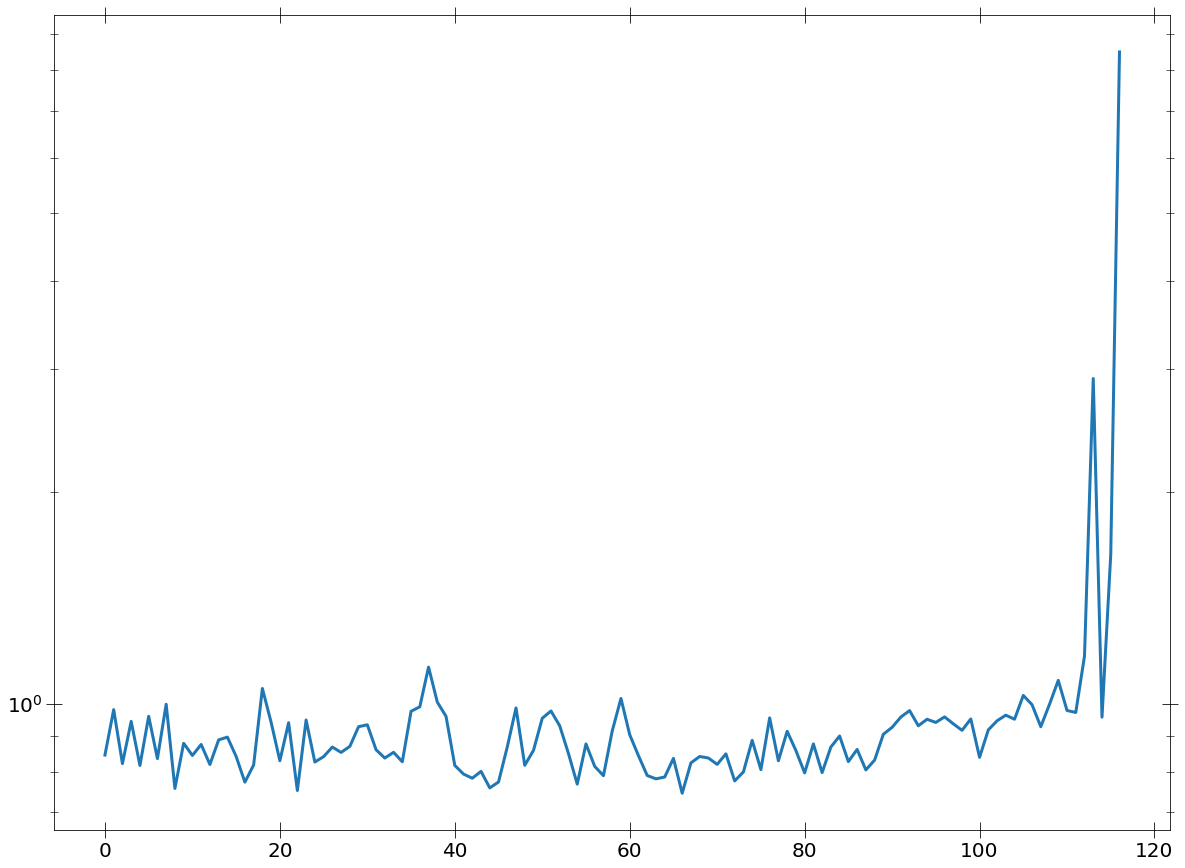

1:62: E225 missing whitespace around operator
2:80: E501 line too long (112 > 79 characters)


In [298]:
plt.plot((np.array(pn_fit_stats_table_pl)[:, 1].astype(float)/
          np.array(pn_fit_stats_table_pl)[:, -1].astype(float))[np.where(aic_pl_arr[0] < aic_pl_g3_arr[0] - 2)])
plt.yscale('log')

In [297]:
len(np.where(aic_pl_arr[0] < aic_pl_g3_arr[0] - 2)[0])


117

In [271]:
print(len(candidate_srcs_mos))
candidate_srcs_mos

66


array(['202026707015155', '204003401010008', '206556701010016',
       '206556701010040', '206946416010014', '208016803010003',
       '208860207010005', '202026707010160', '206043007010211',
       '206735502010030', '206735502010035', '206735502010047',
       '206735502010048', '206735502010049', '206735502010062',
       '206735502010080', '206735502010100', '206946409010023',
       '206946410010029', '208016804010004', '201129715010017',
       '204003401010007', '208016813010003', '201529201010011',
       '202026707010169', '202026707010179', '202026707010221',
       '202026707010240', '202026707010278', '204105804010009',
       '205049406010006', '206586001010095', '206586001010113',
       '206586001010146', '206735502010018', '206735502010024',
       '205100104010002', '206946401010003', '208860108010001',
       '202026707010062', '202026707010124', '202026707015191',
       '201129707010063', '202026707010170', '202026707010181',
       '207234104010049', '2010326130100

In [302]:
print(len(candidate_srcs_acis))
np.sort(candidate_srcs_acis)

157


array(['2CXOJ174405.3-292031', '2CXOJ174429.4-285531',
       '2CXOJ174431.9-290508', '2CXOJ174433.0-284426',
       '2CXOJ174442.9-292048', '2CXOJ174454.1-285841',
       '2CXOJ174457.4-285020', '2CXOJ174502.3-285449',
       '2CXOJ174503.8-290051', '2CXOJ174505.4-285934',
       '2CXOJ174507.0-290357', '2CXOJ174508.6-285652',
       '2CXOJ174508.6-285939', '2CXOJ174511.8-290032',
       '2CXOJ174512.3-285901', '2CXOJ174512.8-290340',
       '2CXOJ174513.9-285916', '2CXOJ174514.1-285425',
       '2CXOJ174515.0-285914', '2CXOJ174515.1-290016',
       '2CXOJ174515.7-290222', '2CXOJ174516.1-290425',
       '2CXOJ174516.7-290407', '2CXOJ174518.6-290010',
       '2CXOJ174520.2-291044', '2CXOJ174520.3-290634',
       '2CXOJ174520.5-290501', '2CXOJ174521.2-290652',
       '2CXOJ174521.3-285953', '2CXOJ174523.8-290653',
       '2CXOJ174524.3-285705', '2CXOJ174525.2-285404',
       '2CXOJ174526.8-285926', '2CXOJ174526.8-290702',
       '2CXOJ174527.5-290513', '2CXOJ174527.6-290423',
       '2C

In [74]:
def arr_to_str(arr, type='name'):
    string = ''
    for element in arr:
        if type == 'name':
            element = element.split('J')[0] + ' J' + element.split('J')[1]
        string += str(element) + '; '
    return string[:-2]

In [90]:
interested_srcs_xmm = np.array(list(set(interested_srcs_alldet[0]) | set(interested_srcs_alldet[1])))

In [85]:
candidate_srcs_xmm = np.array(list(set(candidate_srcs_pn) | set(candidate_srcs_mos)))

In [92]:
len(candidate_srcs_xmm)

74

In [93]:
len(interested_srcs_xmm)

197

In [89]:
arr_to_str(candidate_srcs_xmm, type=None)

'208860108010001; 208441011010001; 204003401010003; 205110012010053; 208861209010009; 201129721010057; 202026707010271; 207242102010146; 207234103010051; 201529201010091; 202026707010124; 201529201010060; 202026705010003; 207901804015015; 202026707015146; 206946401010004; 207436309010072; 207901804010060; 207901804010064; 202026707015191; 201129721010014; 205110012010028; 201129707010057; 201129707010063; 207901804010036; 202026707010170; 208016813010003; 208860107010001; 201529201010094; 207901804010019; 201032613010001; 201129721010060; 207901804010066; 207234103010061; 202026707010181; 206946401010003; 205110012010001; 208042503010002; 202026707010187; 201129702010002; 207901804010056; 207234104010049; 207901804015034; 205110012010017; 205100104010002; 201129705010011; 208624707010017; 204003401010007; 202026707010062; 207901804010033; 206586001010073; 206946402010009; 201129721010133; 201032613010002; 205049406010002; 205110012010055; 207901804010045; 201129701010015; 2072341030100

(array([  0,   5,   8,  13,  22,  26,  31,  32,  53,  60,  65,  91,  94,
       101, 104, 106, 139, 143, 146, 155, 157, 164, 168, 175, 178, 180,
       181, 183, 195, 212, 236, 237, 241, 242, 243, 267, 274, 275, 278,
       279, 280, 281, 282, 283, 284, 288, 315, 322, 324, 326, 338, 344,
       345, 356, 360, 361, 366, 367, 387, 392, 394, 402, 404, 405, 418,
       421, 423, 424, 425, 447, 479, 481, 487, 490, 503, 504, 522, 534,
       535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 548, 550,
       551, 557, 568, 586, 604, 608, 613, 628, 630, 632, 635, 636, 648,
       660, 661, 672, 686, 692, 695, 698, 699, 722, 733, 735, 737, 740]),)
['200305401010008' '200305401015015' '201032613010002' '201113501010117'
 '201129701010015' '201129701010028' '201129701010051' '201129702010002'
 '201129704010031' '201129704010056' '201129705010011' '201129707010018'
 '201129707010031' '201129707010046' '201129707010057' '201129707010063'
 '201129715010042' '201129719010003' '201129719010010' '

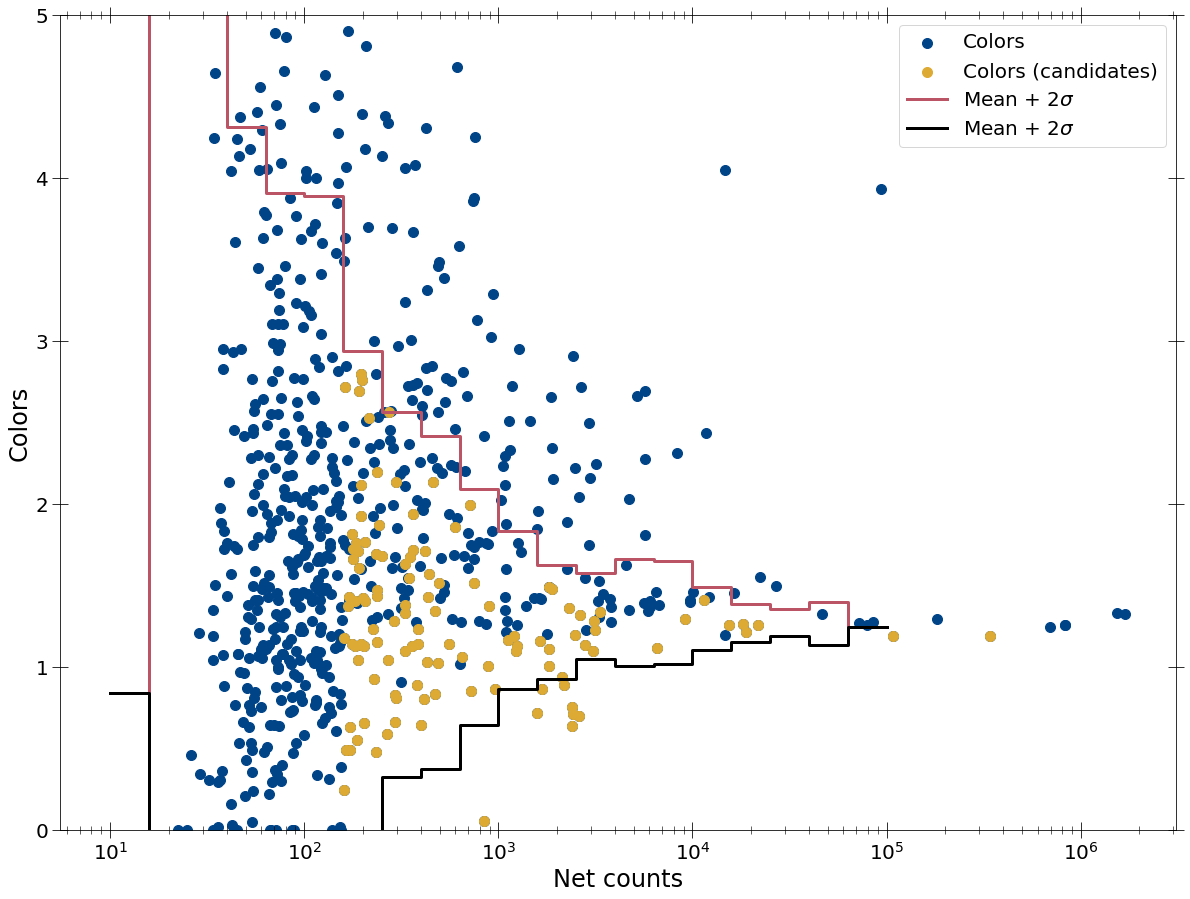

2:22: E128 continuation line under-indented for visual indent
2:80: E501 line too long (83 > 79 characters)
3:22: E128 continuation line under-indented for visual indent


In [303]:
test = mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn, 0)

(array([  4,  20,  46,  47,  69,  72,  79,  84,  89,  94,  97, 102, 105,
       107, 115, 121, 123, 128, 139, 142, 143, 144, 145, 160, 163, 169,
       170, 171, 180, 197, 201, 215, 218, 227, 228, 230, 251, 259, 260,
       264, 270, 277, 279, 280, 282, 283, 284, 285, 286, 287, 288, 290,
       292, 296, 298, 312, 313, 314, 315, 316, 317, 319, 320, 322, 324,
       326, 333, 334, 338, 339, 340, 345, 346, 347, 349, 352, 353, 362,
       367, 375, 380, 387, 388, 404, 414, 426, 441, 442, 444]),)
['201032613010002' '201129702010002' '201129705010002' '201129705010011'
 '201129707010045' '201129707010063' '201129708010036' '201129709010018'
 '201129715010017' '201129719010003' '201129719010010' '201129721010014'
 '201129721010057' '201129721010060' '201442201010001' '201529201010020'
 '202026705010003' '202026707015155' '203032102010002' '203032102010013'
 '204003401010003' '204003401010007' '204003401010008' '205100104010002'
 '205110012010001' '206556701010016' '206556701010023' '20655670

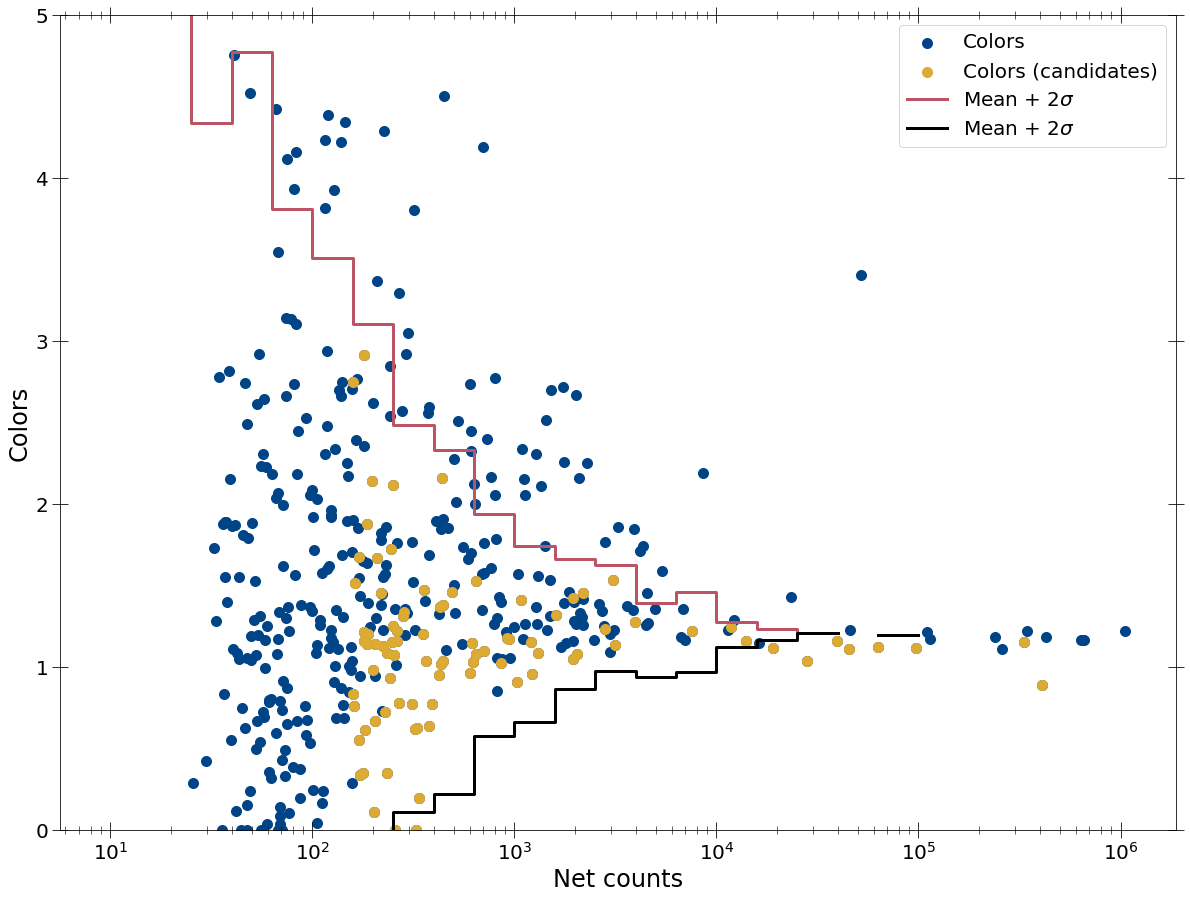

2:80: E501 line too long (83 > 79 characters)


In [304]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_mos, 0)

(array([  90,  130,  163,  165,  178,  223,  246,  389,  402,  806, 1001,
       1053, 1073, 1075, 1187, 1200, 1248, 1279, 1329, 1362, 1375, 1381,
       1390, 1408, 1419, 1420, 1474, 1489, 1499, 1527, 1541, 1555, 1562,
       1563, 1573, 1575, 1586, 1612, 1618, 1649, 1666, 1672, 1703, 1705,
       1706, 1761, 1820, 1829, 1877, 1880, 1889, 2012, 2210, 2225, 2260,
       2285, 2413, 2431, 2440, 2458, 2465, 2503, 2522, 2529, 2536, 2543,
       2570, 2603]),)
['2CXOJ174433.0-284426' '2CXOJ174454.1-285841' '2CXOJ174502.3-285449'
 '2CXOJ174503.8-290051' '2CXOJ174508.6-285652' '2CXOJ174512.3-285901'
 '2CXOJ174514.1-285425' '2CXOJ174520.5-290501' '2CXOJ174521.2-290652'
 '2CXOJ174530.0-285943' '2CXOJ174532.6-290118' '2CXOJ174533.4-285617'
 '2CXOJ174533.6-285930' '2CXOJ174533.6-290140' '2CXOJ174535.5-290124'
 '2CXOJ174535.7-290004' '2CXOJ174536.4-290043' '2CXOJ174536.9-290039'
 '2CXOJ174537.8-285908' '2CXOJ174538.1-290047' '2CXOJ174538.3-290048'
 '2CXOJ174538.4-290044' '2CXOJ174538.5-290136' '2

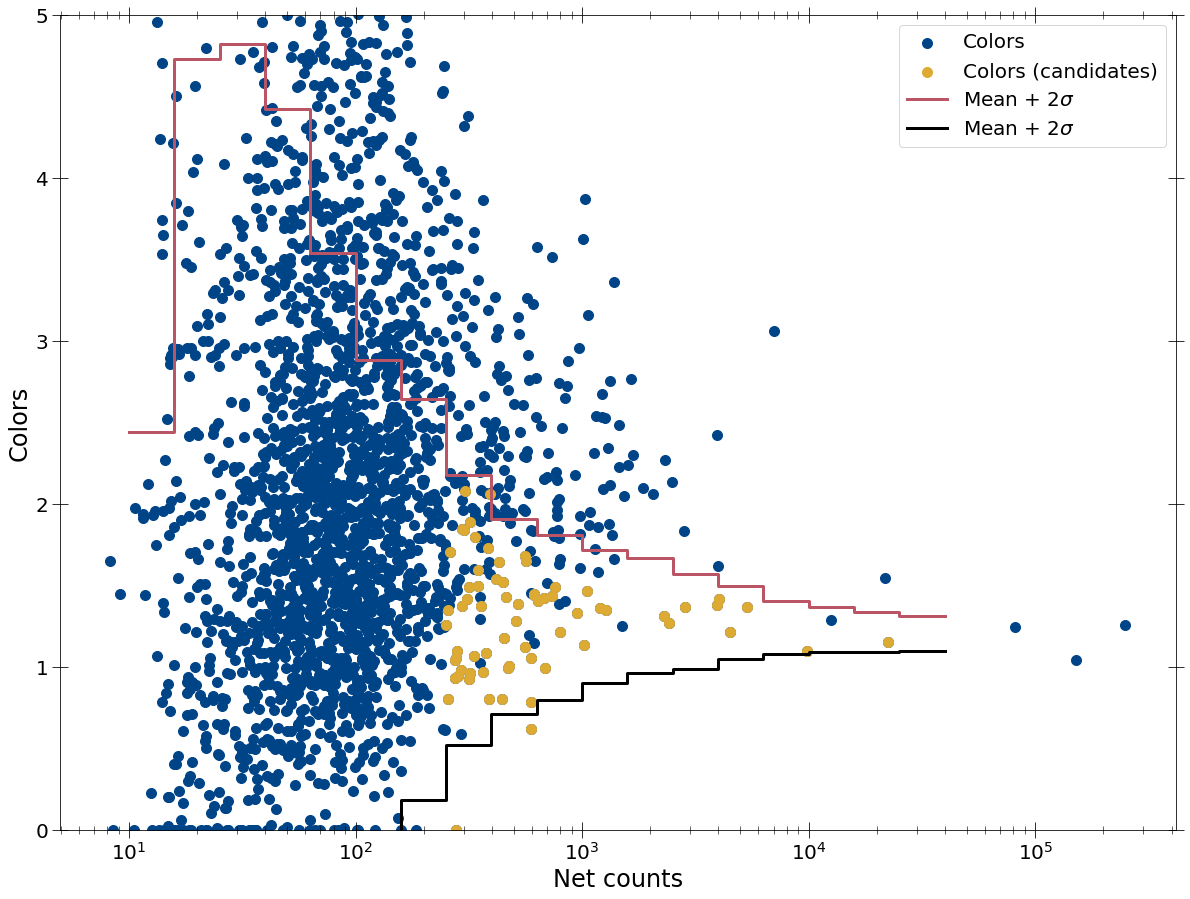

2:80: E501 line too long (83 > 79 characters)


In [83]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis, 0)

(array([  5,   8,  13,  26,  32,  53,  60,  65,  91,  94, 101, 104, 106,
       155, 157, 164, 168, 178, 183, 195, 212, 236, 242, 243, 274, 275,
       278, 279, 280, 281, 282, 283, 288, 322, 344, 356, 366, 367, 387,
       392, 394, 402, 404, 405, 418, 421, 423, 424, 425, 479, 481, 487,
       490, 503, 504, 522, 535, 536, 537, 538, 539, 541, 542, 543, 544,
       545, 548, 550, 551, 557, 568, 586, 604, 628, 630, 632, 635, 636,
       648, 660, 661, 692, 698, 722, 735, 740]),)
['200305401015015' '201032613010002' '201113501010117' '201129701010028'
 '201129702010002' '201129704010031' '201129704010056' '201129705010011'
 '201129707010018' '201129707010031' '201129707010046' '201129707010057'
 '201129707010063' '201129721010057' '201129721010060' '201129721010133'
 '201442201010001' '201529201010060' '202026705010003' '202026707010271'
 '203017301010002' '203032102010002' '204003401010007' '204003401010008'
 '205100104010002' '205100104010019' '205110012010001' '205110012010017'
 '2051

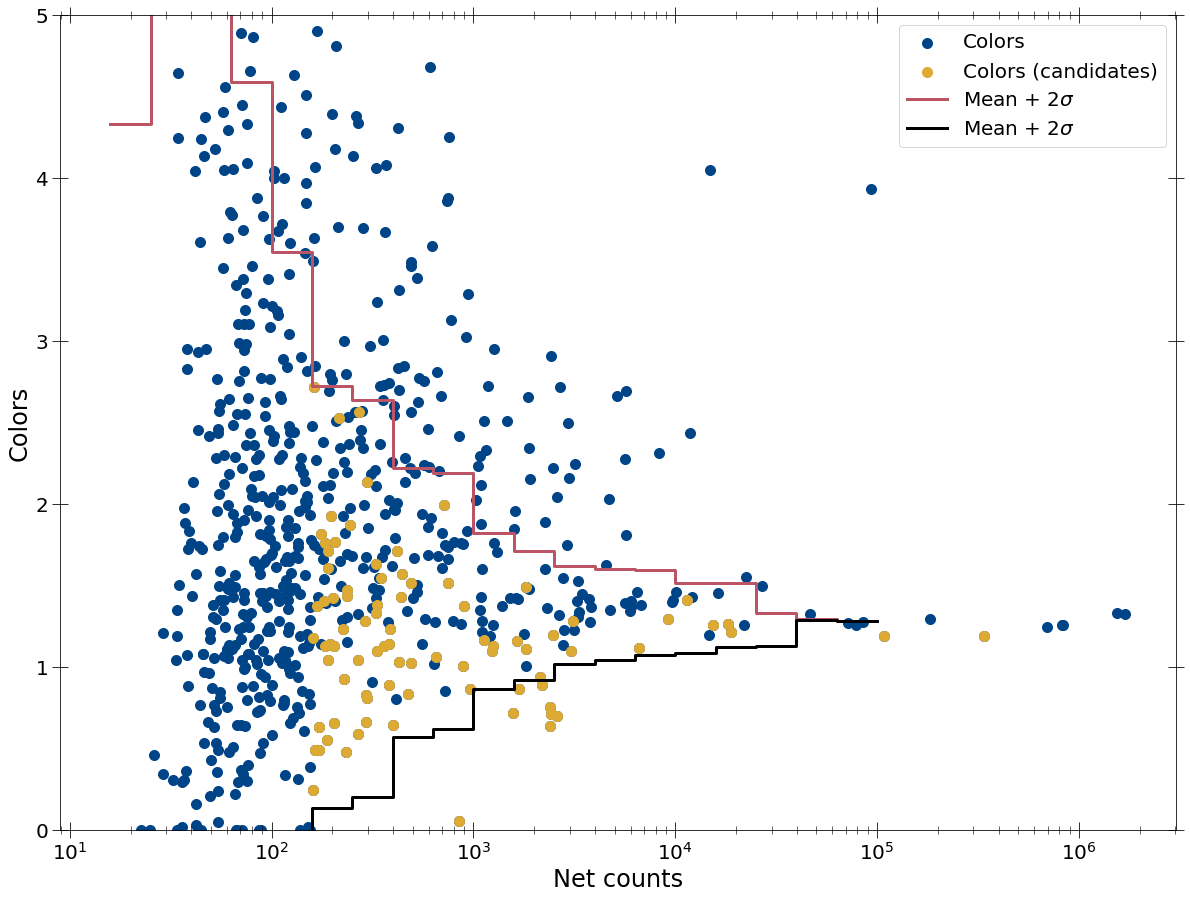

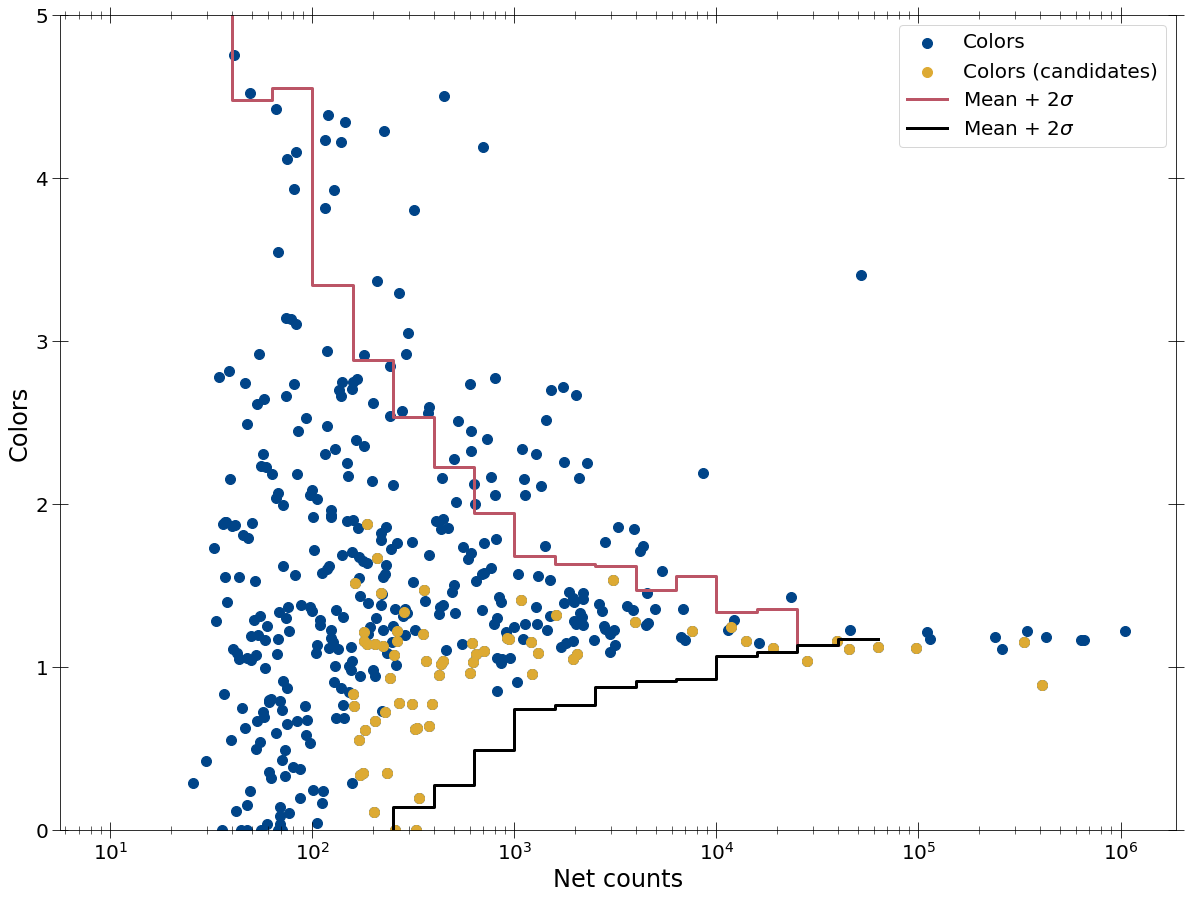

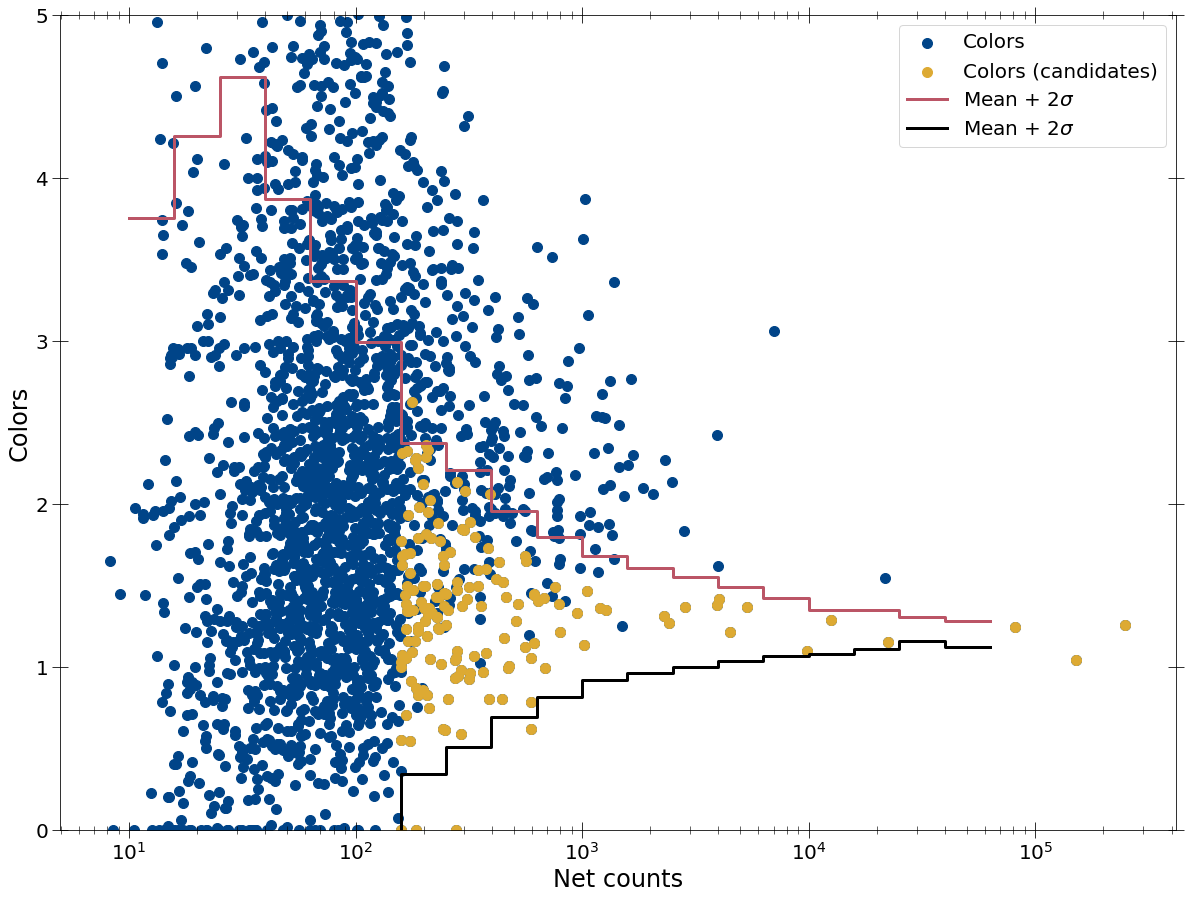

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (83 > 79 characters)
4:80: E501 line too long (82 > 79 characters)
5:80: E501 line too long (83 > 79 characters)
7:80: E501 line too long (82 > 79 characters)
8:80: E501 line too long (83 > 79 characters)


In [276]:
mark_interested_srcs(sim_color_dict_arr_clipped[0], obs_color_dict_arr_clipped[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[1], obs_color_dict_arr_clipped[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_mos, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[2], obs_color_dict_arr_clipped[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis, 0)

In [169]:
np.where(interested_srcs_alldet[2] == '2CXOJ174534.3-290231')

(array([], dtype=int64),)

In [285]:
print(acis_fit_stats_table_pl[125])
print(acis_fit_stats_table_pl_g[125])
print(acis_fit_stats_table_pl_g2[125])
print()
print(acis_fit_stats_table_pl[208])
print(acis_fit_stats_table_pl_g[208])
print(acis_fit_stats_table_pl_g2[208])
print()
print(acis_fit_stats_table_pl[133])
print(acis_fit_stats_table_pl_g[133])
print(acis_fit_stats_table_pl_g2[133])
print()
print(acis_fit_stats_table_pl[46])
print(acis_fit_stats_table_pl_g[46])
print(acis_fit_stats_table_pl_g2[46])
print()
print(acis_fit_stats_table_pl[88])
print(acis_fit_stats_table_pl_g[88])
print(acis_fit_stats_table_pl_g2[88])
print()
print(acis_fit_stats_table_pl[188])
print(acis_fit_stats_table_pl_g[188])
print(acis_fit_stats_table_pl_g2[188])

['2CXOJ174540.3-290049', 266.01879656001785, -7.589646752720701, 50.0, 299]
['2CXOJ174540.3-290049', 264.6833556689429, -7.805990677928118, 50.0, 297]
['2CXOJ174540.3-290049', 263.92879916841827, -7.8578460350119865, 50.0, 296]

['2CXOJ174536.9-290039', 344.5620739732016, -9.526574126034008, 50.0, 389]
['2CXOJ174536.9-290039', 341.77998992125424, -9.871299609625027, 50.0, 387]
['2CXOJ174536.9-290039', 340.80402348470886, -9.916018231068454, 50.0, 386]

['2CXOJ174535.7-290004', 219.3432290242929, -8.32886982476195, 50.0, 254]
['2CXOJ174535.7-290004', 216.10212421697082, -8.175803506918273, 50.0, 252]
['2CXOJ174535.7-290004', 216.40324068904283, -8.163633107538715, 50.0, 251]

['2CXOJ174543.2-290003', 168.34505326473322, -7.38207827477904, 50.0, 262]
['2CXOJ174543.2-290003', 166.74607251218066, -7.295869408022453, 50.0, 260]
['2CXOJ174543.2-290003', 167.088320724579, -7.364177348527165, 50.0, 259]

['2CXOJ174535.0-285757', 140.70723931932093, -7.684272731913274, 50.0, 193]
['2CXOJ174535.

In [157]:
print(acis_model_params_table_pl_g2[125])
print(acis_model_params_table_pl_g2[208])
print(acis_model_params_table_pl_g2[133])
print(acis_model_params_table_pl_g2[46])
print(acis_model_params_table_pl_g2[88])
print(acis_model_params_table_pl_g2[188])

['2CXOJ174540.3-290049', 14.747172266857492, 2.284559245444103, 0.014014393023623173, 3.157876082859608e-08, 1.936457506907927e-08, 4.298694332175304e-19, 0.0, 8.242343569531286e-08, 0.0, 7.391659902986237e-08, 0.0, 3.2311902308687976e-08]
['2CXOJ174536.9-290039', 32.91698126831548, 2.169538475539656, 0.13824128530453256, 5.4557158152566107e-14, 1.4314730567579634e-07, 7.4035496908206e-08, 0.0, 1.1265319696324751e-07, 0.0, 3.059586290967107e-07, 0.0, 2.3806088884467742e-07]
['2CXOJ174535.7-290004', 25.294693190701558, 1.6423470508550815, 0.040934446317875135, 8.531655806100725e-08, 3.5908650704885276e-08, 1.1327547386683504e-08, 0.0, 1.9846436077281447e-07, 0.0, 1.5934190141787257e-07, 0.0, 1.3669784512889456e-07]
['2CXOJ174543.2-290003', 57.451790453056155, 4.999999999999999, 0.3025621014701397, 6.405396701097331e-22, 1.716821005151346e-19, 1.2932393486615652e-07, 0.0, 1.4473062790960989e-07, 0.0, 2.977575924227808e-07, 0.0, 3.5802429139269943e-07]
['2CXOJ174535.0-285757', 16.72445583

(array([ 200,  692,  806,  990, 1051, 1199, 1665, 1685, 1702]),)
['2CXOJ174534.3-290231' '2CXOJ174546.2-290003' '2CXOJ174538.1-290319'
 '2CXOJ174535.7-290004' '2CXOJ174543.2-290003' '2CXOJ174532.9-290110'
 '2CXOJ174535.0-285757' '2CXOJ174527.8-290210' '2CXOJ174544.1-285940']
[176.43000154  68.51315789 148.93362531 333.82959801 176.07171884
  69.72756558 160.74684514 452.65052956  15.82249253]
[2.8743079         inf 0.88800633 1.79911604 0.7109796  2.33402784
 1.63259623 1.30960658        inf]


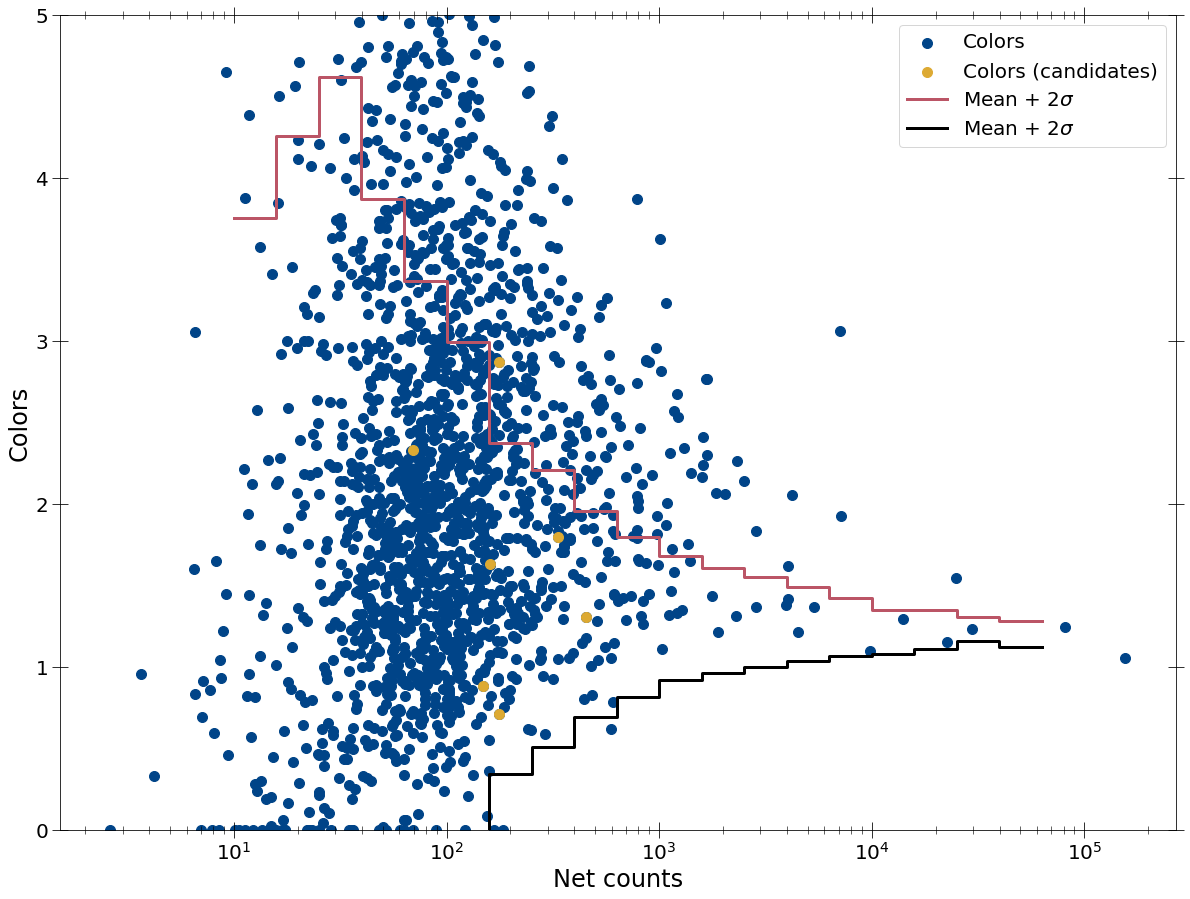

2:80: E501 line too long (83 > 79 characters)


In [168]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     ['2CXOJ174543.2-290003', '2CXOJ174535.7-290004',
                      '2CXOJ174544.1-285940', '2CXOJ174546.2-290003',
                      '2CXOJ174532.9-290110', '2CXOJ174534.3-290231',
                      '2CXOJ174535.0-285757', '2CXOJ174538.1-290319', '2CXOJ174527.8-290210'], 0)

(array([ 678,  840,  990, 1335]),)
['2CXOJ174540.3-290049' '2CXOJ174536.9-290039' '2CXOJ174535.7-290004'
 '2CXOJ174536.1-285638']
[ 309.98665049 1113.49755019  333.82959801 7063.35067975]
[1.41798004 1.31906731 1.79911604 3.06266218]


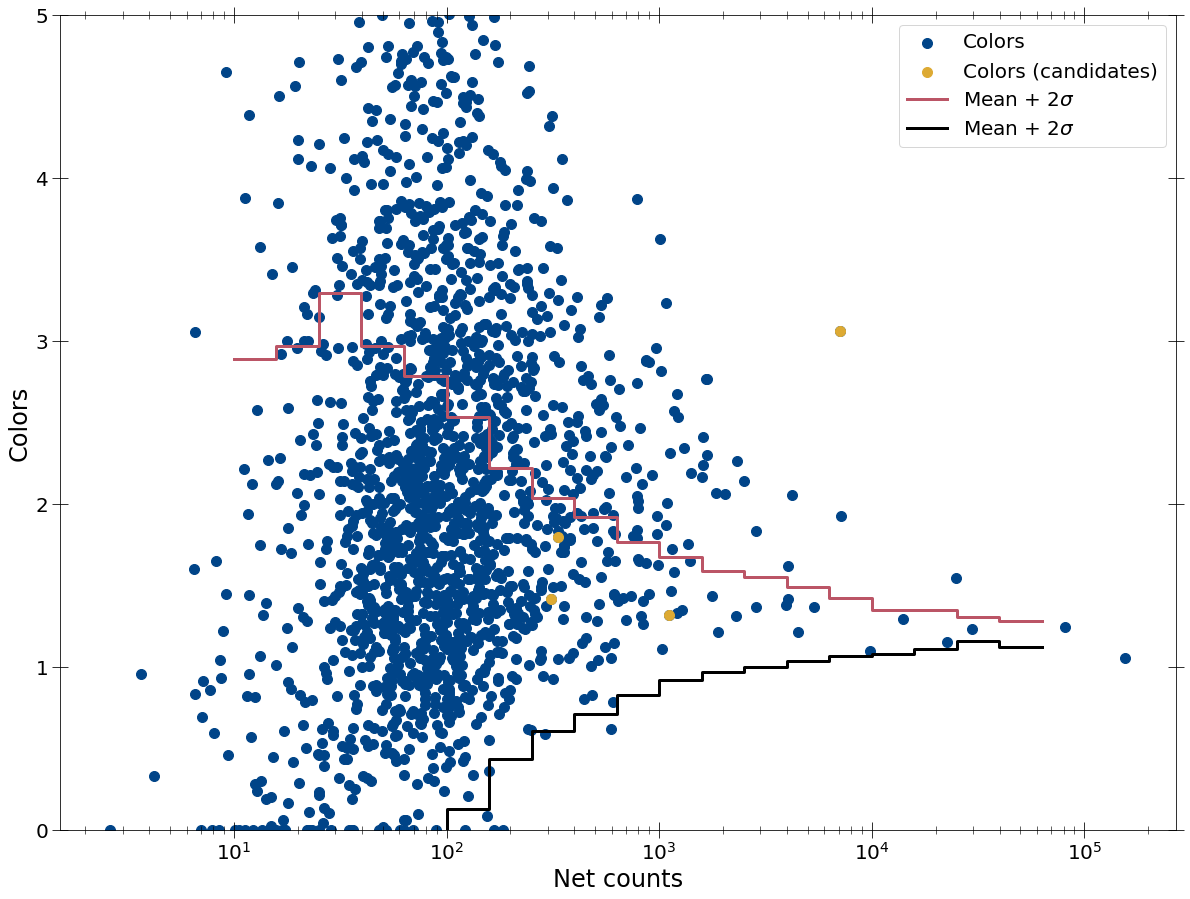

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (83 > 79 characters)


In [167]:
mark_interested_srcs(sim_color_dict_arr_clipped[2], obs_color_dict_arr_clipped[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     ['2CXOJ174540.3-290049', '2CXOJ174536.9-290039',
                      '2CXOJ174535.7-290004', '2CXOJ174536.1-285638',
                      '2CXOJ174532.7-285616', '2CXOJ174610.5-285550'], 0)

In [289]:
np.savetxt('ACIS_interested_plmodels.txt', acis_model_params_table_pl, fmt='%s')
np.savetxt('ACIS_interested_g2models.txt', acis_model_params_table_pl_g2, fmt='%s')

1:80: E501 line too long (80 > 79 characters)


# Checking for low norm sources

In [277]:
acis_model_g2_arr = np.array(acis_model_params_table_pl_g2)
zero_norms_args = np.where(np.logical_and(np.logical_and(
    np.logical_or(
        acis_model_g2_arr[:, 7].astype(float) == 0,
        acis_model_g2_arr[:, 7].astype(float) >= acis_model_g2_arr[:, 4].astype(float)),
    np.logical_or(
        acis_model_g2_arr[:, 9].astype(float) == 0,
        acis_model_g2_arr[:, 9].astype(float) >= acis_model_g2_arr[:, 5].astype(float))),
    np.logical_or(
        acis_model_g2_arr[:, 11].astype(float) == 0,
        acis_model_g2_arr[:, 11].astype(float) >= acis_model_g2_arr[:, 6].astype(float))))[0]

5:80: E501 line too long (88 > 79 characters)
8:80: E501 line too long (89 > 79 characters)


In [278]:
high_norms_args = np.where(np.logical_or(np.logical_or(
    acis_model_g2_arr[:, 7].astype(float) >= acis_model_g2_arr[:, 4].astype(float),
    acis_model_g2_arr[:, 9].astype(float) >= acis_model_g2_arr[:, 5].astype(float)),
    acis_model_g2_arr[:, 11].astype(float) >= acis_model_g2_arr[:, 6].astype(float)))[0]

2:80: E501 line too long (83 > 79 characters)
3:80: E501 line too long (84 > 79 characters)


In [279]:
len(high_norms_args)

29

In [247]:
zero_norm_args = np.append(zero_norms_args.copy(), high_norms_args)

In [280]:
len(zero_norms_args)

144

In [281]:
np.min((aic_pl_g3_arr[2] - aic_pl_arr[2])[zero_norms_args])

0.8924075464469752

In [258]:
print(acis_fit_stats_table_pl[117])
print(acis_fit_stats_table_pl_g2[117])

['2CXOJ174601.1-285952', 273.95609098450296, -7.238976643444733, 50.0, 270]
['2CXOJ174601.1-285952', 250.28253432384366, -8.420395729866275, 50.0, 267]


In [259]:
print(acis_model_params_table_pl[117])
print(acis_model_params_table_pl_g2[117])

['2CXOJ174601.1-285952', 15.645019663669181, 0.551782037874522, 0.03696465499752591]
['2CXOJ174601.1-285952', 19.737789482731742, 1.5997676215429104, 0.0331508926935257, 1.6215554900609572e-07, 2.6901888734595366e-07, 2.995211254045239e-08, 5.937151313098362e-08, 2.905464964537258e-07, 1.33223904033065e-07, 4.348939115214157e-07, 0.0, 1.7693666605934802e-07]


In [282]:
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2])[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 1.39)[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 3.0)[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 4.0)[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 4.605)[0]))

199
164
132
102
85


In [286]:
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args])[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 1.0)[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 3.0)[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 4.0)[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 4.605)[0]))

1:80: E501 line too long (91 > 79 characters)
2:80: E501 line too long (97 > 79 characters)
3:80: E501 line too long (97 > 79 characters)
4:80: E501 line too long (97 > 79 characters)


144
143
127
102
85


In [281]:
zero_norms_args

array([  0,   1,   3,   4,  10,  12,  13,  16,  17,  18,  19,  20,  24,
        27,  31,  32,  33,  34,  37,  38,  39,  43,  45,  46,  47,  48,
        51,  53,  54,  56,  59,  61,  62,  65,  67,  68,  70,  73,  74,
        76,  77,  80,  82,  83,  84,  85,  87,  88,  89,  90,  91,  93,
        94,  95,  97,  99, 100, 103, 104, 106, 107, 109, 115, 119, 121,
       123, 124, 125, 128, 129, 130, 132, 133, 134, 136, 139, 141, 143,
       144, 146, 148, 149, 150, 156, 158, 160, 162, 164, 166, 167, 168,
       171, 173, 175, 177, 178, 180, 181, 182, 183, 184, 185, 188, 189,
       190, 191, 193, 195, 197, 198, 199, 200, 203, 208, 209, 210, 212,
       213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227])

In [284]:
acis_model_g2_arr[219]

array(['2CXOJ174535.5-290124', '30.35200191082754', '1.4425701490713667',
       '0.47630799807558655', '1.89602805783651e-08',
       '2.8201094011909062e-24', '7.408528059108422e-24', '0.0',
       '2.3455091875304955e-07', '0.8224962005991274', '0.0',
       '0.8224962005991274', '0.0'], dtype='<U32')

In [282]:
np.where(np.logical_and(aic_pl_arr[2] < aic_pl_g3_arr[2] - 3.0,
                        acis_model_g2_arr[:, 11].astype(float) != 0))[0]

array([  3,   4,  17,  19,  27,  97, 109, 113, 132, 162, 178, 190, 191,
       219, 223, 224, 225, 226, 227])

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


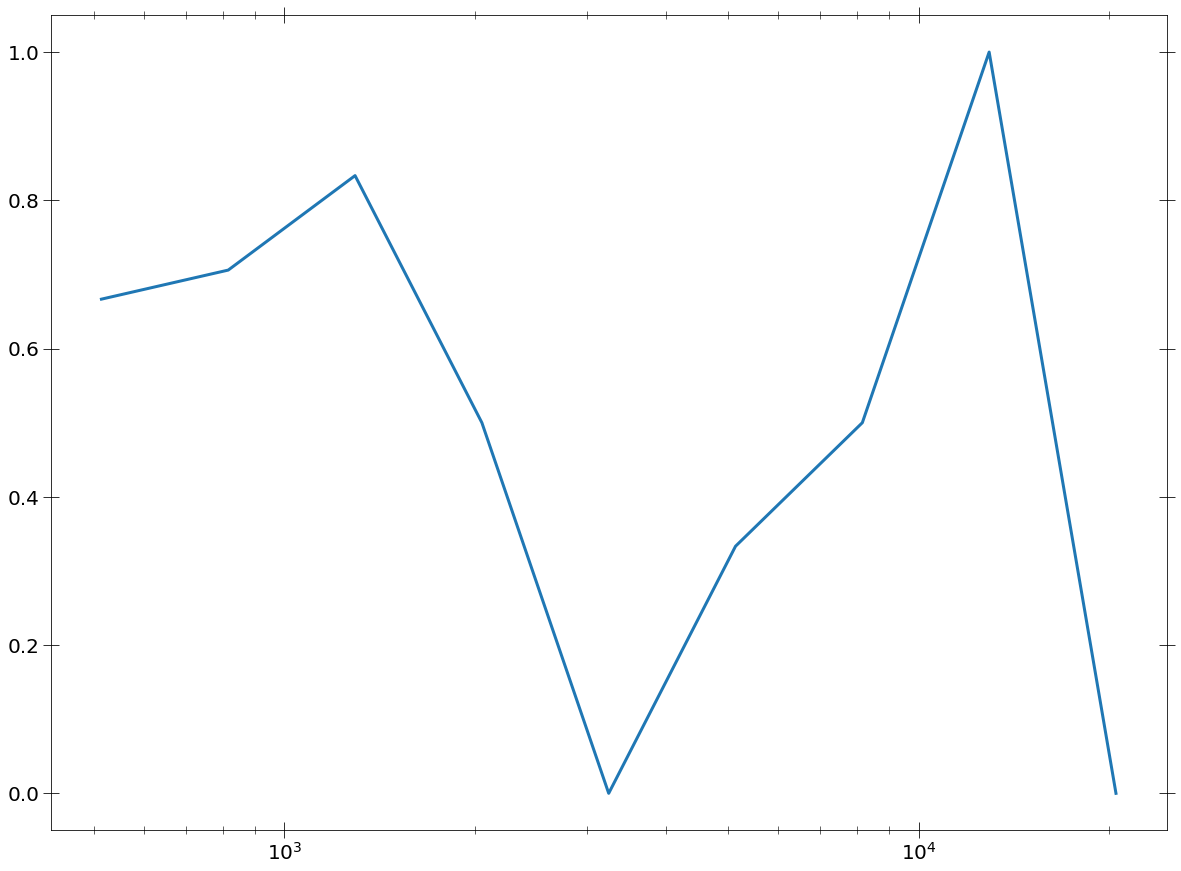

In [451]:
plt.plot(0.5*(bins[1:] + bins[:-1]), candidate_hist/interested_hist)
plt.xscale('log')

In [441]:
len(sim_color_dict_arr[0]['prop_bins'][0])

21

In [452]:
candidate_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 12, 12,  5,  1,  0,  1,  1,  3,  0,
        0,  0,  0])

In [453]:
interested_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 18, 17,  6,  2,  1,  3,  2,  3,  2,
        0,  0,  0])

In [449]:
bins

array([1.00000000e+01, 1.58489319e+01, 2.51188643e+01, 3.98107171e+01,
       6.30957344e+01, 1.00000000e+02, 1.58489319e+02, 2.51188643e+02,
       3.98107171e+02, 6.30957344e+02, 1.00000000e+03, 1.58489319e+03,
       2.51188643e+03, 3.98107171e+03, 6.30957344e+03, 1.00000000e+04,
       1.58489319e+04, 2.51188643e+04, 3.98107171e+04, 6.30957344e+04,
       1.00000000e+05])

In [454]:
fit_stats_pl_arr = np.array(mos_fit_stats_table_pl)
fit_stats_pl_gauss_arr = np.array(mos_fit_stats_table_pl_g)

aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10

candidate_args = interested_args_alldet[1][np.where(aic_pl > aic_pl_gauss)]
candidate_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][candidate_args]
interested_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][interested_args_alldet[1]]

candidate_hist, bins = np.histogram(candidate_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])
interested_hist, bins = np.histogram(interested_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])

IndexError: index 38 is out of bounds for axis 0 with size 38

8:80: E501 line too long (103 > 79 characters)
9:80: E501 line too long (115 > 79 characters)
11:80: E501 line too long (100 > 79 characters)


In [455]:
len(fit_stats_pl_arr)

57

In [456]:
len(mos_fit_stats_table_pl)

57

In [459]:
np.sort(interested_srcs_alldet[0])

array(['201113501010010', '201113501010035', '201113501010066',
       '201113501010154', '201113501010169', '201113503010004',
       '201129701010011', '201129701010015', '201129701010027',
       '201129701010041', '201129702010002', '201129704010011',
       '201129704010019', '201129704010027', '201129705010011',
       '201129705010015', '201129705010038', '201129705010067',
       '201129705010076', '201129705010079', '201129705015062',
       '201129706010014', '201129707010012', '201129707010063',
       '201129707010079', '201129709010024', '201129715010041',
       '201129719010010', '201129721010003', '201129721010009',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010035', '201129721010044', '201129721010057',
       '201129721010060', '201129721010063', '201129721010070',
       '201129721010078', '201129721010126', '201129721010133',
       '201129721015131', '202026705010034', '202026705010109',
       '202026708010021', '2030321020100

In [460]:
np.sort(interested_srcs_alldet[1])

array(['200305402010002', '201113501010010', '201113501010069',
       '201113501010114', '201113503010004', '201129701010035',
       '201129702010002', '201129704010048', '201129705010011',
       '201129705010014', '201129705010024', '201129705010067',
       '201129705010079', '201129705010095', '201129705015062',
       '201129706010014', '201129707010063', '201129708010036',
       '201129719010010', '201129721010003', '201129721010005',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010045', '201129721010053', '201129721010057',
       '201129721010060', '201129721010075', '201129721010138',
       '202026705010053', '204105804015018', '206556701010012',
       '206556701010019', '206946404010008', '207641904010001',
       '208016803010001', '208251401010006'], dtype=object)

In [69]:
def get_candidate_src_nums_det2(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    interested_args = []
    interested_srcs = []
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(obs_netcounts[int_args])
        interested_args.append(int_args)
        interested_srcs.append(obs_src_nums[obs_det_mask][int_args])
    return interested_args, interested_srcs


def get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


2:32: E128 continuation line under-indented for visual indent
23:21: E117 over-indented
27:1: W293 blank line contains whitespace
45:35: E128 continuation line under-indented for visual indent
54:80: E501 line too long (80 > 79 characters)
58:13: E122 continuation line missing indentation or outdented
59:13: E122 continuation line missing indentation or outdented


In [70]:
test_args, test_srcs = get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr, obs_color_dict_arr,
                                                      min_count_arr=[380, 380, 220])

[569.59489915 404.91355624 452.26180445 465.79990524 576.32276827
 493.39928098 487.52737681 463.48454887 513.71340716 539.95700063
 612.30372428 609.93432573 398.9688382  574.42562696 508.04667046
 592.28189506 435.03011623 522.26141993]
[652.69197128 823.33408827 792.69706455 674.18975953 876.79367389
 679.04689138 739.16724045 845.56868658 723.70611642 845.86782834
 764.06300906 648.50489117 711.53733848 864.90478044 817.363117
 923.15858478 648.64365916 797.95791783]
[1536.6024365  1114.66782348 1422.7130562  1291.96679205 1584.24987616
 1222.55308145]
[1989.78879578 2448.29069852]
[3333.91840967]
[5906.66947885 4300.15059039 5076.11064059]
[8272.89976422 7040.72877535]
[10372.3500844  14301.84303534 13285.45941   ]
[23304.51640767 18219.60240603]
[]
[]
[]
[ 736611.79761745  418037.54709113 2024254.48411136]
[608.05064636 440.51106749 493.03633815 438.03845112 598.07676261
 443.31577824 586.65762292 507.54544255 433.71040735 542.88105163
 402.12852783]
[743.55291637 648.44849731 71

1:80: E501 line too long (107 > 79 characters)


In [44]:
test_srcs

[[array(['201113501010066', '201113501010154', '201129701010015',
         '201129704010011', '201129704010019', '201129704010027',
         '201129707010012', '201129707010063', '201129709010024',
         '201129715010041', '201129721010070', '201129721010126',
         '204003401010007', '204105804010005', '206556701010012',
         '208016803010001', '208016813010003', '208251401010006'],
        dtype=object),
  array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  array(['201113501010035', '201129707010079', '201129721010063',
         '201129721010078', '201129721015131', '202026705010034'],
        dtype=object),
  ar

In [93]:
def combine_spec_analysis(int_srcs_list, source_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    spec_list = []
    for source_num in int_srcs_list:
        if telescope == 'XMM':
            spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                     str(source_num) + '_PN_combined_src_grp1*')
            spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                      str(source_num) + '_MOS_combined_src_grp1*')
            if len(spec_pnfile) > 0:
                spec_pn = xspec.Spectrum(spec_pnfile[0])
                spec_pn.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_pn)
                print(spec_pn.rate[0]*spec_pn.exposure)
            if len(spec_mosfile) > 0:
                spec_mos = xspec.Spectrum(spec_mosfile[0])
                spec_mos.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_mos)
                print(spec_mos.rate[0]*spec_mos.exposure)
        elif telescope == 'Chandra':
            os.chdir(src_folder + '/' + source_num)
            spec_file = str(source_num) + '_combined_src_grp1.pi'
            spec = xspec.Spectrum(spec_file)
            spec.ignore('0.0-2.0, 10.0-**')
            spec.notice('2.0-10.0')
            os.chdir(curr_dir)
        else:
            print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('2.706 2')
    xspec.Fit.perform()
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    
    xspec.Plot.device = '/xw'
    xspec.Plot.xAxis = 'keV'
    xspec.Plot.yLog = True
    xspec.Plot.setRebin(2, 1000, -1)
    xspec.Plot()
    print('Model params: '
          'NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats : ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([int_srcs_list, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [int_srcs_list, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

10:80: E501 line too long (80 > 79 characters)
12:80: E501 line too long (82 > 79 characters)
34:1: W293 blank line contains whitespace
44:5: E265 block comment should start with '# '
46:1: W293 blank line contains whitespace
61:80: E501 line too long (83 > 79 characters)


In [95]:
combine_spec_analysis(test_srcs[0][1])

654.4603630490105
824.1378576545412
716.8100536050601
795.4471140394922
220.3010253394772
673.1919534877306
806.0406733582817
877.330611434544
949.5044931691929
681.247948793877
162.2880763393362
736.751589007554
349.2025802477865
841.2293566233209
680.7494567901176
725.3070590144457
844.6655306385417
845.6103149179244
2153.566380181197
764.2810261818187
642.8417595934877
1078.7955794357108
711.3929357221539
864.5409737688612
113.31528293446061
815.8800274223036
923.4042521844088
74.37753238277094
649.1042695369483
797.4801613279265
586.9997543090454
Model params: NH =  13.231711938962313  Gamma:  0.9200176939172249  norm:  0.1632279364041732
Fit stats :  32184.51283053665 -6.530554835870103 50.0 29932




([array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  32184.51283053665,
  -6.530554835870103,
  50.0,
  29932],
 [array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  13.231711938962313,
  0.9200176939172249,
  0.1632279364041732])

In [88]:
spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([569.59489915, 404.91355624, 452.26180445, 465.79990524,
       576.32276827, 493.39928098, 487.52737681, 463.48454887,
       513.71340716, 539.95700063, 612.30372428, 609.93432573,
       398.9688382 , 574.42562696, 508.04667046, 592.28189506,
       435.03011623, 522.26141993])

In [80]:
spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([  77.06422098,  169.29402981,   80.75597502,  287.22584027,
        117.51882974,  131.66078883,   62.82256871,  493.03633815,
        226.05028649,  204.3105431 ,  115.47278273, -167.7485317 ,
        311.87986676, 1110.11849309,  443.31577824,  507.54544255,
        262.10215037,  433.71040735])

In [99]:
len(interested_srcs_alldet[2])

140

In [34]:
def fit_src_pl_gauss2(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    xspec.Xset.parallel.error = 4
    xspec.Xset.parallel.goodness = 4
    if telescope == 'XMM':
        spec_pnfile = glob2.glob(src_folder +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob(src_folder +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss+gauss+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.4 0'
    model.gaussian.Sigma.values = '0.0 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_4.LineE.values = '6.7 0'
    model.gaussian_4.Sigma.values = '0.0 0'
    model.gaussian_4.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_5.LineE.values = '7.0 0'
    model.gaussian_5.Sigma.values = '0.0 0'
    model.gaussian_5.norm.values = '1.0E-5, 0.001,,,,'
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('2.706 8')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 11')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 14')
    # xspec.Fit.error('2.706 8')
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    line_norm1_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm1_high = xspec.AllModels(1).gaussian.norm.error[1]
    line_norm2_low = xspec.AllModels(1).gaussian_4.norm.error[0]
    line_norm2_high = xspec.AllModels(1).gaussian_4.norm.error[1]
    line_norm3_low = xspec.AllModels(1).gaussian_5.norm.error[0]
    line_norm3_high = xspec.AllModels(1).gaussian_5.norm.error[1]
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_norms:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm1_low, line_norm1_high,
          xspec.AllModels(1).gaussian_4.norm.values[0], line_norm2_low,
          line_norm2_high, xspec.AllModels(1).gaussian_5.norm.values[0],
          line_norm3_low, line_norm3_high)
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.norm.values[0],
             xspec.AllModels(1).gaussian_4.norm.values[0],
             xspec.AllModels(1).gaussian_5.norm.values[0], line_norm1_low,
             line_norm1_high, line_norm2_low, line_norm2_high, line_norm3_low,
             line_norm3_high])


27:1: W293 blank line contains whitespace
42:1: W293 blank line contains whitespace
54:5: E265 block comment should start with '# '
75:80: E501 line too long (80 > 79 characters)


In [345]:
fit_src_pl_gauss2(interested_srcs_alldet[0][125])

Model params for 201129719010009: NH =  49.09545966807596  Gamma:  5.901436569190227e-07  norm:  1.6180422940868509  Fe_norms: 4.937682968507158e-06 2.9610772812057045e-06 7.153882470031282e-06 9.845990294269878e-18 0.0 1.05806955863098e-06 1.4620451121862783e-06 0.0 3.5136516612540593e-06
Fit stats for 201129719010009:  626.6786998273194 -7.9943285845749665 71.6 789




(['201129719010009', 626.6786998273194, -7.9943285845749665, 71.6, 789],
 ['201129719010009',
  49.09545966807596,
  5.901436569190227e-07,
  1.6180422940868509,
  4.937682968507158e-06,
  9.845990294269878e-18,
  1.4620451121862783e-06,
  2.9610772812057045e-06,
  7.153882470031282e-06,
  0.0,
  1.05806955863098e-06,
  0.0,
  3.5136516612540593e-06])

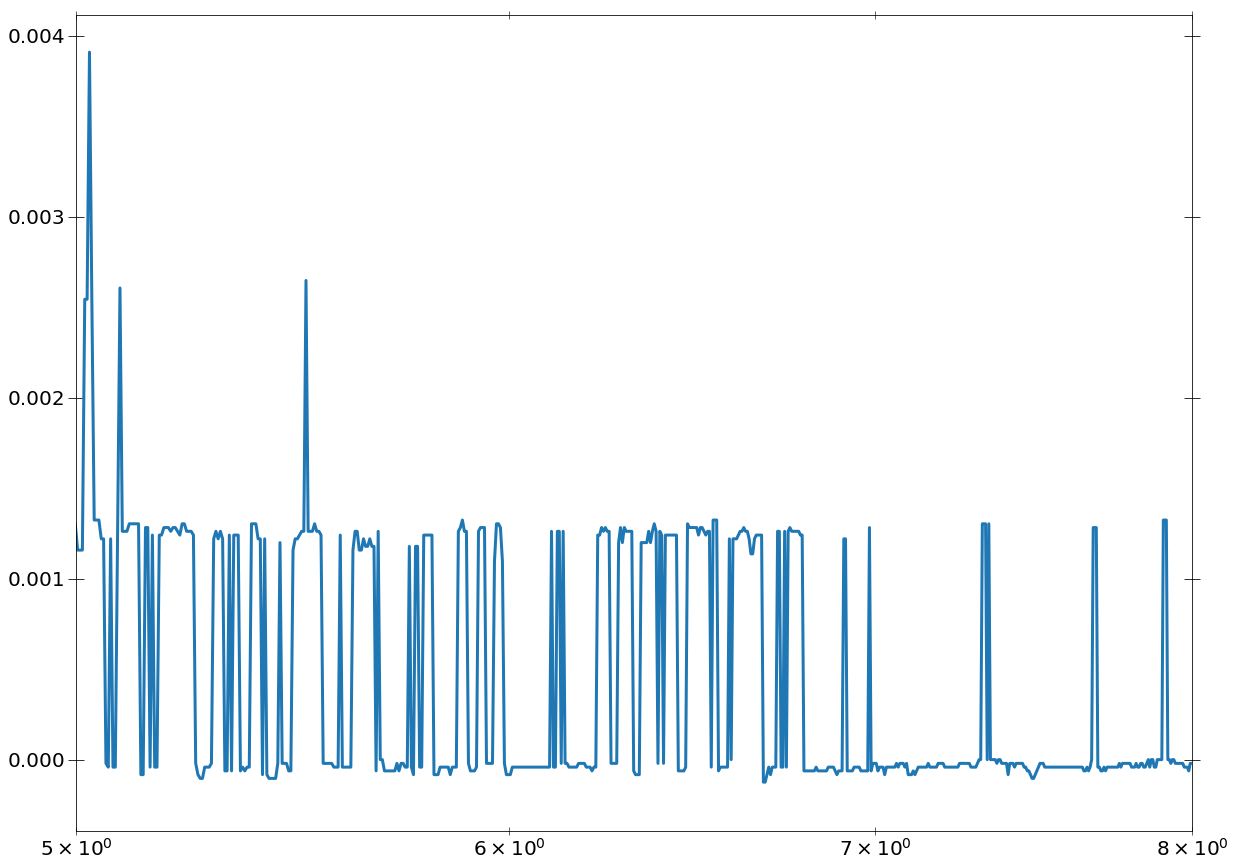

2:80: E501 line too long (130 > 79 characters)


In [62]:
plt.plot(spec_summary['ebins'][1][1][400:2000],
         median_filter(spec_summary['norm_specs'][1][1][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]], size=5))
plt.xlim(5.0, 8.0)
plt.xscale('log')

In [67]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]]

'200305402010002'

In [82]:
from astropy.table import Table
from astropy.table.pprint import conf
conf.max_lines = -1
conf.max_width = -1

In [83]:
Table(np.column_stack([np.array(pn_fit_stats_table_pl)[:, 0],
                       np.array(pn_fit_stats_table_pl_g2)[:, 4],
                       np.array(pn_fit_stats_table_pl)[:, 1],
                       np.array(pn_fit_stats_table_pl_g)[:, 1],
                       np.array(pn_fit_stats_table_pl_g2)[:, 1],
                       np.array(pn_model_params_table_pl_g)[:, 4],
                       np.array(pn_model_params_table_pl_g)[:, 7],
                       np.array(pn_model_params_table_pl_g2)[:, 4],
                       np.array(pn_model_params_table_pl_g2)[:, 5],
                       np.array(pn_model_params_table_pl_g2)[:, 6]]))

<Table length=58>
      col0       col1        col2               col3               col4               col5                 col6                   col7                   col8                   col9         
     str32      str32       str32              str32              str32              str32                str32                  str32                  str32                  str32         
--------------- ----- ------------------ ------------------ ------------------ ------------------ ---------------------- ---------------------- ---------------------- ----------------------
201113501010066  1097  888.3133866673959  881.7070650294453  881.1913228858143  6.495842098254313  5.728099295853509e-07  4.331544399555877e-07 1.9773822826801004e-07 1.5584199303060894e-07
201113501010154  1149  903.3608054015875  898.9897342154572  894.8121029186211  6.416690600469637  3.657184129034429e-07 3.5010040157522126e-07  4.580896096106657e-20 3.0838833914018393e-07
201129701010015   880  729.9447013450703  726.1680242153152   728.208293235638  6.878504435779244 2.8030459351071563e-07  6.557294646155204e-09  3.952180009005394e-08   1.84901608991034e-07
201129704010011  1194 1012.6079029890961 1002.1164436811466 1000.9736609156014  6.376259261068899  1.038662399360663e-06  7.930982457150612e-07  1.384644000570789e-07  4.940973238026691e-07
201129704010019  1215 1029.8154873905944 1025.8642811120633 1025.0969960585987  6.445404018100875  4.927351161304949e-07 3.2552759609400053e-07 1.0890863712728476e-07 3.7679459927014663e-07
201129704010027  1010  785.9195607248512  779.6130717470733  772.8673731092612  6.914603394912961  9.147377125465467e-07  7.142996249303996e-07 2.7521655807736366e-07  8.885324041183697e-07
201129707010012   682   567.787069467711  553.9318661357931  560.4612703153173  6.280521164961761  1.108564397466515e-06  6.793189563458339e-07 2.4888436958518062e-11  7.328702613575944e-08
201129707010063  2029  1603.580620175288 1603.4019947460515 1603.5633270184708  6.818844746386391 1.7222155963966992e-07 1.3274084432954834e-13 4.1359511318018613e-08 2.1443448180484209e-13
201129709010024   900  811.3262222227015  794.8089768017549  781.4206009405018 6.5481877496665355  9.642184610454263e-07  6.496074113129098e-07   6.07007290264001e-07 4.4822010250036727e-07
201129715010041  1034  874.5940461384438  863.4061820593956  856.2815123478654  6.789130174138019  5.935354490473833e-07  4.044163041726859e-07 3.4045138379642045e-07  2.829822266799647e-07
201129721010070  1536 1368.7909668927011 1363.6786628556076 1359.2717472122838  6.698765985480515  3.636688327975731e-07  2.536432877641739e-07 2.7199356036791055e-07  6.380835318524561e-08
201129721010126  2247 2056.1101220958135  2053.200585681294  2056.155328694617  6.100000000039239 1.9827337971923438e-07  1.123985724773552e-19 2.2605979657196566e-08 1.0167671193164822e-21
204003401010007  1384 1141.6552412391381 1141.5054008909347 1141.6854008904472  7.299999998226762  7.519391980881133e-08 6.2415342406533365e-15 2.1783277157329295e-15 2.4556035404823284e-16
204105804010005  1831  1497.955651820031 1491.1449179670433 1494.0475189246063  6.335984950645728  9.956675298151302e-07  5.889168575620609e-07  4.101678286897325e-14  1.508131704458345e-07
206556701010012  1498 1186.5589869334085 1158.4382948149878   1156.93355462016  6.664569714183259  9.879737143004975e-07  1.258050961555429e-07  8.132278353689629e-07  3.694738627039989e-12
208016803010001  1130   991.648224955775  986.3285668155654  986.6302556755354   6.47529835813703  1.348419485181247e-06 1.0077564820562453e-06 3.5762682889789996e-07  6.663621104605321e-15
208016813010003   760  609.6442782716246   607.318719084682  608.3194279092002  6.922400232207302  3.887961194557842e-07  3.958987589518239e-08  5.459081399403479e-22 3.2083101899889503e-07
208251401010006  1153  885.2047801624528  868.0245187034831  865.2031044494875  6.796034861844605 1.0310878445694557e-06 2.0726588575814643e-07  6.388394028854008e-07   6.25504734638

In [75]:
np.array(pn_fit_stats_table_pl)

array([['201113501010066', '888.3133866673959', '-8.204968056946765',
        '50.0', '1100'],
       ['201113501010154', '903.3608054015875', '-7.9889327474572935',
        '50.0', '1152'],
       ['201129701010015', '729.9447013450703', '-6.853237332107479',
        '50.0', '883'],
       ['201129704010011', '1012.6079029890961', '-4.516491937423837',
        '50.0', '1197'],
       ['201129704010019', '1029.8154873905944', '-8.696263026204749',
        '50.0', '1218'],
       ['201129704010027', '785.9195607248512', '-7.299622810407817',
        '50.0', '1013'],
       ['201129707010012', '567.787069467711', '-7.714088239148532',
        '50.0', '685'],
       ['201129707010063', '1603.580620175288', '-5.885724150152902',
        '50.0', '2032'],
       ['201129709010024', '811.3262222227015', '-6.198280503456527',
        '50.0', '903'],
       ['201129715010041', '874.5940461384438', '-8.348768445708139',
        '50.0', '1037'],
       ['201129721010070', '1368.7909668927011', '-